In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import transforms

import tifffile as tiff
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import random
#from helper import set_seed

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Now you can use the `device` variable
print(f"Using device: {device}")

Using device: cuda


In [3]:
class SimCLR(nn.Module):
    def __init__(self, hidden_dim, lr, temperature, weight_decay,max_epochs):
        super().__init__()
        self.temperature = temperature
        
        # Load the pretrained ResNet-18 model
        self.convnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
        
        # Modify the fully connected layer
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4 * hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, 20)  # Output layer with hidden_dim output
        )

        self.optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=weight_decay)
        self.lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=max_epochs, eta_min=lr / 50)

    def forward(self, x):
        return self.convnet(x)

    def info_nce_loss(self, imgs1, imgs2, device):

        imgs = torch.cat((imgs1, imgs2), dim=0)  # Concatenate along the batch dimension
        imgs = imgs.to(device)  # Move images to the device

        # Encode all images
        feats = self.forward(imgs)
    
        # Calculate cosine similarity
        cos_sim = nn.functional.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
    
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
    
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
    
        # Normalize similarity scores by temperature
        cos_sim = cos_sim / self.temperature

        # InfoNCE loss
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Accuracy calculations
        # Create a combination of positive and negative similarities for ranking
        comb_sim = torch.cat([cos_sim[pos_mask][:, None],  # Positive example in first position
                          cos_sim.masked_fill(pos_mask, -9e15)], dim=-1)
    
        # Sort and get the ranking position of the positive example
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
    
        # Compute accuracy metrics
        top1_acc = (sim_argsort == 0).float().mean()  # Top-1 accuracy
        top5_acc = (sim_argsort < 5).float().mean()   # Top-5 accuracy
        mean_pos = 1 + sim_argsort.float().mean()     # Mean position of the positive example

        return nll, top1_acc, top5_acc, mean_pos

    def train_epoch(self, train_loader, device):
        self.train()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        for batch in tqdm(train_loader, desc="Training", leave=False):
            imgs1, imgs2, _ = batch
            imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device
        
            self.optimizer.zero_grad()

            # Calculate loss and accuracy metrics
            loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

            loss.backward()
            self.optimizer.step()
            #self.lr_scheduler.step()

            # Accumulate metrics
            total_loss += loss.item()
            total_top1_acc += top1_acc.item()
            total_top5_acc += top5_acc.item()
            total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(train_loader)
        avg_top1_acc = total_top1_acc / len(train_loader)
        avg_top5_acc = total_top5_acc / len(train_loader)
        avg_mean_pos = total_mean_pos / len(train_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

    def validate_epoch(self, val_loader, device):
        self.eval()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validating", leave=False):
                imgs1, imgs2, _ = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device

                # Calculate loss and accuracy metrics
                loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

                # Accumulate metrics
                total_loss += loss.item()
                total_top1_acc += top1_acc.item()
                total_top5_acc += top5_acc.item()
                total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(val_loader)
        avg_top1_acc = total_top1_acc / len(val_loader)
        avg_top5_acc = total_top5_acc / len(val_loader)
        avg_mean_pos = total_mean_pos / len(val_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos
    

    def inference_epoch(self, inference_loader, device):
        self.eval()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        with torch.no_grad():
            for batch in tqdm(inference_loader, desc="Inferencing", leave=False):
                imgs1, imgs2, _ = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device

                # Calculate loss and accuracy metrics
                loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

                # Accumulate metrics
                total_loss += loss.item()
                total_top1_acc += top1_acc.item()
                total_top5_acc += top5_acc.item()
                total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(inference_loader)
        avg_top1_acc = total_top1_acc / len(inference_loader)
        avg_top5_acc = total_top5_acc / len(inference_loader)
        avg_mean_pos = total_mean_pos / len(inference_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

In [4]:
# Define file paths
model_path = r'C:\Users\k54739\saved_model\ohneContrastSweetcrop_simclr_model_epoch_245.pth'

In [5]:
# Reinitialize the model
simclr_model = SimCLR(hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4,max_epochs=245)
simclr_model.load_state_dict(torch.load(model_path))
simclr_model.to(device)
simclr_model.eval()
# Load the metrics
#loaded_metrics = torch.load(metrics_path)


C:\Users\k54739\AppData\Local\Temp\ipykernel_19344\2711482870.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  simclr_model.load_state_dict(torch.load(model_path))


SimCLR(
  (convnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

Inference before projection head

# Logistic

In [6]:
from sklearn.model_selection import train_test_split
from copy import deepcopy
from sklearn.metrics import accuracy_score

In [7]:
class LabeledImageDataset(Dataset):
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")

        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0

        # Convert to a torch tensor and add channel dimension
        image = torch.tensor(image, dtype=torch.float32)
        
        # Apply resize transform
        image = self.resize_transform(image)

        label = self.labels[idx]

        return image, label

def load_and_split_data(root_dir, test_size=0.2):
    #classes = ['untreated', 'single_dose', 'drug_screened']
    classes = ['cond10', 'sd']
    image_files = []
    labels = []

    for idx, class_name in enumerate(classes):
        class_dir = os.path.join(root_dir, class_name)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir) if file.endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        labels.extend([idx] * len(files))
    
    # Check if the labels correctly reflect the classes
    #print("Label distribution:", {classes[i]: labels.count(i) for i in range(len(classes))})
    
    # Split data into training and test sets
    train_files, test_files, train_labels, test_labels = train_test_split(
        image_files, labels, test_size=test_size, stratify=labels, random_state=42)

    return train_files, test_files, train_labels, test_labels


# Directories for labeled data
image_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\train_cond10_vs_sd"

# Load and split the data
train_files, test_files, train_labels, test_labels = load_and_split_data(image_dir, test_size=0.2)

# Create the labeled datasets
train_labeled_dataset = LabeledImageDataset(train_files, train_labels)
test_labeled_dataset = LabeledImageDataset(test_files, test_labels)

# Define DataLoaders
batch_size = 16
train_loader_labeled = DataLoader(train_labeled_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=0)
test_loader_labeled = DataLoader(test_labeled_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=0)

In [8]:
for anchor,label in train_loader_labeled:
    print(anchor.shape, label.shape, anchor.dtype)
    print(label)
    break

torch.Size([16, 3, 96, 96]) torch.Size([16]) torch.float32
tensor([1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0])


In [9]:
# Initialize a counter
total_images = 0

# Iterate through the DataLoader
for anchor, label in train_loader_labeled:
    total_images += anchor.size(0)  # Increment by the batch size (number of images in the current batch)

# Print the total number of images
print(f"Total number of images in train_loader_labeled: {total_images}")


Total number of images in train_loader_labeled: 163


In [10]:
# Initialize a counter
total_images = 0

# Iterate through the DataLoader
for anchor, label in test_loader_labeled:
    total_images += anchor.size(0)  # Increment by the batch size (number of images in the current batch)

# Print the total number of images
print(f"Total number of images in test_loader_labeled: {total_images}")


Total number of images in test_loader_labeled: 41


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
@torch.no_grad()
def prepare_data_features(model, dataloader):
    # Prepare model
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)

    # Encode all images
    feats, labels = [], []
    for batch_imgs, batch_labels in tqdm(dataloader):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        print(f"Batch features shape: {batch_feats.shape}")
        print(f"Batch labels shape: {batch_labels.shape}")
        
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)
    
    print(f"Features shape after concatenation: {feats.shape}")
    print(f"Labels shape after concatenation: {labels.shape}")

    return torch.utils.data.TensorDataset(feats, labels)

In [13]:
# Extract features for train and test datasets
train_feats_simclr = prepare_data_features(simclr_model, train_loader_labeled)
test_feats_simclr = prepare_data_features(simclr_model, test_loader_labeled)

  9%|▉         | 1/11 [00:01<00:10,  1.03s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 18%|█▊        | 2/11 [00:01<00:07,  1.22it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 27%|██▋       | 3/11 [00:02<00:06,  1.32it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 36%|███▋      | 4/11 [00:03<00:05,  1.34it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 45%|████▌     | 5/11 [00:03<00:04,  1.39it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 55%|█████▍    | 6/11 [00:04<00:03,  1.41it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 64%|██████▎   | 7/11 [00:05<00:02,  1.41it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 73%|███████▎  | 8/11 [00:05<00:02,  1.36it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 82%|████████▏ | 9/11 [00:06<00:01,  1.36it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 91%|█████████ | 10/11 [00:07<00:00,  1.36it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


100%|██████████| 11/11 [00:07<00:00,  1.45it/s]


Batch features shape: torch.Size([3, 512])
Batch labels shape: torch.Size([3])
Features shape after concatenation: torch.Size([163, 512])
Labels shape after concatenation: torch.Size([163])


 33%|███▎      | 1/3 [00:00<00:01,  1.47it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 67%|██████▋   | 2/3 [00:01<00:00,  1.44it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


100%|██████████| 3/3 [00:01<00:00,  1.60it/s]

Batch features shape: torch.Size([9, 512])
Batch labels shape: torch.Size([9])
Features shape after concatenation: torch.Size([41, 512])
Labels shape after concatenation: torch.Size([41])


In [14]:
# Logistic Regression model definition
class LogisticRegression(nn.Module):
    def __init__(self, feature_dim, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        return self.linear(x)

In [15]:
# Training function
def train_logistic_regression(model, train_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    for batch_feats, batch_labels in tqdm(train_loader, desc="Training"):
        batch_feats, batch_labels = batch_feats.to(device), batch_labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_feats)
        loss = nn.functional.cross_entropy(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        
        # Update learning rate scheduler
        scheduler.step()

        total_loss += loss.item()

        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())

    avg_loss = total_loss / len(train_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy

In [16]:
# Evaluation function
def evaluate_logistic_regression(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_feats, batch_labels in tqdm(test_loader, desc="Evaluating"):
            batch_feats, batch_labels = batch_feats.to(device), batch_labels.to(device)
            
            outputs = model(batch_feats)
            loss = nn.functional.cross_entropy(outputs, batch_labels)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())

    avg_loss = total_loss / len(test_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy

In [17]:
def train_logreg_simplified(batch_size, train_feats_data, test_feats_data, feature_dim, num_classes, lr=5e-4, weight_decay=1e-4, max_epochs=50):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Data loaders
    train_loader = DataLoader(train_feats_data, batch_size=batch_size, shuffle=True,
                              drop_last=False, pin_memory=True, num_workers=0)
    test_loader = DataLoader(test_feats_data, batch_size=batch_size, shuffle=False,
                             drop_last=False, pin_memory=True, num_workers=0)

    # Model, loss, and optimizer
    model = LogisticRegression(feature_dim, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                               milestones=[int(max_epochs * 0.6), int(max_epochs * 0.8)],
                                               gamma=0.1)

    # Store metrics for plotting
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    # Track best by accuracy
    best_test_acc = -1.0
    best_model_state_acc = None

    # Track best by loss (with accuracy as a tiebreaker)
    best_test_loss = float('inf')
    best_test_loss_acc = -1.0
    best_model_state_loss = None

    for epoch in range(max_epochs):
        print(f"Epoch {epoch+1}/{max_epochs}")

        train_loss, train_acc = train_logistic_regression(model, train_loader, optimizer, scheduler, device)
        test_loss, test_acc = evaluate_logistic_regression(model, test_loader, criterion, device)

        print(f"Training loss: {train_loss:.4f}, Training accuracy: {train_acc:.4f}")
        print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        # Check for best accuracy model
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_model_state_acc = model.state_dict()

        # Check for best loss model
        # Condition: strictly lower loss OR equal loss but higher accuracy
        if (test_loss < best_test_loss) or (test_loss == best_test_loss and test_acc > best_test_loss_acc):
            best_test_loss = test_loss
            best_test_loss_acc = test_acc
            best_model_state_loss = model.state_dict()

    # Now we have two best states: best_model_state_acc and best_model_state_loss
    # Create two separate model instances for them
    best_acc_model = LogisticRegression(feature_dim, num_classes).to(device)
    best_acc_model.load_state_dict(best_model_state_acc)
    best_acc_model.eval()

    best_loss_model = LogisticRegression(feature_dim, num_classes).to(device)
    best_loss_model.load_state_dict(best_model_state_loss)
    best_loss_model.eval()

    # Plot results
    plt.figure(figsize=(15, 5))

    # Loss curve
    plt.subplot(1, 2, 1)
    plt.plot(range(max_epochs), train_losses, label='Train Loss')
    plt.plot(range(max_epochs), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    # Accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(range(max_epochs), train_accuracies, label='Train Accuracy')
    plt.plot(range(max_epochs), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Return both models and the final results (e.g., last train_acc and test_acc recorded)
    return best_acc_model, best_loss_model, {"train_acc": train_acc, "test_acc": test_acc}


Epoch 1/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 125.60it/s]


Training loss: 0.4468, Training accuracy: 0.7853
Test loss: 0.1337, Test accuracy: 1.0000
Epoch 2/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 358.76it/s]


Training loss: 0.0473, Training accuracy: 1.0000
Test loss: 0.0838, Test accuracy: 1.0000
Epoch 3/750


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0249, Training accuracy: 1.0000
Test loss: 0.0600, Test accuracy: 1.0000
Epoch 4/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 357.47it/s]


Training loss: 0.0159, Training accuracy: 1.0000
Test loss: 0.0475, Test accuracy: 1.0000
Epoch 5/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 476.28it/s]


Training loss: 0.0125, Training accuracy: 1.0000
Test loss: 0.0405, Test accuracy: 1.0000
Epoch 6/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 340.33it/s]


Training loss: 0.0107, Training accuracy: 1.0000
Test loss: 0.0368, Test accuracy: 1.0000
Epoch 7/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 1040.68it/s]


Training loss: 0.0085, Training accuracy: 1.0000
Test loss: 0.0342, Test accuracy: 1.0000
Epoch 8/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 359.29it/s]


Training loss: 0.0074, Training accuracy: 1.0000
Test loss: 0.0315, Test accuracy: 1.0000
Epoch 9/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.10it/s]


Training loss: 0.0065, Training accuracy: 1.0000
Test loss: 0.0296, Test accuracy: 1.0000
Epoch 10/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.18it/s]


Training loss: 0.0057, Training accuracy: 1.0000
Test loss: 0.0261, Test accuracy: 1.0000
Epoch 11/750


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0049, Training accuracy: 1.0000
Test loss: 0.0249, Test accuracy: 1.0000
Epoch 12/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 382.83it/s]


Training loss: 0.0044, Training accuracy: 1.0000
Test loss: 0.0235, Test accuracy: 1.0000
Epoch 13/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.90it/s]


Training loss: 0.0041, Training accuracy: 1.0000
Test loss: 0.0221, Test accuracy: 1.0000
Epoch 14/750


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0036, Training accuracy: 1.0000
Test loss: 0.0214, Test accuracy: 1.0000
Epoch 15/750


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0034, Training accuracy: 1.0000
Test loss: 0.0202, Test accuracy: 1.0000
Epoch 16/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.26it/s]


Training loss: 0.0031, Training accuracy: 1.0000
Test loss: 0.0188, Test accuracy: 1.0000
Epoch 17/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 344.00it/s]


Training loss: 0.0028, Training accuracy: 1.0000
Test loss: 0.0185, Test accuracy: 1.0000
Epoch 18/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.75it/s]


Training loss: 0.0027, Training accuracy: 1.0000
Test loss: 0.0177, Test accuracy: 1.0000
Epoch 19/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 382.87it/s]


Training loss: 0.0025, Training accuracy: 1.0000
Test loss: 0.0167, Test accuracy: 1.0000
Epoch 20/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.16it/s]


Training loss: 0.0023, Training accuracy: 1.0000
Test loss: 0.0162, Test accuracy: 1.0000
Epoch 21/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 1687.62it/s]


Training loss: 0.0022, Training accuracy: 1.0000
Test loss: 0.0149, Test accuracy: 1.0000
Epoch 22/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 374.10it/s]


Training loss: 0.0020, Training accuracy: 1.0000
Test loss: 0.0151, Test accuracy: 1.0000
Epoch 23/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 249.53it/s]


Training loss: 0.0020, Training accuracy: 1.0000
Test loss: 0.0151, Test accuracy: 1.0000
Epoch 24/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.13it/s]


Training loss: 0.0020, Training accuracy: 1.0000
Test loss: 0.0150, Test accuracy: 1.0000
Epoch 25/750


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0019, Training accuracy: 1.0000
Test loss: 0.0150, Test accuracy: 1.0000
Epoch 26/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 317.40it/s]


Training loss: 0.0019, Training accuracy: 1.0000
Test loss: 0.0149, Test accuracy: 1.0000
Epoch 27/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 720.90it/s]


Training loss: 0.0019, Training accuracy: 1.0000
Test loss: 0.0149, Test accuracy: 1.0000
Epoch 28/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 799.73it/s]


Training loss: 0.0020, Training accuracy: 1.0000
Test loss: 0.0148, Test accuracy: 1.0000
Epoch 29/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 1191.06it/s]


Training loss: 0.0019, Training accuracy: 1.0000
Test loss: 0.0148, Test accuracy: 1.0000
Epoch 30/750


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0020, Training accuracy: 1.0000
Test loss: 0.0148, Test accuracy: 1.0000
Epoch 31/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.17it/s]


Training loss: 0.0019, Training accuracy: 1.0000
Test loss: 0.0148, Test accuracy: 1.0000
Epoch 32/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 249.54it/s]


Training loss: 0.0019, Training accuracy: 1.0000
Test loss: 0.0148, Test accuracy: 1.0000
Epoch 33/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 348.06it/s]


Training loss: 0.0019, Training accuracy: 1.0000
Test loss: 0.0147, Test accuracy: 1.0000
Epoch 34/750


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0019, Training accuracy: 1.0000
Test loss: 0.0147, Test accuracy: 1.0000
Epoch 35/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.91it/s]


Training loss: 0.0020, Training accuracy: 1.0000
Test loss: 0.0147, Test accuracy: 1.0000
Epoch 36/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.05it/s]


Training loss: 0.0020, Training accuracy: 1.0000
Test loss: 0.0147, Test accuracy: 1.0000
Epoch 37/750


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0019, Training accuracy: 1.0000
Test loss: 0.0147, Test accuracy: 1.0000
Epoch 38/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 384.25it/s]


Training loss: 0.0019, Training accuracy: 1.0000
Test loss: 0.0147, Test accuracy: 1.0000
Epoch 39/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 384.13it/s]


Training loss: 0.0019, Training accuracy: 1.0000
Test loss: 0.0147, Test accuracy: 1.0000
Epoch 40/750


Evaluating: 100%|██████████| 6/6 [00:00<?, ?it/s]


Training loss: 0.0020, Training accuracy: 1.0000
Test loss: 0.0147, Test accuracy: 1.0000
Epoch 41/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 192.00it/s]


Training loss: 0.0019, Training accuracy: 1.0000
Test loss: 0.0147, Test accuracy: 1.0000
Epoch 42/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 302.84it/s]


Training loss: 0.0019, Training accuracy: 1.0000
Test loss: 0.0147, Test accuracy: 1.0000
Epoch 43/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 182.23it/s]


Training loss: 0.0019, Training accuracy: 1.0000
Test loss: 0.0147, Test accuracy: 1.0000
Epoch 44/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 175.29it/s]


Training loss: 0.0019, Training accuracy: 1.0000
Test loss: 0.0147, Test accuracy: 1.0000
Epoch 45/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 371.59it/s]


Training loss: 0.0019, Training accuracy: 1.0000
Test loss: 0.0147, Test accuracy: 1.0000
Epoch 46/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.88it/s]


Training loss: 0.0019, Training accuracy: 1.0000
Test loss: 0.0147, Test accuracy: 1.0000
Epoch 47/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 191.99it/s]


Training loss: 0.0020, Training accuracy: 1.0000
Test loss: 0.0147, Test accuracy: 1.0000
Epoch 48/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 193.35it/s]


Training loss: 0.0019, Training accuracy: 1.0000
Test loss: 0.0147, Test accuracy: 1.0000
Epoch 49/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.93it/s]


Training loss: 0.0019, Training accuracy: 1.0000
Test loss: 0.0146, Test accuracy: 1.0000
Epoch 50/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 339.45it/s]


Training loss: 0.0019, Training accuracy: 1.0000
Test loss: 0.0146, Test accuracy: 1.0000
Epoch 51/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.14it/s]


Training loss: 0.0019, Training accuracy: 1.0000
Test loss: 0.0146, Test accuracy: 1.0000
Epoch 52/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 191.80it/s]


Training loss: 0.0019, Training accuracy: 1.0000
Test loss: 0.0146, Test accuracy: 1.0000
Epoch 53/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.05it/s]


Training loss: 0.0020, Training accuracy: 1.0000
Test loss: 0.0146, Test accuracy: 1.0000
Epoch 54/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 207.81it/s]


Training loss: 0.0019, Training accuracy: 1.0000
Test loss: 0.0146, Test accuracy: 1.0000
Epoch 55/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 191.97it/s]


Training loss: 0.0019, Training accuracy: 1.0000
Test loss: 0.0146, Test accuracy: 1.0000
Epoch 56/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 384.05it/s]


Training loss: 0.0019, Training accuracy: 1.0000
Test loss: 0.0146, Test accuracy: 1.0000
Epoch 57/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 360.95it/s]


Training loss: 0.0019, Training accuracy: 1.0000
Test loss: 0.0146, Test accuracy: 1.0000
Epoch 58/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 192.34it/s]


Training loss: 0.0020, Training accuracy: 1.0000
Test loss: 0.0145, Test accuracy: 1.0000
Epoch 59/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 347.03it/s]


Training loss: 0.0018, Training accuracy: 1.0000
Test loss: 0.0145, Test accuracy: 1.0000
Epoch 60/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 191.76it/s]


Training loss: 0.0018, Training accuracy: 1.0000
Test loss: 0.0145, Test accuracy: 1.0000
Epoch 61/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 333.79it/s]


Training loss: 0.0019, Training accuracy: 1.0000
Test loss: 0.0145, Test accuracy: 1.0000
Epoch 62/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 321.82it/s]


Training loss: 0.0018, Training accuracy: 1.0000
Test loss: 0.0145, Test accuracy: 1.0000
Epoch 63/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 300.84it/s]


Training loss: 0.0018, Training accuracy: 1.0000
Test loss: 0.0145, Test accuracy: 1.0000
Epoch 64/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.32it/s]


Training loss: 0.0019, Training accuracy: 1.0000
Test loss: 0.0145, Test accuracy: 1.0000
Epoch 65/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 172.41it/s]


Training loss: 0.0018, Training accuracy: 1.0000
Test loss: 0.0145, Test accuracy: 1.0000
Epoch 66/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 191.77it/s]


Training loss: 0.0018, Training accuracy: 1.0000
Test loss: 0.0145, Test accuracy: 1.0000
Epoch 67/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 191.83it/s]


Training loss: 0.0018, Training accuracy: 1.0000
Test loss: 0.0145, Test accuracy: 1.0000
Epoch 68/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.21it/s]


Training loss: 0.0020, Training accuracy: 1.0000
Test loss: 0.0144, Test accuracy: 1.0000
Epoch 69/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 293.99it/s]


Training loss: 0.0019, Training accuracy: 1.0000
Test loss: 0.0144, Test accuracy: 1.0000
Epoch 70/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 384.19it/s]


Training loss: 0.0019, Training accuracy: 1.0000
Test loss: 0.0144, Test accuracy: 1.0000
Epoch 71/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 384.04it/s]


Training loss: 0.0018, Training accuracy: 1.0000
Test loss: 0.0144, Test accuracy: 1.0000
Epoch 72/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 173.67it/s]


Training loss: 0.0018, Training accuracy: 1.0000
Test loss: 0.0144, Test accuracy: 1.0000
Epoch 73/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.91it/s]


Training loss: 0.0018, Training accuracy: 1.0000
Test loss: 0.0144, Test accuracy: 1.0000
Epoch 74/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 279.38it/s]


Training loss: 0.0018, Training accuracy: 1.0000
Test loss: 0.0144, Test accuracy: 1.0000
Epoch 75/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 192.01it/s]


Training loss: 0.0018, Training accuracy: 1.0000
Test loss: 0.0144, Test accuracy: 1.0000
Epoch 76/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 191.76it/s]


Training loss: 0.0019, Training accuracy: 1.0000
Test loss: 0.0143, Test accuracy: 1.0000
Epoch 77/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 303.24it/s]


Training loss: 0.0018, Training accuracy: 1.0000
Test loss: 0.0143, Test accuracy: 1.0000
Epoch 78/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 291.53it/s]


Training loss: 0.0019, Training accuracy: 1.0000
Test loss: 0.0143, Test accuracy: 1.0000
Epoch 79/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.08it/s]


Training loss: 0.0018, Training accuracy: 1.0000
Test loss: 0.0143, Test accuracy: 1.0000
Epoch 80/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 192.18it/s]


Training loss: 0.0018, Training accuracy: 1.0000
Test loss: 0.0143, Test accuracy: 1.0000
Epoch 81/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 191.78it/s]


Training loss: 0.0018, Training accuracy: 1.0000
Test loss: 0.0143, Test accuracy: 1.0000
Epoch 82/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 318.75it/s]


Training loss: 0.0019, Training accuracy: 1.0000
Test loss: 0.0143, Test accuracy: 1.0000
Epoch 83/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 362.20it/s]


Training loss: 0.0018, Training accuracy: 1.0000
Test loss: 0.0143, Test accuracy: 1.0000
Epoch 84/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.96it/s]


Training loss: 0.0018, Training accuracy: 1.0000
Test loss: 0.0142, Test accuracy: 1.0000
Epoch 85/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.76it/s]


Training loss: 0.0019, Training accuracy: 1.0000
Test loss: 0.0142, Test accuracy: 1.0000
Epoch 86/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 172.71it/s]


Training loss: 0.0018, Training accuracy: 1.0000
Test loss: 0.0142, Test accuracy: 1.0000
Epoch 87/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 384.73it/s]


Training loss: 0.0018, Training accuracy: 1.0000
Test loss: 0.0142, Test accuracy: 1.0000
Epoch 88/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 349.86it/s]


Training loss: 0.0018, Training accuracy: 1.0000
Test loss: 0.0142, Test accuracy: 1.0000
Epoch 89/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 191.97it/s]


Training loss: 0.0019, Training accuracy: 1.0000
Test loss: 0.0142, Test accuracy: 1.0000
Epoch 90/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 273.93it/s]


Training loss: 0.0018, Training accuracy: 1.0000
Test loss: 0.0142, Test accuracy: 1.0000
Epoch 91/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 384.10it/s]


Training loss: 0.0018, Training accuracy: 1.0000
Test loss: 0.0142, Test accuracy: 1.0000
Epoch 92/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.26it/s]


Training loss: 0.0018, Training accuracy: 1.0000
Test loss: 0.0141, Test accuracy: 1.0000
Epoch 93/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 384.00it/s]


Training loss: 0.0019, Training accuracy: 1.0000
Test loss: 0.0141, Test accuracy: 1.0000
Epoch 94/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 191.66it/s]


Training loss: 0.0018, Training accuracy: 1.0000
Test loss: 0.0141, Test accuracy: 1.0000
Epoch 95/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 191.95it/s]


Training loss: 0.0019, Training accuracy: 1.0000
Test loss: 0.0141, Test accuracy: 1.0000
Epoch 96/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 184.59it/s]


Training loss: 0.0018, Training accuracy: 1.0000
Test loss: 0.0141, Test accuracy: 1.0000
Epoch 97/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 169.59it/s]


Training loss: 0.0017, Training accuracy: 1.0000
Test loss: 0.0141, Test accuracy: 1.0000
Epoch 98/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 350.50it/s]


Training loss: 0.0019, Training accuracy: 1.0000
Test loss: 0.0141, Test accuracy: 1.0000
Epoch 99/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 336.94it/s]


Training loss: 0.0018, Training accuracy: 1.0000
Test loss: 0.0140, Test accuracy: 1.0000
Epoch 100/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.92it/s]


Training loss: 0.0017, Training accuracy: 1.0000
Test loss: 0.0140, Test accuracy: 1.0000
Epoch 101/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 315.89it/s]


Training loss: 0.0018, Training accuracy: 1.0000
Test loss: 0.0140, Test accuracy: 1.0000
Epoch 102/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 396.65it/s]


Training loss: 0.0019, Training accuracy: 1.0000
Test loss: 0.0140, Test accuracy: 1.0000
Epoch 103/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 313.84it/s]


Training loss: 0.0017, Training accuracy: 1.0000
Test loss: 0.0140, Test accuracy: 1.0000
Epoch 104/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 334.48it/s]


Training loss: 0.0017, Training accuracy: 1.0000
Test loss: 0.0140, Test accuracy: 1.0000
Epoch 105/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 308.38it/s]


Training loss: 0.0017, Training accuracy: 1.0000
Test loss: 0.0140, Test accuracy: 1.0000
Epoch 106/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.88it/s]


Training loss: 0.0018, Training accuracy: 1.0000
Test loss: 0.0139, Test accuracy: 1.0000
Epoch 107/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 181.14it/s]


Training loss: 0.0018, Training accuracy: 1.0000
Test loss: 0.0139, Test accuracy: 1.0000
Epoch 108/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 318.34it/s]


Training loss: 0.0017, Training accuracy: 1.0000
Test loss: 0.0139, Test accuracy: 1.0000
Epoch 109/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 191.79it/s]


Training loss: 0.0018, Training accuracy: 1.0000
Test loss: 0.0139, Test accuracy: 1.0000
Epoch 110/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.27it/s]


Training loss: 0.0017, Training accuracy: 1.0000
Test loss: 0.0139, Test accuracy: 1.0000
Epoch 111/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 164.86it/s]


Training loss: 0.0018, Training accuracy: 1.0000
Test loss: 0.0139, Test accuracy: 1.0000
Epoch 112/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 221.12it/s]


Training loss: 0.0017, Training accuracy: 1.0000
Test loss: 0.0139, Test accuracy: 1.0000
Epoch 113/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 191.74it/s]


Training loss: 0.0017, Training accuracy: 1.0000
Test loss: 0.0138, Test accuracy: 1.0000
Epoch 114/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 383.03it/s]


Training loss: 0.0017, Training accuracy: 1.0000
Test loss: 0.0138, Test accuracy: 1.0000
Epoch 115/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 169.63it/s]


Training loss: 0.0018, Training accuracy: 1.0000
Test loss: 0.0138, Test accuracy: 1.0000
Epoch 116/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 292.06it/s]


Training loss: 0.0017, Training accuracy: 1.0000
Test loss: 0.0138, Test accuracy: 1.0000
Epoch 117/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 184.57it/s]


Training loss: 0.0017, Training accuracy: 1.0000
Test loss: 0.0138, Test accuracy: 1.0000
Epoch 118/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 170.85it/s]


Training loss: 0.0017, Training accuracy: 1.0000
Test loss: 0.0137, Test accuracy: 1.0000
Epoch 119/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 357.20it/s]


Training loss: 0.0017, Training accuracy: 1.0000
Test loss: 0.0137, Test accuracy: 1.0000
Epoch 120/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 279.97it/s]


Training loss: 0.0017, Training accuracy: 1.0000
Test loss: 0.0137, Test accuracy: 1.0000
Epoch 121/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 256.64it/s]


Training loss: 0.0017, Training accuracy: 1.0000
Test loss: 0.0137, Test accuracy: 1.0000
Epoch 122/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 177.13it/s]


Training loss: 0.0016, Training accuracy: 1.0000
Test loss: 0.0137, Test accuracy: 1.0000
Epoch 123/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 322.78it/s]


Training loss: 0.0016, Training accuracy: 1.0000
Test loss: 0.0136, Test accuracy: 1.0000
Epoch 124/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.53it/s]


Training loss: 0.0016, Training accuracy: 1.0000
Test loss: 0.0136, Test accuracy: 1.0000
Epoch 125/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 191.81it/s]


Training loss: 0.0017, Training accuracy: 1.0000
Test loss: 0.0136, Test accuracy: 1.0000
Epoch 126/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 191.78it/s]


Training loss: 0.0017, Training accuracy: 1.0000
Test loss: 0.0136, Test accuracy: 1.0000
Epoch 127/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 177.88it/s]


Training loss: 0.0016, Training accuracy: 1.0000
Test loss: 0.0136, Test accuracy: 1.0000
Epoch 128/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.98it/s]


Training loss: 0.0017, Training accuracy: 1.0000
Test loss: 0.0136, Test accuracy: 1.0000
Epoch 129/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 374.34it/s]


Training loss: 0.0017, Training accuracy: 1.0000
Test loss: 0.0135, Test accuracy: 1.0000
Epoch 130/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 355.58it/s]


Training loss: 0.0017, Training accuracy: 1.0000
Test loss: 0.0135, Test accuracy: 1.0000
Epoch 131/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 273.98it/s]


Training loss: 0.0016, Training accuracy: 1.0000
Test loss: 0.0135, Test accuracy: 1.0000
Epoch 132/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 343.28it/s]


Training loss: 0.0017, Training accuracy: 1.0000
Test loss: 0.0135, Test accuracy: 1.0000
Epoch 133/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 175.21it/s]


Training loss: 0.0016, Training accuracy: 1.0000
Test loss: 0.0135, Test accuracy: 1.0000
Epoch 134/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 187.22it/s]


Training loss: 0.0016, Training accuracy: 1.0000
Test loss: 0.0134, Test accuracy: 1.0000
Epoch 135/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 190.53it/s]


Training loss: 0.0016, Training accuracy: 1.0000
Test loss: 0.0134, Test accuracy: 1.0000
Epoch 136/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 337.91it/s]


Training loss: 0.0016, Training accuracy: 1.0000
Test loss: 0.0134, Test accuracy: 1.0000
Epoch 137/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 183.07it/s]


Training loss: 0.0017, Training accuracy: 1.0000
Test loss: 0.0134, Test accuracy: 1.0000
Epoch 138/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 190.16it/s]


Training loss: 0.0016, Training accuracy: 1.0000
Test loss: 0.0133, Test accuracy: 1.0000
Epoch 139/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 360.70it/s]


Training loss: 0.0016, Training accuracy: 1.0000
Test loss: 0.0133, Test accuracy: 1.0000
Epoch 140/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 506.39it/s]


Training loss: 0.0016, Training accuracy: 1.0000
Test loss: 0.0133, Test accuracy: 1.0000
Epoch 141/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 176.29it/s]


Training loss: 0.0016, Training accuracy: 1.0000
Test loss: 0.0133, Test accuracy: 1.0000
Epoch 142/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 257.58it/s]


Training loss: 0.0017, Training accuracy: 1.0000
Test loss: 0.0132, Test accuracy: 1.0000
Epoch 143/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 358.96it/s]


Training loss: 0.0016, Training accuracy: 1.0000
Test loss: 0.0132, Test accuracy: 1.0000
Epoch 144/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 342.29it/s]


Training loss: 0.0016, Training accuracy: 1.0000
Test loss: 0.0132, Test accuracy: 1.0000
Epoch 145/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 326.65it/s]


Training loss: 0.0016, Training accuracy: 1.0000
Test loss: 0.0132, Test accuracy: 1.0000
Epoch 146/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 359.89it/s]


Training loss: 0.0016, Training accuracy: 1.0000
Test loss: 0.0131, Test accuracy: 1.0000
Epoch 147/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 250.90it/s]


Training loss: 0.0016, Training accuracy: 1.0000
Test loss: 0.0131, Test accuracy: 1.0000
Epoch 148/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 367.65it/s]


Training loss: 0.0016, Training accuracy: 1.0000
Test loss: 0.0131, Test accuracy: 1.0000
Epoch 149/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 357.94it/s]


Training loss: 0.0017, Training accuracy: 1.0000
Test loss: 0.0131, Test accuracy: 1.0000
Epoch 150/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 348.47it/s]


Training loss: 0.0016, Training accuracy: 1.0000
Test loss: 0.0130, Test accuracy: 1.0000
Epoch 151/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 193.78it/s]


Training loss: 0.0016, Training accuracy: 1.0000
Test loss: 0.0130, Test accuracy: 1.0000
Epoch 152/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.38it/s]


Training loss: 0.0015, Training accuracy: 1.0000
Test loss: 0.0130, Test accuracy: 1.0000
Epoch 153/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 178.61it/s]


Training loss: 0.0016, Training accuracy: 1.0000
Test loss: 0.0130, Test accuracy: 1.0000
Epoch 154/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 375.36it/s]


Training loss: 0.0016, Training accuracy: 1.0000
Test loss: 0.0129, Test accuracy: 1.0000
Epoch 155/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 358.82it/s]


Training loss: 0.0015, Training accuracy: 1.0000
Test loss: 0.0129, Test accuracy: 1.0000
Epoch 156/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 144.61it/s]


Training loss: 0.0015, Training accuracy: 1.0000
Test loss: 0.0129, Test accuracy: 1.0000
Epoch 157/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.57it/s]


Training loss: 0.0016, Training accuracy: 1.0000
Test loss: 0.0129, Test accuracy: 1.0000
Epoch 158/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 182.43it/s]


Training loss: 0.0016, Training accuracy: 1.0000
Test loss: 0.0129, Test accuracy: 1.0000
Epoch 159/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 349.97it/s]


Training loss: 0.0015, Training accuracy: 1.0000
Test loss: 0.0129, Test accuracy: 1.0000
Epoch 160/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 147.74it/s]


Training loss: 0.0015, Training accuracy: 1.0000
Test loss: 0.0128, Test accuracy: 1.0000
Epoch 161/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 302.99it/s]


Training loss: 0.0015, Training accuracy: 1.0000
Test loss: 0.0128, Test accuracy: 1.0000
Epoch 162/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 181.09it/s]


Training loss: 0.0015, Training accuracy: 1.0000
Test loss: 0.0128, Test accuracy: 1.0000
Epoch 163/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 249.28it/s]


Training loss: 0.0015, Training accuracy: 1.0000
Test loss: 0.0128, Test accuracy: 1.0000
Epoch 164/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 316.85it/s]


Training loss: 0.0015, Training accuracy: 1.0000
Test loss: 0.0128, Test accuracy: 1.0000
Epoch 165/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 359.03it/s]


Training loss: 0.0015, Training accuracy: 1.0000
Test loss: 0.0127, Test accuracy: 1.0000
Epoch 166/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 176.84it/s]


Training loss: 0.0015, Training accuracy: 1.0000
Test loss: 0.0127, Test accuracy: 1.0000
Epoch 167/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 183.50it/s]


Training loss: 0.0015, Training accuracy: 1.0000
Test loss: 0.0127, Test accuracy: 1.0000
Epoch 168/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 197.88it/s]


Training loss: 0.0015, Training accuracy: 1.0000
Test loss: 0.0126, Test accuracy: 1.0000
Epoch 169/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 325.84it/s]


Training loss: 0.0015, Training accuracy: 1.0000
Test loss: 0.0126, Test accuracy: 1.0000
Epoch 170/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 342.88it/s]


Training loss: 0.0015, Training accuracy: 1.0000
Test loss: 0.0126, Test accuracy: 1.0000
Epoch 171/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 339.43it/s]


Training loss: 0.0015, Training accuracy: 1.0000
Test loss: 0.0126, Test accuracy: 1.0000
Epoch 172/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 352.76it/s]


Training loss: 0.0014, Training accuracy: 1.0000
Test loss: 0.0126, Test accuracy: 1.0000
Epoch 173/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 276.49it/s]


Training loss: 0.0016, Training accuracy: 1.0000
Test loss: 0.0126, Test accuracy: 1.0000
Epoch 174/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.88it/s]


Training loss: 0.0014, Training accuracy: 1.0000
Test loss: 0.0125, Test accuracy: 1.0000
Epoch 175/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 362.03it/s]


Training loss: 0.0014, Training accuracy: 1.0000
Test loss: 0.0125, Test accuracy: 1.0000
Epoch 176/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 178.17it/s]


Training loss: 0.0016, Training accuracy: 1.0000
Test loss: 0.0124, Test accuracy: 1.0000
Epoch 177/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 182.52it/s]


Training loss: 0.0015, Training accuracy: 1.0000
Test loss: 0.0123, Test accuracy: 1.0000
Epoch 178/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 349.45it/s]


Training loss: 0.0014, Training accuracy: 1.0000
Test loss: 0.0123, Test accuracy: 1.0000
Epoch 179/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 333.35it/s]


Training loss: 0.0014, Training accuracy: 1.0000
Test loss: 0.0123, Test accuracy: 1.0000
Epoch 180/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 361.70it/s]


Training loss: 0.0015, Training accuracy: 1.0000
Test loss: 0.0123, Test accuracy: 1.0000
Epoch 181/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 347.29it/s]


Training loss: 0.0014, Training accuracy: 1.0000
Test loss: 0.0122, Test accuracy: 1.0000
Epoch 182/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 360.11it/s]


Training loss: 0.0014, Training accuracy: 1.0000
Test loss: 0.0122, Test accuracy: 1.0000
Epoch 183/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 187.30it/s]


Training loss: 0.0014, Training accuracy: 1.0000
Test loss: 0.0122, Test accuracy: 1.0000
Epoch 184/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 376.56it/s]


Training loss: 0.0014, Training accuracy: 1.0000
Test loss: 0.0122, Test accuracy: 1.0000
Epoch 185/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.66it/s]


Training loss: 0.0014, Training accuracy: 1.0000
Test loss: 0.0121, Test accuracy: 1.0000
Epoch 186/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 178.62it/s]


Training loss: 0.0015, Training accuracy: 1.0000
Test loss: 0.0121, Test accuracy: 1.0000
Epoch 187/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 149.30it/s]


Training loss: 0.0014, Training accuracy: 1.0000
Test loss: 0.0121, Test accuracy: 1.0000
Epoch 188/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 175.58it/s]


Training loss: 0.0014, Training accuracy: 1.0000
Test loss: 0.0120, Test accuracy: 1.0000
Epoch 189/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 365.10it/s]


Training loss: 0.0014, Training accuracy: 1.0000
Test loss: 0.0120, Test accuracy: 1.0000
Epoch 190/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 340.36it/s]


Training loss: 0.0014, Training accuracy: 1.0000
Test loss: 0.0120, Test accuracy: 1.0000
Epoch 191/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 183.33it/s]


Training loss: 0.0014, Training accuracy: 1.0000
Test loss: 0.0119, Test accuracy: 1.0000
Epoch 192/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 349.52it/s]


Training loss: 0.0013, Training accuracy: 1.0000
Test loss: 0.0119, Test accuracy: 1.0000
Epoch 193/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 347.17it/s]


Training loss: 0.0013, Training accuracy: 1.0000
Test loss: 0.0119, Test accuracy: 1.0000
Epoch 194/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 170.70it/s]


Training loss: 0.0013, Training accuracy: 1.0000
Test loss: 0.0119, Test accuracy: 1.0000
Epoch 195/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 320.45it/s]


Training loss: 0.0014, Training accuracy: 1.0000
Test loss: 0.0118, Test accuracy: 1.0000
Epoch 196/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 296.98it/s]


Training loss: 0.0013, Training accuracy: 1.0000
Test loss: 0.0118, Test accuracy: 1.0000
Epoch 197/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 359.36it/s]


Training loss: 0.0013, Training accuracy: 1.0000
Test loss: 0.0118, Test accuracy: 1.0000
Epoch 198/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 354.82it/s]


Training loss: 0.0013, Training accuracy: 1.0000
Test loss: 0.0118, Test accuracy: 1.0000
Epoch 199/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 363.76it/s]


Training loss: 0.0013, Training accuracy: 1.0000
Test loss: 0.0117, Test accuracy: 1.0000
Epoch 200/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 373.21it/s]


Training loss: 0.0014, Training accuracy: 1.0000
Test loss: 0.0117, Test accuracy: 1.0000
Epoch 201/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 399.55it/s]


Training loss: 0.0013, Training accuracy: 1.0000
Test loss: 0.0117, Test accuracy: 1.0000
Epoch 202/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 185.60it/s]


Training loss: 0.0013, Training accuracy: 1.0000
Test loss: 0.0117, Test accuracy: 1.0000
Epoch 203/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 355.39it/s]


Training loss: 0.0013, Training accuracy: 1.0000
Test loss: 0.0116, Test accuracy: 1.0000
Epoch 204/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 181.38it/s]


Training loss: 0.0013, Training accuracy: 1.0000
Test loss: 0.0116, Test accuracy: 1.0000
Epoch 205/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 289.01it/s]


Training loss: 0.0013, Training accuracy: 1.0000
Test loss: 0.0116, Test accuracy: 1.0000
Epoch 206/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 359.57it/s]


Training loss: 0.0013, Training accuracy: 1.0000
Test loss: 0.0116, Test accuracy: 1.0000
Epoch 207/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 176.80it/s]


Training loss: 0.0013, Training accuracy: 1.0000
Test loss: 0.0116, Test accuracy: 1.0000
Epoch 208/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 178.07it/s]


Training loss: 0.0013, Training accuracy: 1.0000
Test loss: 0.0115, Test accuracy: 1.0000
Epoch 209/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 181.89it/s]


Training loss: 0.0013, Training accuracy: 1.0000
Test loss: 0.0115, Test accuracy: 1.0000
Epoch 210/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 361.01it/s]


Training loss: 0.0014, Training accuracy: 1.0000
Test loss: 0.0115, Test accuracy: 1.0000
Epoch 211/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 356.58it/s]


Training loss: 0.0012, Training accuracy: 1.0000
Test loss: 0.0115, Test accuracy: 1.0000
Epoch 212/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 361.02it/s]


Training loss: 0.0012, Training accuracy: 1.0000
Test loss: 0.0114, Test accuracy: 1.0000
Epoch 213/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 178.59it/s]


Training loss: 0.0013, Training accuracy: 1.0000
Test loss: 0.0114, Test accuracy: 1.0000
Epoch 214/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 177.44it/s]


Training loss: 0.0013, Training accuracy: 1.0000
Test loss: 0.0114, Test accuracy: 1.0000
Epoch 215/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 362.28it/s]


Training loss: 0.0012, Training accuracy: 1.0000
Test loss: 0.0114, Test accuracy: 1.0000
Epoch 216/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 184.23it/s]


Training loss: 0.0013, Training accuracy: 1.0000
Test loss: 0.0113, Test accuracy: 1.0000
Epoch 217/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 352.20it/s]


Training loss: 0.0012, Training accuracy: 1.0000
Test loss: 0.0113, Test accuracy: 1.0000
Epoch 218/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 185.88it/s]


Training loss: 0.0013, Training accuracy: 1.0000
Test loss: 0.0113, Test accuracy: 1.0000
Epoch 219/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.64it/s]


Training loss: 0.0012, Training accuracy: 1.0000
Test loss: 0.0113, Test accuracy: 1.0000
Epoch 220/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 181.23it/s]


Training loss: 0.0012, Training accuracy: 1.0000
Test loss: 0.0112, Test accuracy: 1.0000
Epoch 221/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 178.73it/s]


Training loss: 0.0013, Training accuracy: 1.0000
Test loss: 0.0112, Test accuracy: 1.0000
Epoch 222/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 360.54it/s]


Training loss: 0.0013, Training accuracy: 1.0000
Test loss: 0.0111, Test accuracy: 1.0000
Epoch 223/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 175.84it/s]


Training loss: 0.0012, Training accuracy: 1.0000
Test loss: 0.0111, Test accuracy: 1.0000
Epoch 224/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 178.69it/s]


Training loss: 0.0012, Training accuracy: 1.0000
Test loss: 0.0111, Test accuracy: 1.0000
Epoch 225/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.43it/s]


Training loss: 0.0012, Training accuracy: 1.0000
Test loss: 0.0110, Test accuracy: 1.0000
Epoch 226/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 177.91it/s]


Training loss: 0.0012, Training accuracy: 1.0000
Test loss: 0.0110, Test accuracy: 1.0000
Epoch 227/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.44it/s]


Training loss: 0.0012, Training accuracy: 1.0000
Test loss: 0.0110, Test accuracy: 1.0000
Epoch 228/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 375.55it/s]


Training loss: 0.0012, Training accuracy: 1.0000
Test loss: 0.0109, Test accuracy: 1.0000
Epoch 229/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 359.30it/s]


Training loss: 0.0012, Training accuracy: 1.0000
Test loss: 0.0109, Test accuracy: 1.0000
Epoch 230/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 183.14it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0109, Test accuracy: 1.0000
Epoch 231/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 176.27it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0109, Test accuracy: 1.0000
Epoch 232/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 342.08it/s]


Training loss: 0.0012, Training accuracy: 1.0000
Test loss: 0.0108, Test accuracy: 1.0000
Epoch 233/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.16it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0108, Test accuracy: 1.0000
Epoch 234/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 373.97it/s]


Training loss: 0.0012, Training accuracy: 1.0000
Test loss: 0.0107, Test accuracy: 1.0000
Epoch 235/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 357.23it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0107, Test accuracy: 1.0000
Epoch 236/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 342.34it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0107, Test accuracy: 1.0000
Epoch 237/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 181.30it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0107, Test accuracy: 1.0000
Epoch 238/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 344.47it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0107, Test accuracy: 1.0000
Epoch 239/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 344.18it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0106, Test accuracy: 1.0000
Epoch 240/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 184.15it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0106, Test accuracy: 1.0000
Epoch 241/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 270.85it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0106, Test accuracy: 1.0000
Epoch 242/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.98it/s]


Training loss: 0.0012, Training accuracy: 1.0000
Test loss: 0.0106, Test accuracy: 1.0000
Epoch 243/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 160.64it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0106, Test accuracy: 1.0000
Epoch 244/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 213.05it/s]


Training loss: 0.0012, Training accuracy: 1.0000
Test loss: 0.0106, Test accuracy: 1.0000
Epoch 245/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 181.02it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0106, Test accuracy: 1.0000
Epoch 246/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 262.67it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0105, Test accuracy: 1.0000
Epoch 247/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 351.59it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0105, Test accuracy: 1.0000
Epoch 248/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 385.26it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0104, Test accuracy: 1.0000
Epoch 249/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.61it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0104, Test accuracy: 1.0000
Epoch 250/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 178.46it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0104, Test accuracy: 1.0000
Epoch 251/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 186.69it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0104, Test accuracy: 1.0000
Epoch 252/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.41it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0103, Test accuracy: 1.0000
Epoch 253/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 359.46it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0103, Test accuracy: 1.0000
Epoch 254/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 224.51it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0103, Test accuracy: 1.0000
Epoch 255/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.54it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0103, Test accuracy: 1.0000
Epoch 256/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 363.48it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0102, Test accuracy: 1.0000
Epoch 257/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 258.09it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0102, Test accuracy: 1.0000
Epoch 258/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 182.16it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0102, Test accuracy: 1.0000
Epoch 259/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 457.00it/s]


Training loss: 0.0011, Training accuracy: 1.0000
Test loss: 0.0101, Test accuracy: 1.0000
Epoch 260/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 183.83it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0101, Test accuracy: 1.0000
Epoch 261/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 143.97it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0101, Test accuracy: 1.0000
Epoch 262/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 365.29it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0100, Test accuracy: 1.0000
Epoch 263/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 189.19it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0100, Test accuracy: 1.0000
Epoch 264/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 382.81it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0100, Test accuracy: 1.0000
Epoch 265/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 181.29it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0100, Test accuracy: 1.0000
Epoch 266/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 183.77it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0099, Test accuracy: 1.0000
Epoch 267/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 183.28it/s]


Training loss: 0.0009, Training accuracy: 1.0000
Test loss: 0.0099, Test accuracy: 1.0000
Epoch 268/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.11it/s]


Training loss: 0.0009, Training accuracy: 1.0000
Test loss: 0.0099, Test accuracy: 1.0000
Epoch 269/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 184.42it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0098, Test accuracy: 1.0000
Epoch 270/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 168.40it/s]


Training loss: 0.0009, Training accuracy: 1.0000
Test loss: 0.0098, Test accuracy: 1.0000
Epoch 271/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 351.73it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0098, Test accuracy: 1.0000
Epoch 272/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.38it/s]


Training loss: 0.0009, Training accuracy: 1.0000
Test loss: 0.0097, Test accuracy: 1.0000
Epoch 273/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 461.91it/s]


Training loss: 0.0009, Training accuracy: 1.0000
Test loss: 0.0097, Test accuracy: 1.0000
Epoch 274/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 177.74it/s]


Training loss: 0.0009, Training accuracy: 1.0000
Test loss: 0.0097, Test accuracy: 1.0000
Epoch 275/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 259.77it/s]


Training loss: 0.0009, Training accuracy: 1.0000
Test loss: 0.0096, Test accuracy: 1.0000
Epoch 276/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.66it/s]


Training loss: 0.0009, Training accuracy: 1.0000
Test loss: 0.0096, Test accuracy: 1.0000
Epoch 277/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 159.16it/s]


Training loss: 0.0009, Training accuracy: 1.0000
Test loss: 0.0096, Test accuracy: 1.0000
Epoch 278/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 366.74it/s]


Training loss: 0.0009, Training accuracy: 1.0000
Test loss: 0.0095, Test accuracy: 1.0000
Epoch 279/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 136.48it/s]


Training loss: 0.0009, Training accuracy: 1.0000
Test loss: 0.0095, Test accuracy: 1.0000
Epoch 280/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 181.30it/s]


Training loss: 0.0010, Training accuracy: 1.0000
Test loss: 0.0095, Test accuracy: 1.0000
Epoch 281/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.50it/s]


Training loss: 0.0009, Training accuracy: 1.0000
Test loss: 0.0094, Test accuracy: 1.0000
Epoch 282/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 183.13it/s]


Training loss: 0.0009, Training accuracy: 1.0000
Test loss: 0.0094, Test accuracy: 1.0000
Epoch 283/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 160.39it/s]


Training loss: 0.0009, Training accuracy: 1.0000
Test loss: 0.0094, Test accuracy: 1.0000
Epoch 284/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 364.32it/s]


Training loss: 0.0009, Training accuracy: 1.0000
Test loss: 0.0094, Test accuracy: 1.0000
Epoch 285/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.38it/s]


Training loss: 0.0009, Training accuracy: 1.0000
Test loss: 0.0093, Test accuracy: 1.0000
Epoch 286/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 185.30it/s]


Training loss: 0.0009, Training accuracy: 1.0000
Test loss: 0.0093, Test accuracy: 1.0000
Epoch 287/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.34it/s]


Training loss: 0.0009, Training accuracy: 1.0000
Test loss: 0.0092, Test accuracy: 1.0000
Epoch 288/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 345.41it/s]


Training loss: 0.0009, Training accuracy: 1.0000
Test loss: 0.0092, Test accuracy: 1.0000
Epoch 289/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 360.52it/s]


Training loss: 0.0009, Training accuracy: 1.0000
Test loss: 0.0092, Test accuracy: 1.0000
Epoch 290/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 434.60it/s]


Training loss: 0.0008, Training accuracy: 1.0000
Test loss: 0.0092, Test accuracy: 1.0000
Epoch 291/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.30it/s]


Training loss: 0.0009, Training accuracy: 1.0000
Test loss: 0.0091, Test accuracy: 1.0000
Epoch 292/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 178.02it/s]


Training loss: 0.0009, Training accuracy: 1.0000
Test loss: 0.0091, Test accuracy: 1.0000
Epoch 293/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.10it/s]


Training loss: 0.0008, Training accuracy: 1.0000
Test loss: 0.0091, Test accuracy: 1.0000
Epoch 294/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.49it/s]


Training loss: 0.0008, Training accuracy: 1.0000
Test loss: 0.0090, Test accuracy: 1.0000
Epoch 295/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 178.54it/s]


Training loss: 0.0009, Training accuracy: 1.0000
Test loss: 0.0090, Test accuracy: 1.0000
Epoch 296/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.75it/s]


Training loss: 0.0008, Training accuracy: 1.0000
Test loss: 0.0090, Test accuracy: 1.0000
Epoch 297/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 182.52it/s]


Training loss: 0.0008, Training accuracy: 1.0000
Test loss: 0.0090, Test accuracy: 1.0000
Epoch 298/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 171.57it/s]


Training loss: 0.0008, Training accuracy: 1.0000
Test loss: 0.0089, Test accuracy: 1.0000
Epoch 299/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 181.92it/s]


Training loss: 0.0009, Training accuracy: 1.0000
Test loss: 0.0089, Test accuracy: 1.0000
Epoch 300/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 417.59it/s]


Training loss: 0.0008, Training accuracy: 1.0000
Test loss: 0.0089, Test accuracy: 1.0000
Epoch 301/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 263.80it/s]


Training loss: 0.0008, Training accuracy: 1.0000
Test loss: 0.0088, Test accuracy: 1.0000
Epoch 302/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 364.25it/s]


Training loss: 0.0008, Training accuracy: 1.0000
Test loss: 0.0088, Test accuracy: 1.0000
Epoch 303/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 178.54it/s]


Training loss: 0.0008, Training accuracy: 1.0000
Test loss: 0.0088, Test accuracy: 1.0000
Epoch 304/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 182.99it/s]


Training loss: 0.0008, Training accuracy: 1.0000
Test loss: 0.0087, Test accuracy: 1.0000
Epoch 305/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 165.58it/s]


Training loss: 0.0008, Training accuracy: 1.0000
Test loss: 0.0087, Test accuracy: 1.0000
Epoch 306/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 182.50it/s]


Training loss: 0.0008, Training accuracy: 1.0000
Test loss: 0.0087, Test accuracy: 1.0000
Epoch 307/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.11it/s]


Training loss: 0.0008, Training accuracy: 1.0000
Test loss: 0.0086, Test accuracy: 1.0000
Epoch 308/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 235.93it/s]


Training loss: 0.0008, Training accuracy: 1.0000
Test loss: 0.0086, Test accuracy: 1.0000
Epoch 309/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 353.70it/s]


Training loss: 0.0008, Training accuracy: 1.0000
Test loss: 0.0086, Test accuracy: 1.0000
Epoch 310/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 215.37it/s]


Training loss: 0.0007, Training accuracy: 1.0000
Test loss: 0.0086, Test accuracy: 1.0000
Epoch 311/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 342.73it/s]


Training loss: 0.0008, Training accuracy: 1.0000
Test loss: 0.0085, Test accuracy: 1.0000
Epoch 312/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 527.42it/s]


Training loss: 0.0008, Training accuracy: 1.0000
Test loss: 0.0085, Test accuracy: 1.0000
Epoch 313/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.84it/s]


Training loss: 0.0007, Training accuracy: 1.0000
Test loss: 0.0085, Test accuracy: 1.0000
Epoch 314/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 293.26it/s]


Training loss: 0.0007, Training accuracy: 1.0000
Test loss: 0.0084, Test accuracy: 1.0000
Epoch 315/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 174.86it/s]


Training loss: 0.0007, Training accuracy: 1.0000
Test loss: 0.0084, Test accuracy: 1.0000
Epoch 316/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 178.28it/s]


Training loss: 0.0007, Training accuracy: 1.0000
Test loss: 0.0084, Test accuracy: 1.0000
Epoch 317/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.09it/s]


Training loss: 0.0007, Training accuracy: 1.0000
Test loss: 0.0084, Test accuracy: 1.0000
Epoch 318/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 187.63it/s]


Training loss: 0.0007, Training accuracy: 1.0000
Test loss: 0.0083, Test accuracy: 1.0000
Epoch 319/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 359.57it/s]


Training loss: 0.0007, Training accuracy: 1.0000
Test loss: 0.0083, Test accuracy: 1.0000
Epoch 320/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 362.35it/s]


Training loss: 0.0007, Training accuracy: 1.0000
Test loss: 0.0083, Test accuracy: 1.0000
Epoch 321/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 265.39it/s]


Training loss: 0.0007, Training accuracy: 1.0000
Test loss: 0.0082, Test accuracy: 1.0000
Epoch 322/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 360.04it/s]


Training loss: 0.0007, Training accuracy: 1.0000
Test loss: 0.0082, Test accuracy: 1.0000
Epoch 323/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 443.94it/s]


Training loss: 0.0007, Training accuracy: 1.0000
Test loss: 0.0082, Test accuracy: 1.0000
Epoch 324/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.43it/s]


Training loss: 0.0008, Training accuracy: 1.0000
Test loss: 0.0081, Test accuracy: 1.0000
Epoch 325/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 582.23it/s]


Training loss: 0.0007, Training accuracy: 1.0000
Test loss: 0.0081, Test accuracy: 1.0000
Epoch 326/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 184.04it/s]


Training loss: 0.0007, Training accuracy: 1.0000
Test loss: 0.0080, Test accuracy: 1.0000
Epoch 327/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 331.22it/s]


Training loss: 0.0007, Training accuracy: 1.0000
Test loss: 0.0080, Test accuracy: 1.0000
Epoch 328/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 234.37it/s]


Training loss: 0.0007, Training accuracy: 1.0000
Test loss: 0.0080, Test accuracy: 1.0000
Epoch 329/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 161.92it/s]


Training loss: 0.0007, Training accuracy: 1.0000
Test loss: 0.0080, Test accuracy: 1.0000
Epoch 330/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 182.11it/s]


Training loss: 0.0007, Training accuracy: 1.0000
Test loss: 0.0079, Test accuracy: 1.0000
Epoch 331/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 177.57it/s]


Training loss: 0.0007, Training accuracy: 1.0000
Test loss: 0.0079, Test accuracy: 1.0000
Epoch 332/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 521.03it/s]


Training loss: 0.0007, Training accuracy: 1.0000
Test loss: 0.0079, Test accuracy: 1.0000
Epoch 333/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 362.09it/s]


Training loss: 0.0007, Training accuracy: 1.0000
Test loss: 0.0079, Test accuracy: 1.0000
Epoch 334/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 431.30it/s]


Training loss: 0.0006, Training accuracy: 1.0000
Test loss: 0.0078, Test accuracy: 1.0000
Epoch 335/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 184.17it/s]


Training loss: 0.0006, Training accuracy: 1.0000
Test loss: 0.0078, Test accuracy: 1.0000
Epoch 336/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 209.52it/s]


Training loss: 0.0007, Training accuracy: 1.0000
Test loss: 0.0078, Test accuracy: 1.0000
Epoch 337/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 182.33it/s]


Training loss: 0.0006, Training accuracy: 1.0000
Test loss: 0.0077, Test accuracy: 1.0000
Epoch 338/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 353.14it/s]


Training loss: 0.0006, Training accuracy: 1.0000
Test loss: 0.0077, Test accuracy: 1.0000
Epoch 339/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 283.06it/s]


Training loss: 0.0006, Training accuracy: 1.0000
Test loss: 0.0077, Test accuracy: 1.0000
Epoch 340/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 183.07it/s]


Training loss: 0.0006, Training accuracy: 1.0000
Test loss: 0.0077, Test accuracy: 1.0000
Epoch 341/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 399.63it/s]


Training loss: 0.0006, Training accuracy: 1.0000
Test loss: 0.0077, Test accuracy: 1.0000
Epoch 342/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 328.63it/s]


Training loss: 0.0006, Training accuracy: 1.0000
Test loss: 0.0076, Test accuracy: 1.0000
Epoch 343/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 248.83it/s]


Training loss: 0.0006, Training accuracy: 1.0000
Test loss: 0.0076, Test accuracy: 1.0000
Epoch 344/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 358.65it/s]


Training loss: 0.0007, Training accuracy: 1.0000
Test loss: 0.0076, Test accuracy: 1.0000
Epoch 345/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 167.05it/s]


Training loss: 0.0006, Training accuracy: 1.0000
Test loss: 0.0075, Test accuracy: 1.0000
Epoch 346/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.02it/s]


Training loss: 0.0006, Training accuracy: 1.0000
Test loss: 0.0074, Test accuracy: 1.0000
Epoch 347/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 344.11it/s]


Training loss: 0.0006, Training accuracy: 1.0000
Test loss: 0.0074, Test accuracy: 1.0000
Epoch 348/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.97it/s]


Training loss: 0.0006, Training accuracy: 1.0000
Test loss: 0.0074, Test accuracy: 1.0000
Epoch 349/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 350.29it/s]


Training loss: 0.0006, Training accuracy: 1.0000
Test loss: 0.0074, Test accuracy: 1.0000
Epoch 350/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.06it/s]


Training loss: 0.0006, Training accuracy: 1.0000
Test loss: 0.0073, Test accuracy: 1.0000
Epoch 351/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 178.47it/s]


Training loss: 0.0006, Training accuracy: 1.0000
Test loss: 0.0073, Test accuracy: 1.0000
Epoch 352/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 366.53it/s]


Training loss: 0.0006, Training accuracy: 1.0000
Test loss: 0.0073, Test accuracy: 1.0000
Epoch 353/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 354.44it/s]


Training loss: 0.0006, Training accuracy: 1.0000
Test loss: 0.0073, Test accuracy: 1.0000
Epoch 354/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 355.31it/s]


Training loss: 0.0006, Training accuracy: 1.0000
Test loss: 0.0073, Test accuracy: 1.0000
Epoch 355/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 355.26it/s]


Training loss: 0.0006, Training accuracy: 1.0000
Test loss: 0.0072, Test accuracy: 1.0000
Epoch 356/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 353.10it/s]


Training loss: 0.0006, Training accuracy: 1.0000
Test loss: 0.0072, Test accuracy: 1.0000
Epoch 357/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 345.71it/s]


Training loss: 0.0006, Training accuracy: 1.0000
Test loss: 0.0072, Test accuracy: 1.0000
Epoch 358/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 380.33it/s]


Training loss: 0.0006, Training accuracy: 1.0000
Test loss: 0.0072, Test accuracy: 1.0000
Epoch 359/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 344.11it/s]


Training loss: 0.0006, Training accuracy: 1.0000
Test loss: 0.0072, Test accuracy: 1.0000
Epoch 360/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 355.30it/s]


Training loss: 0.0005, Training accuracy: 1.0000
Test loss: 0.0071, Test accuracy: 1.0000
Epoch 361/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 358.81it/s]


Training loss: 0.0005, Training accuracy: 1.0000
Test loss: 0.0070, Test accuracy: 1.0000
Epoch 362/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 375.70it/s]


Training loss: 0.0006, Training accuracy: 1.0000
Test loss: 0.0070, Test accuracy: 1.0000
Epoch 363/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.50it/s]


Training loss: 0.0005, Training accuracy: 1.0000
Test loss: 0.0070, Test accuracy: 1.0000
Epoch 364/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 337.91it/s]


Training loss: 0.0006, Training accuracy: 1.0000
Test loss: 0.0069, Test accuracy: 1.0000
Epoch 365/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.24it/s]


Training loss: 0.0005, Training accuracy: 1.0000
Test loss: 0.0070, Test accuracy: 1.0000
Epoch 366/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 184.16it/s]


Training loss: 0.0005, Training accuracy: 1.0000
Test loss: 0.0069, Test accuracy: 1.0000
Epoch 367/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 177.55it/s]


Training loss: 0.0005, Training accuracy: 1.0000
Test loss: 0.0069, Test accuracy: 1.0000
Epoch 368/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 239.30it/s]


Training loss: 0.0005, Training accuracy: 1.0000
Test loss: 0.0069, Test accuracy: 1.0000
Epoch 369/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 350.30it/s]


Training loss: 0.0005, Training accuracy: 1.0000
Test loss: 0.0068, Test accuracy: 1.0000
Epoch 370/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 175.83it/s]


Training loss: 0.0005, Training accuracy: 1.0000
Test loss: 0.0068, Test accuracy: 1.0000
Epoch 371/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 361.26it/s]


Training loss: 0.0005, Training accuracy: 1.0000
Test loss: 0.0068, Test accuracy: 1.0000
Epoch 372/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 184.77it/s]


Training loss: 0.0005, Training accuracy: 1.0000
Test loss: 0.0068, Test accuracy: 1.0000
Epoch 373/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 352.79it/s]


Training loss: 0.0005, Training accuracy: 1.0000
Test loss: 0.0067, Test accuracy: 1.0000
Epoch 374/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 376.28it/s]


Training loss: 0.0005, Training accuracy: 1.0000
Test loss: 0.0067, Test accuracy: 1.0000
Epoch 375/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 181.66it/s]


Training loss: 0.0005, Training accuracy: 1.0000
Test loss: 0.0067, Test accuracy: 1.0000
Epoch 376/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 368.06it/s]


Training loss: 0.0005, Training accuracy: 1.0000
Test loss: 0.0067, Test accuracy: 1.0000
Epoch 377/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 345.55it/s]


Training loss: 0.0005, Training accuracy: 1.0000
Test loss: 0.0066, Test accuracy: 1.0000
Epoch 378/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 301.70it/s]


Training loss: 0.0005, Training accuracy: 1.0000
Test loss: 0.0066, Test accuracy: 1.0000
Epoch 379/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 357.82it/s]


Training loss: 0.0005, Training accuracy: 1.0000
Test loss: 0.0066, Test accuracy: 1.0000
Epoch 380/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 175.58it/s]


Training loss: 0.0005, Training accuracy: 1.0000
Test loss: 0.0066, Test accuracy: 1.0000
Epoch 381/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 281.35it/s]


Training loss: 0.0005, Training accuracy: 1.0000
Test loss: 0.0065, Test accuracy: 1.0000
Epoch 382/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.31it/s]


Training loss: 0.0005, Training accuracy: 1.0000
Test loss: 0.0065, Test accuracy: 1.0000
Epoch 383/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 245.42it/s]


Training loss: 0.0005, Training accuracy: 1.0000
Test loss: 0.0065, Test accuracy: 1.0000
Epoch 384/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.33it/s]


Training loss: 0.0005, Training accuracy: 1.0000
Test loss: 0.0065, Test accuracy: 1.0000
Epoch 385/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 164.25it/s]


Training loss: 0.0005, Training accuracy: 1.0000
Test loss: 0.0065, Test accuracy: 1.0000
Epoch 386/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 326.46it/s]


Training loss: 0.0005, Training accuracy: 1.0000
Test loss: 0.0065, Test accuracy: 1.0000
Epoch 387/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 358.86it/s]


Training loss: 0.0005, Training accuracy: 1.0000
Test loss: 0.0064, Test accuracy: 1.0000
Epoch 388/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 537.48it/s]


Training loss: 0.0005, Training accuracy: 1.0000
Test loss: 0.0064, Test accuracy: 1.0000
Epoch 389/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 186.52it/s]


Training loss: 0.0005, Training accuracy: 1.0000
Test loss: 0.0064, Test accuracy: 1.0000
Epoch 390/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 164.28it/s]


Training loss: 0.0005, Training accuracy: 1.0000
Test loss: 0.0064, Test accuracy: 1.0000
Epoch 391/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 363.90it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0063, Test accuracy: 1.0000
Epoch 392/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 359.31it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0063, Test accuracy: 1.0000
Epoch 393/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 182.27it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0063, Test accuracy: 1.0000
Epoch 394/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 178.60it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0062, Test accuracy: 1.0000
Epoch 395/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 182.53it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0062, Test accuracy: 1.0000
Epoch 396/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 373.19it/s]


Training loss: 0.0005, Training accuracy: 1.0000
Test loss: 0.0062, Test accuracy: 1.0000
Epoch 397/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 190.09it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0062, Test accuracy: 1.0000
Epoch 398/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 183.79it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0061, Test accuracy: 1.0000
Epoch 399/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 362.83it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0061, Test accuracy: 1.0000
Epoch 400/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 177.54it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0061, Test accuracy: 1.0000
Epoch 401/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 254.77it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0061, Test accuracy: 1.0000
Epoch 402/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 184.59it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0061, Test accuracy: 1.0000
Epoch 403/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 331.04it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0061, Test accuracy: 1.0000
Epoch 404/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 226.30it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0060, Test accuracy: 1.0000
Epoch 405/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 185.26it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0060, Test accuracy: 1.0000
Epoch 406/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 175.79it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0060, Test accuracy: 1.0000
Epoch 407/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 181.76it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0060, Test accuracy: 1.0000
Epoch 408/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 181.84it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0059, Test accuracy: 1.0000
Epoch 409/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 350.10it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0059, Test accuracy: 1.0000
Epoch 410/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 344.47it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0059, Test accuracy: 1.0000
Epoch 411/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 265.97it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0059, Test accuracy: 1.0000
Epoch 412/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 354.64it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0059, Test accuracy: 1.0000
Epoch 413/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 344.47it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0058, Test accuracy: 1.0000
Epoch 414/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.71it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0058, Test accuracy: 1.0000
Epoch 415/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 174.48it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0058, Test accuracy: 1.0000
Epoch 416/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.43it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0058, Test accuracy: 1.0000
Epoch 417/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 221.09it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0058, Test accuracy: 1.0000
Epoch 418/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 181.16it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0057, Test accuracy: 1.0000
Epoch 419/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 361.51it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0057, Test accuracy: 1.0000
Epoch 420/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 178.49it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0057, Test accuracy: 1.0000
Epoch 421/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 185.99it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0057, Test accuracy: 1.0000
Epoch 422/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.76it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0056, Test accuracy: 1.0000
Epoch 423/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 171.97it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0056, Test accuracy: 1.0000
Epoch 424/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 181.77it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0056, Test accuracy: 1.0000
Epoch 425/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 330.08it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0056, Test accuracy: 1.0000
Epoch 426/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 198.46it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0055, Test accuracy: 1.0000
Epoch 427/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 339.62it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0055, Test accuracy: 1.0000
Epoch 428/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 324.26it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0055, Test accuracy: 1.0000
Epoch 429/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 352.55it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0055, Test accuracy: 1.0000
Epoch 430/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 149.74it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0054, Test accuracy: 1.0000
Epoch 431/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 183.02it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0054, Test accuracy: 1.0000
Epoch 432/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 232.11it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0054, Test accuracy: 1.0000
Epoch 433/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 355.56it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0054, Test accuracy: 1.0000
Epoch 434/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.46it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0053, Test accuracy: 1.0000
Epoch 435/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 315.48it/s]


Training loss: 0.0004, Training accuracy: 1.0000
Test loss: 0.0053, Test accuracy: 1.0000
Epoch 436/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 177.09it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0053, Test accuracy: 1.0000
Epoch 437/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 357.48it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0053, Test accuracy: 1.0000
Epoch 438/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.47it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0053, Test accuracy: 1.0000
Epoch 439/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.65it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0052, Test accuracy: 1.0000
Epoch 440/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 177.72it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0052, Test accuracy: 1.0000
Epoch 441/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 353.18it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0052, Test accuracy: 1.0000
Epoch 442/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 338.91it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0052, Test accuracy: 1.0000
Epoch 443/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.40it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0052, Test accuracy: 1.0000
Epoch 444/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 356.11it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0051, Test accuracy: 1.0000
Epoch 445/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.33it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0051, Test accuracy: 1.0000
Epoch 446/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 183.19it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0051, Test accuracy: 1.0000
Epoch 447/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 339.31it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0051, Test accuracy: 1.0000
Epoch 448/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 350.30it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0051, Test accuracy: 1.0000
Epoch 449/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 356.83it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0050, Test accuracy: 1.0000
Epoch 450/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.64it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0050, Test accuracy: 1.0000
Epoch 451/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 539.54it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0050, Test accuracy: 1.0000
Epoch 452/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 354.21it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0050, Test accuracy: 1.0000
Epoch 453/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 192.49it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0050, Test accuracy: 1.0000
Epoch 454/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 177.58it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0049, Test accuracy: 1.0000
Epoch 455/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 184.54it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0049, Test accuracy: 1.0000
Epoch 456/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 376.38it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0049, Test accuracy: 1.0000
Epoch 457/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 177.74it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0049, Test accuracy: 1.0000
Epoch 458/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 356.92it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0048, Test accuracy: 1.0000
Epoch 459/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 148.56it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0048, Test accuracy: 1.0000
Epoch 460/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 372.36it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0048, Test accuracy: 1.0000
Epoch 461/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 360.74it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0047, Test accuracy: 1.0000
Epoch 462/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 339.95it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0047, Test accuracy: 1.0000
Epoch 463/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.99it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0047, Test accuracy: 1.0000
Epoch 464/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 556.56it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0047, Test accuracy: 1.0000
Epoch 465/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 351.95it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0046, Test accuracy: 1.0000
Epoch 466/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 123.27it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0046, Test accuracy: 1.0000
Epoch 467/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 354.88it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0046, Test accuracy: 1.0000
Epoch 468/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 355.25it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0046, Test accuracy: 1.0000
Epoch 469/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.48it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0046, Test accuracy: 1.0000
Epoch 470/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 182.78it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0046, Test accuracy: 1.0000
Epoch 471/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 122.91it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0045, Test accuracy: 1.0000
Epoch 472/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 252.87it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0045, Test accuracy: 1.0000
Epoch 473/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 256.71it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0045, Test accuracy: 1.0000
Epoch 474/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 252.09it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0045, Test accuracy: 1.0000
Epoch 475/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 177.55it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0045, Test accuracy: 1.0000
Epoch 476/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 352.34it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0044, Test accuracy: 1.0000
Epoch 477/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 259.93it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0044, Test accuracy: 1.0000
Epoch 478/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 181.64it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0044, Test accuracy: 1.0000
Epoch 479/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.80it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0044, Test accuracy: 1.0000
Epoch 480/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 327.13it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0044, Test accuracy: 1.0000
Epoch 481/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 241.67it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0044, Test accuracy: 1.0000
Epoch 482/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 354.18it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0044, Test accuracy: 1.0000
Epoch 483/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.11it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0044, Test accuracy: 1.0000
Epoch 484/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 182.54it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0043, Test accuracy: 1.0000
Epoch 485/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 352.42it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0043, Test accuracy: 1.0000
Epoch 486/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 348.08it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0043, Test accuracy: 1.0000
Epoch 487/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 178.29it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0043, Test accuracy: 1.0000
Epoch 488/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 362.13it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0042, Test accuracy: 1.0000
Epoch 489/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 183.37it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0042, Test accuracy: 1.0000
Epoch 490/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 181.81it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0042, Test accuracy: 1.0000
Epoch 491/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.80it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0042, Test accuracy: 1.0000
Epoch 492/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 354.80it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0041, Test accuracy: 1.0000
Epoch 493/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 351.81it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0041, Test accuracy: 1.0000
Epoch 494/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 177.32it/s]


Training loss: 0.0003, Training accuracy: 1.0000
Test loss: 0.0041, Test accuracy: 1.0000
Epoch 495/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 369.51it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0041, Test accuracy: 1.0000
Epoch 496/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 360.24it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0041, Test accuracy: 1.0000
Epoch 497/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.74it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0041, Test accuracy: 1.0000
Epoch 498/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.29it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0040, Test accuracy: 1.0000
Epoch 499/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.16it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0040, Test accuracy: 1.0000
Epoch 500/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 177.08it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0040, Test accuracy: 1.0000
Epoch 501/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.78it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0040, Test accuracy: 1.0000
Epoch 502/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 363.98it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0040, Test accuracy: 1.0000
Epoch 503/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 346.51it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0040, Test accuracy: 1.0000
Epoch 504/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 356.08it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0040, Test accuracy: 1.0000
Epoch 505/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 362.85it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0039, Test accuracy: 1.0000
Epoch 506/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 361.17it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0039, Test accuracy: 1.0000
Epoch 507/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 358.13it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0039, Test accuracy: 1.0000
Epoch 508/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.60it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0039, Test accuracy: 1.0000
Epoch 509/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 191.33it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0039, Test accuracy: 1.0000
Epoch 510/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 348.81it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0039, Test accuracy: 1.0000
Epoch 511/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 327.77it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0039, Test accuracy: 1.0000
Epoch 512/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 342.92it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0038, Test accuracy: 1.0000
Epoch 513/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.94it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0038, Test accuracy: 1.0000
Epoch 514/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 253.78it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0038, Test accuracy: 1.0000
Epoch 515/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 375.40it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0038, Test accuracy: 1.0000
Epoch 516/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 349.16it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0038, Test accuracy: 1.0000
Epoch 517/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 181.56it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0038, Test accuracy: 1.0000
Epoch 518/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 350.32it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0038, Test accuracy: 1.0000
Epoch 519/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 353.94it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0037, Test accuracy: 1.0000
Epoch 520/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 419.35it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0037, Test accuracy: 1.0000
Epoch 521/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 183.28it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0037, Test accuracy: 1.0000
Epoch 522/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 389.27it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0037, Test accuracy: 1.0000
Epoch 523/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.04it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0037, Test accuracy: 1.0000
Epoch 524/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.61it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0037, Test accuracy: 1.0000
Epoch 525/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 336.19it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0036, Test accuracy: 1.0000
Epoch 526/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 352.50it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0036, Test accuracy: 1.0000
Epoch 527/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 260.83it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0036, Test accuracy: 1.0000
Epoch 528/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 178.98it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0036, Test accuracy: 1.0000
Epoch 529/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 209.51it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0036, Test accuracy: 1.0000
Epoch 530/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 373.40it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0036, Test accuracy: 1.0000
Epoch 531/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.81it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0036, Test accuracy: 1.0000
Epoch 532/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 307.83it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0036, Test accuracy: 1.0000
Epoch 533/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 355.57it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0036, Test accuracy: 1.0000
Epoch 534/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 333.34it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0035, Test accuracy: 1.0000
Epoch 535/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 182.62it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0036, Test accuracy: 1.0000
Epoch 536/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 230.45it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0035, Test accuracy: 1.0000
Epoch 537/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.98it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0035, Test accuracy: 1.0000
Epoch 538/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 178.69it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0035, Test accuracy: 1.0000
Epoch 539/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 289.57it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0035, Test accuracy: 1.0000
Epoch 540/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 349.42it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0034, Test accuracy: 1.0000
Epoch 541/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 237.46it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0034, Test accuracy: 1.0000
Epoch 542/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 355.01it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0034, Test accuracy: 1.0000
Epoch 543/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 354.21it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0034, Test accuracy: 1.0000
Epoch 544/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 276.37it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0034, Test accuracy: 1.0000
Epoch 545/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 343.55it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0034, Test accuracy: 1.0000
Epoch 546/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 274.80it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0034, Test accuracy: 1.0000
Epoch 547/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 177.31it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0033, Test accuracy: 1.0000
Epoch 548/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 257.93it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0033, Test accuracy: 1.0000
Epoch 549/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 355.03it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0033, Test accuracy: 1.0000
Epoch 550/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 356.86it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0033, Test accuracy: 1.0000
Epoch 551/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 183.83it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0033, Test accuracy: 1.0000
Epoch 552/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 243.21it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0033, Test accuracy: 1.0000
Epoch 553/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 178.40it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0033, Test accuracy: 1.0000
Epoch 554/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.49it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0033, Test accuracy: 1.0000
Epoch 555/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 323.64it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0032, Test accuracy: 1.0000
Epoch 556/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 187.85it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0032, Test accuracy: 1.0000
Epoch 557/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 355.95it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0032, Test accuracy: 1.0000
Epoch 558/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 352.54it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0032, Test accuracy: 1.0000
Epoch 559/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 178.47it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0032, Test accuracy: 1.0000
Epoch 560/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 181.76it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0032, Test accuracy: 1.0000
Epoch 561/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 357.61it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0032, Test accuracy: 1.0000
Epoch 562/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 200.89it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0032, Test accuracy: 1.0000
Epoch 563/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 360.43it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0031, Test accuracy: 1.0000
Epoch 564/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 178.44it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0031, Test accuracy: 1.0000
Epoch 565/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 191.52it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0031, Test accuracy: 1.0000
Epoch 566/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 356.95it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0031, Test accuracy: 1.0000
Epoch 567/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 177.77it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0031, Test accuracy: 1.0000
Epoch 568/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 375.54it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0031, Test accuracy: 1.0000
Epoch 569/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.05it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0031, Test accuracy: 1.0000
Epoch 570/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 613.74it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0031, Test accuracy: 1.0000
Epoch 571/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 431.96it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0031, Test accuracy: 1.0000
Epoch 572/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 358.03it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0030, Test accuracy: 1.0000
Epoch 573/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 192.17it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0030, Test accuracy: 1.0000
Epoch 574/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 176.58it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0030, Test accuracy: 1.0000
Epoch 575/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 361.63it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0030, Test accuracy: 1.0000
Epoch 576/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 346.15it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0030, Test accuracy: 1.0000
Epoch 577/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 178.14it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0030, Test accuracy: 1.0000
Epoch 578/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 333.29it/s]


Training loss: 0.0002, Training accuracy: 1.0000
Test loss: 0.0030, Test accuracy: 1.0000
Epoch 579/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 362.51it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0029, Test accuracy: 1.0000
Epoch 580/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 357.80it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0029, Test accuracy: 1.0000
Epoch 581/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.08it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0029, Test accuracy: 1.0000
Epoch 582/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 172.72it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0029, Test accuracy: 1.0000
Epoch 583/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 336.91it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0029, Test accuracy: 1.0000
Epoch 584/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 181.21it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0028, Test accuracy: 1.0000
Epoch 585/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 545.15it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0028, Test accuracy: 1.0000
Epoch 586/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 182.68it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0028, Test accuracy: 1.0000
Epoch 587/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 254.57it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0028, Test accuracy: 1.0000
Epoch 588/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 264.90it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0028, Test accuracy: 1.0000
Epoch 589/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 235.20it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0028, Test accuracy: 1.0000
Epoch 590/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 164.43it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0028, Test accuracy: 1.0000
Epoch 591/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 169.75it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0028, Test accuracy: 1.0000
Epoch 592/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 362.07it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0028, Test accuracy: 1.0000
Epoch 593/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 191.21it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0028, Test accuracy: 1.0000
Epoch 594/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.90it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0027, Test accuracy: 1.0000
Epoch 595/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.71it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0027, Test accuracy: 1.0000
Epoch 596/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 356.06it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0027, Test accuracy: 1.0000
Epoch 597/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 348.35it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0027, Test accuracy: 1.0000
Epoch 598/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 349.06it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0027, Test accuracy: 1.0000
Epoch 599/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 181.83it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0027, Test accuracy: 1.0000
Epoch 600/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 273.31it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0027, Test accuracy: 1.0000
Epoch 601/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.06it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0027, Test accuracy: 1.0000
Epoch 602/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 428.86it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0027, Test accuracy: 1.0000
Epoch 603/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 359.17it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0027, Test accuracy: 1.0000
Epoch 604/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 178.92it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0027, Test accuracy: 1.0000
Epoch 605/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 339.18it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0027, Test accuracy: 1.0000
Epoch 606/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 147.01it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0026, Test accuracy: 1.0000
Epoch 607/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 346.93it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0026, Test accuracy: 1.0000
Epoch 608/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 279.02it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0026, Test accuracy: 1.0000
Epoch 609/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.29it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0026, Test accuracy: 1.0000
Epoch 610/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 362.52it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0026, Test accuracy: 1.0000
Epoch 611/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 178.13it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0026, Test accuracy: 1.0000
Epoch 612/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 558.71it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0026, Test accuracy: 1.0000
Epoch 613/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 350.12it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0026, Test accuracy: 1.0000
Epoch 614/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 376.00it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0026, Test accuracy: 1.0000
Epoch 615/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 348.08it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0026, Test accuracy: 1.0000
Epoch 616/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 349.78it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0025, Test accuracy: 1.0000
Epoch 617/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 367.89it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0025, Test accuracy: 1.0000
Epoch 618/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 151.60it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0025, Test accuracy: 1.0000
Epoch 619/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 357.79it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0025, Test accuracy: 1.0000
Epoch 620/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 171.64it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0025, Test accuracy: 1.0000
Epoch 621/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 326.46it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0025, Test accuracy: 1.0000
Epoch 622/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 341.24it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0025, Test accuracy: 1.0000
Epoch 623/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 434.52it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0025, Test accuracy: 1.0000
Epoch 624/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 335.33it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0025, Test accuracy: 1.0000
Epoch 625/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 183.38it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0025, Test accuracy: 1.0000
Epoch 626/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.94it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0024, Test accuracy: 1.0000
Epoch 627/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 357.00it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0024, Test accuracy: 1.0000
Epoch 628/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 346.22it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0024, Test accuracy: 1.0000
Epoch 629/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 334.43it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0024, Test accuracy: 1.0000
Epoch 630/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 380.36it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0024, Test accuracy: 1.0000
Epoch 631/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.69it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0024, Test accuracy: 1.0000
Epoch 632/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 350.48it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0024, Test accuracy: 1.0000
Epoch 633/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 354.90it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0024, Test accuracy: 1.0000
Epoch 634/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 357.96it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0024, Test accuracy: 1.0000
Epoch 635/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 352.61it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0024, Test accuracy: 1.0000
Epoch 636/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.66it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0024, Test accuracy: 1.0000
Epoch 637/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 183.03it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0023, Test accuracy: 1.0000
Epoch 638/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 348.88it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0023, Test accuracy: 1.0000
Epoch 639/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 366.42it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0023, Test accuracy: 1.0000
Epoch 640/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 184.92it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0023, Test accuracy: 1.0000
Epoch 641/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 359.58it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0023, Test accuracy: 1.0000
Epoch 642/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 175.24it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0023, Test accuracy: 1.0000
Epoch 643/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 186.12it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0023, Test accuracy: 1.0000
Epoch 644/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 352.58it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0023, Test accuracy: 1.0000
Epoch 645/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 351.40it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0023, Test accuracy: 1.0000
Epoch 646/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 353.47it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0023, Test accuracy: 1.0000
Epoch 647/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 331.50it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0023, Test accuracy: 1.0000
Epoch 648/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 356.29it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0022, Test accuracy: 1.0000
Epoch 649/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 356.03it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0022, Test accuracy: 1.0000
Epoch 650/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 178.25it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0022, Test accuracy: 1.0000
Epoch 651/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 361.96it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0022, Test accuracy: 1.0000
Epoch 652/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.02it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0022, Test accuracy: 1.0000
Epoch 653/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 364.92it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0022, Test accuracy: 1.0000
Epoch 654/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 259.02it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0022, Test accuracy: 1.0000
Epoch 655/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 238.66it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0022, Test accuracy: 1.0000
Epoch 656/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 220.34it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0022, Test accuracy: 1.0000
Epoch 657/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 349.32it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0022, Test accuracy: 1.0000
Epoch 658/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 360.97it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0022, Test accuracy: 1.0000
Epoch 659/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 262.90it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0022, Test accuracy: 1.0000
Epoch 660/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 327.57it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0021, Test accuracy: 1.0000
Epoch 661/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 194.28it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0021, Test accuracy: 1.0000
Epoch 662/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 184.23it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0021, Test accuracy: 1.0000
Epoch 663/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 147.38it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0021, Test accuracy: 1.0000
Epoch 664/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 181.31it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0021, Test accuracy: 1.0000
Epoch 665/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.05it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0021, Test accuracy: 1.0000
Epoch 666/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 403.71it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0021, Test accuracy: 1.0000
Epoch 667/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 178.70it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0021, Test accuracy: 1.0000
Epoch 668/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 212.63it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0021, Test accuracy: 1.0000
Epoch 669/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 355.88it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0021, Test accuracy: 1.0000
Epoch 670/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.78it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0021, Test accuracy: 1.0000
Epoch 671/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 365.48it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0021, Test accuracy: 1.0000
Epoch 672/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 187.30it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0020, Test accuracy: 1.0000
Epoch 673/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 514.05it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0020, Test accuracy: 1.0000
Epoch 674/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 349.89it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0020, Test accuracy: 1.0000
Epoch 675/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 376.44it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0020, Test accuracy: 1.0000
Epoch 676/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 357.35it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0020, Test accuracy: 1.0000
Epoch 677/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.99it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0020, Test accuracy: 1.0000
Epoch 678/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 350.52it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0020, Test accuracy: 1.0000
Epoch 679/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.87it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0020, Test accuracy: 1.0000
Epoch 680/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 176.59it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0020, Test accuracy: 1.0000
Epoch 681/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 253.27it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0020, Test accuracy: 1.0000
Epoch 682/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.49it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0020, Test accuracy: 1.0000
Epoch 683/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 406.87it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0020, Test accuracy: 1.0000
Epoch 684/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 184.39it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0020, Test accuracy: 1.0000
Epoch 685/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 238.80it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0020, Test accuracy: 1.0000
Epoch 686/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 176.03it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0020, Test accuracy: 1.0000
Epoch 687/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 221.11it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0019, Test accuracy: 1.0000
Epoch 688/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 359.93it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0019, Test accuracy: 1.0000
Epoch 689/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 168.08it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0019, Test accuracy: 1.0000
Epoch 690/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 320.25it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0019, Test accuracy: 1.0000
Epoch 691/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 187.63it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0019, Test accuracy: 1.0000
Epoch 692/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 338.86it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0019, Test accuracy: 1.0000
Epoch 693/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 357.78it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0019, Test accuracy: 1.0000
Epoch 694/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 354.58it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0019, Test accuracy: 1.0000
Epoch 695/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 185.62it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0019, Test accuracy: 1.0000
Epoch 696/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 178.47it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0019, Test accuracy: 1.0000
Epoch 697/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 181.05it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0019, Test accuracy: 1.0000
Epoch 698/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 177.28it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0019, Test accuracy: 1.0000
Epoch 699/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 355.61it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0019, Test accuracy: 1.0000
Epoch 700/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 176.65it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0018, Test accuracy: 1.0000
Epoch 701/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 360.06it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0018, Test accuracy: 1.0000
Epoch 702/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 346.48it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0018, Test accuracy: 1.0000
Epoch 703/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 183.86it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0018, Test accuracy: 1.0000
Epoch 704/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 150.38it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0018, Test accuracy: 1.0000
Epoch 705/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 327.16it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0018, Test accuracy: 1.0000
Epoch 706/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 177.82it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0018, Test accuracy: 1.0000
Epoch 707/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 354.05it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0018, Test accuracy: 1.0000
Epoch 708/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 334.92it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0018, Test accuracy: 1.0000
Epoch 709/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 181.30it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0018, Test accuracy: 1.0000
Epoch 710/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 362.50it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0018, Test accuracy: 1.0000
Epoch 711/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 171.39it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0017, Test accuracy: 1.0000
Epoch 712/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 178.00it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0017, Test accuracy: 1.0000
Epoch 713/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 338.36it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0017, Test accuracy: 1.0000
Epoch 714/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 323.88it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0017, Test accuracy: 1.0000
Epoch 715/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 184.13it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0017, Test accuracy: 1.0000
Epoch 716/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 371.96it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0017, Test accuracy: 1.0000
Epoch 717/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 177.56it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0017, Test accuracy: 1.0000
Epoch 718/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 271.94it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0017, Test accuracy: 1.0000
Epoch 719/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 339.84it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0017, Test accuracy: 1.0000
Epoch 720/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 169.35it/s]


Training loss: 0.0001, Training accuracy: 1.0000
Test loss: 0.0017, Test accuracy: 1.0000
Epoch 721/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 184.09it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0017, Test accuracy: 1.0000
Epoch 722/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 182.82it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0017, Test accuracy: 1.0000
Epoch 723/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 339.64it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0017, Test accuracy: 1.0000
Epoch 724/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 366.54it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0017, Test accuracy: 1.0000
Epoch 725/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 352.34it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0016, Test accuracy: 1.0000
Epoch 726/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 363.61it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0016, Test accuracy: 1.0000
Epoch 727/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 436.22it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0016, Test accuracy: 1.0000
Epoch 728/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.46it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0016, Test accuracy: 1.0000
Epoch 729/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.25it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0016, Test accuracy: 1.0000
Epoch 730/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 359.29it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0016, Test accuracy: 1.0000
Epoch 731/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 195.98it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0016, Test accuracy: 1.0000
Epoch 732/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 360.45it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0016, Test accuracy: 1.0000
Epoch 733/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 364.50it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0016, Test accuracy: 1.0000
Epoch 734/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 347.91it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0016, Test accuracy: 1.0000
Epoch 735/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 180.29it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0016, Test accuracy: 1.0000
Epoch 736/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 253.71it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0016, Test accuracy: 1.0000
Epoch 737/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 347.84it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0016, Test accuracy: 1.0000
Epoch 738/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 178.17it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0016, Test accuracy: 1.0000
Epoch 739/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 365.79it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0016, Test accuracy: 1.0000
Epoch 740/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 179.85it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0016, Test accuracy: 1.0000
Epoch 741/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 177.43it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0016, Test accuracy: 1.0000
Epoch 742/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 359.04it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0015, Test accuracy: 1.0000
Epoch 743/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 351.06it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0015, Test accuracy: 1.0000
Epoch 744/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 279.64it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0015, Test accuracy: 1.0000
Epoch 745/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 181.26it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0015, Test accuracy: 1.0000
Epoch 746/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 253.74it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0015, Test accuracy: 1.0000
Epoch 747/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 350.69it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0015, Test accuracy: 1.0000
Epoch 748/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 182.56it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0015, Test accuracy: 1.0000
Epoch 749/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 183.69it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0015, Test accuracy: 1.0000
Epoch 750/750


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 246.14it/s]


Training loss: 0.0000, Training accuracy: 1.0000
Test loss: 0.0015, Test accuracy: 1.0000


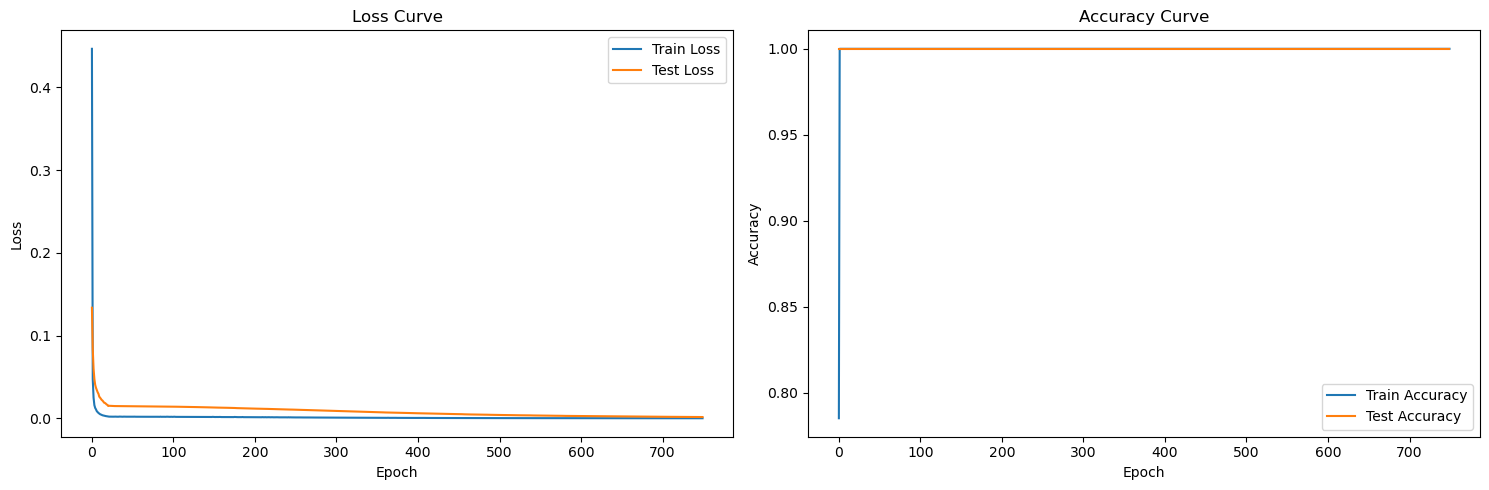

In [18]:
# Train the logistic regression model
# Example usage:
best_acc_model, best_loss_model, results = train_logreg_simplified(
    batch_size=8,
    train_feats_data=train_feats_simclr,
    test_feats_data=test_feats_simclr,
    feature_dim=train_feats_simclr.tensors[0].shape[1],
    num_classes=2,
    lr=5e-4,
    weight_decay=1e-4,
    max_epochs=750
)
#print(f"Final Train Accuracy: {results['train_acc']:.4f}, Final Test Accuracy: {results['test_acc']:.4f}")


In [19]:
logreg_model= best_loss_model
logreg_model


LogisticRegression(
  (linear): Linear(in_features=512, out_features=2, bias=True)
)

# Train the logistic regression model
# Example usage:
best_acc_model, best_loss_model, results = train_logreg_simplified(
    batch_size=8,
    train_feats_data=train_feats_simclr,
    test_feats_data=test_feats_simclr,
    feature_dim=train_feats_simclr.tensors[0].shape[1],
    num_classes=2,
    lr=5e-4,
    weight_decay=1e-4,
    max_epochs=100
)
#print(f"Final Train Accuracy: {results['train_acc']:.4f}, Final Test Accuracy: {results['test_acc']:.4f}")


In [37]:
# Save the best models by accuracy and loss
torch.save(best_acc_model.state_dict(), "1000epoch_best_acc_model.pth")
torch.save(best_loss_model.state_dict(), "1000epoch_best_loss_model.pth")


# 512= feature_dim = train_feats_simclr.tensors[0].shape[1] =  before projection head

# Save model state_dict
torch.save(logreg_model.state_dict(), "logreg_model_best.pth")


In [ ]:

# 1000 epochs: no outlier amoung exploded, control7, single dose
#500 epochs, one outlier of exploder in ds closer to sd: which is ds41_g9_C10-T01   inbetween 4 ds closer
# 100 epochs, one outlier of exploder also one outlier from ds_clos_tosd ds41_g5_E04-T01



# we got 100 % down checking whether we will get it by repeating

Extracting Features: 100%|██████████| 11/11 [00:08<00:00,  1.26it/s]


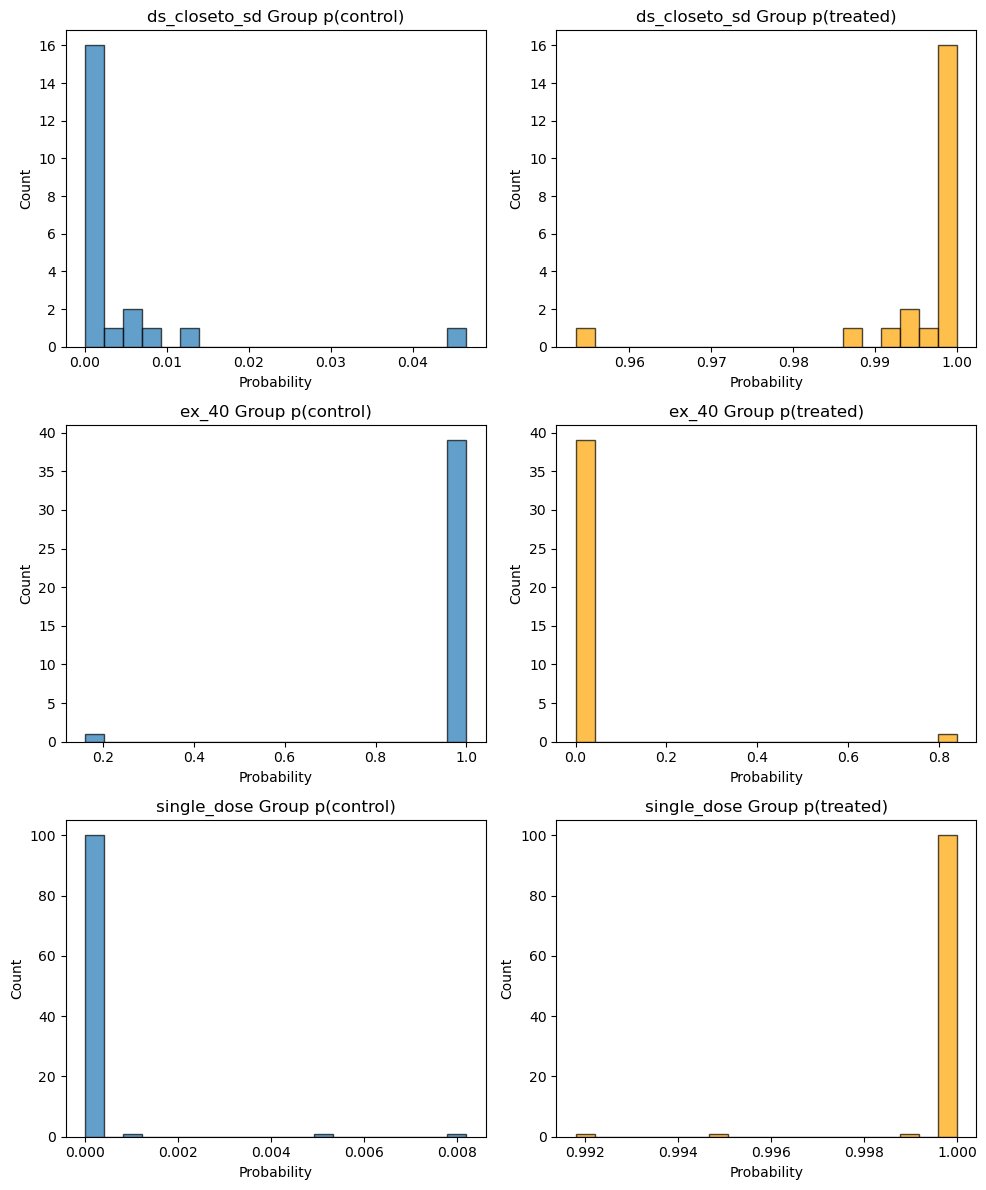

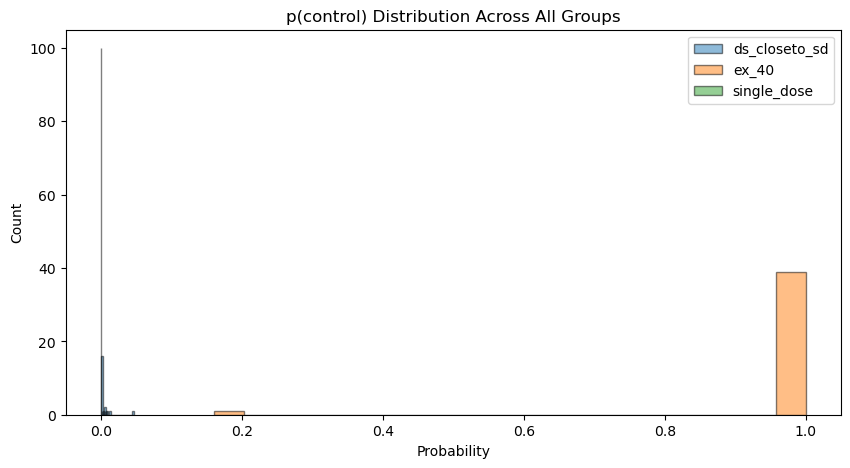

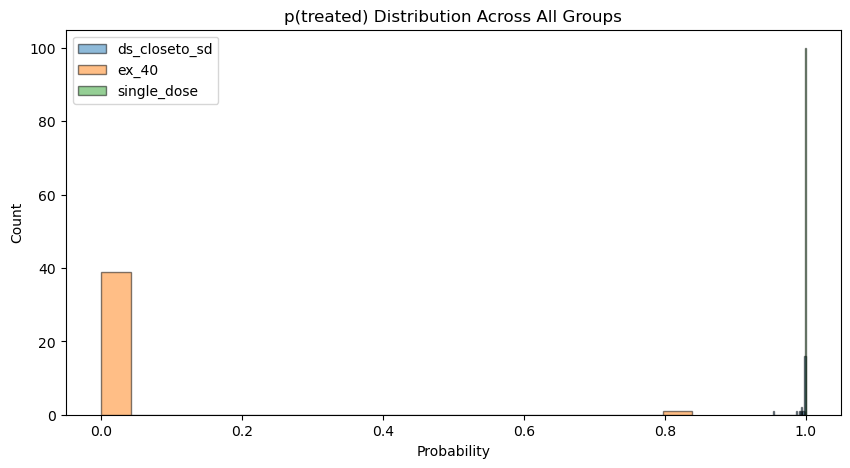

In [23]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import tifffile as tiff
from torchvision import transforms

# Assume simclr_model, logreg_model, device are already defined and loaded.
# simclr_model: the feature extractor model
# logreg_model: the logistic regression model for control vs treated classification.

def get_all_groups(root_dir):
    # All directories in root_dir are considered different groups
    groups = []
    for d in os.listdir(root_dir):
        dir_path = os.path.join(root_dir, d)
        if os.path.isdir(dir_path):
            groups.append(d)
    return groups

def load_inference_data(root_dir):
    groups = get_all_groups(root_dir)
    
    image_files = []
    group_names = []
    
    # We won't use numeric labels for correctness here since our model is only binary.
    # However, we still need a label tensor. We'll just assign a dummy label (e.g. 0) 
    # because we only need to run inference. The label doesn't affect inference.
    dummy_labels = []

    for group in groups:
        class_dir = os.path.join(root_dir, group)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir)
                 if file.lower().endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        group_names.extend([group] * len(files))
        dummy_labels.extend([0]*len(files))  # dummy label

    return image_files, dummy_labels, group_names, groups

# Dataset that returns image, a dummy label, path, and keeps track of group name externally
class LabeledImageDatasetWithPath:
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Handle shape: ensure CxHxW
        if image.ndim == 3 and image.shape[2] == 3:
            image = np.transpose(image, (2, 0, 1))
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} doesn't have 3 channels.")

        image = image.astype(np.float32) / 65535.0
        image = torch.tensor(image, dtype=torch.float32)
        image = self.resize_transform(image)

        label = self.labels[idx]
        return image, label, img_path

@torch.no_grad()
def extract_features(model, dataloader, device):
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()
    network.eval()
    network.to(device)

    all_features = []
    all_labels = []
    all_paths = []
    for batch_imgs, batch_labels, batch_paths in tqdm(dataloader, desc="Extracting Features"):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        all_features.append(batch_feats.cpu())
        all_labels.append(batch_labels)
        all_paths.extend(batch_paths)
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_features, all_labels, all_paths

@torch.no_grad()
def predict_with_probs(model, features, device):
    model.eval()
    features = features.to(device)
    logits = model(features)  # shape: [N, 2]
    probs = F.softmax(logits, dim=1)  # Convert logits to probabilities
    return probs.cpu().numpy()

# --------------------
# MAIN INFERENCE FLOW
# --------------------

root_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference_cond10_sd"

# 1. Load data from all groups
image_files, dummy_labels, group_names, groups = load_inference_data(root_dir)

# 2. Create dataset and dataloader for inference
inference_dataset = LabeledImageDatasetWithPath(image_files, dummy_labels)
inference_loader = DataLoader(inference_dataset, batch_size=16, shuffle=False, pin_memory=True, num_workers=0)

# 3. Extract features
inference_feats, inference_true_labels, inference_paths = extract_features(simclr_model, inference_loader, device)

# 4. Get probabilities from logistic regression model
probs = predict_with_probs(logreg_model, inference_feats, device)  # shape [N, 2]
# probs[:, 0] = probability of control
# probs[:, 1] = probability of treated

# Let's store results in a dictionary keyed by group name
# groups_data[group_name] = list of [p_control, p_treated, img_path]
groups_data = {g: [] for g in groups}

# Since group_names aligns with inference_paths and probs, we can pair them up
for p_control, p_treated, grp, path in zip(probs[:,0], probs[:,1], group_names, inference_paths):
    groups_data[grp].append([p_control, p_treated, path])

# Now we have groups_data with each group having a list of probabilities and paths.

# 5. Plot distributions

# Individual distributions per group:
# We'll create subplots dynamically based on how many groups we have.
num_groups = len(groups)
fig, axs = plt.subplots(num_groups, 2, figsize=(10, 4*num_groups))
# axs[i,0] -> p(control) distribution for group i
# axs[i,1] -> p(treated) distribution for group i

if num_groups == 1:
    # If there's only one group, axs is not a 2D array
    axs = np.array([axs])  # make it 2D for consistency

for i, grp in enumerate(groups):
    p_control_list = [item[0] for item in groups_data[grp]]
    p_treated_list = [item[1] for item in groups_data[grp]]

    axs[i, 0].hist(p_control_list, bins=20, alpha=0.7, edgecolor='black')
    axs[i, 0].set_title(f"{grp} Group p(control)")
    axs[i, 0].set_xlabel("Probability")
    axs[i, 0].set_ylabel("Count")

    axs[i, 1].hist(p_treated_list, bins=20, alpha=0.7, edgecolor='black', color='orange')
    axs[i, 1].set_title(f"{grp} Group p(treated)")
    axs[i, 1].set_xlabel("Probability")
    axs[i, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# 6. Plot combined distributions
# 6.1: Compare all groups p(control) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_control_list = [item[0] for item in groups_data[grp]]
    plt.hist(p_control_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(control) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# 6.2: Compare all groups p(treated) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_treated_list = [item[1] for item in groups_data[grp]]
    plt.hist(p_treated_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(treated) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# At this point:
# - We've dynamically handled any number of groups in the directory.
# - We plotted individual probability distributions for each group.
# - We also plotted combined distributions comparing all groups together for both p(control) and p(treated).


In [25]:
all_images_data = []
for grp in groups:
    # each entry is [p_control, p_treated, img_path]
    all_images_data.extend(groups_data[grp])

# Sort by p(treated) in ascending order
all_images_data.sort(key=lambda x: x[1])  # No reverse=True

# Now all_images_data is sorted by p(treated) in ascending ordergroups_data[group_name]
sorted_by_treated = [(entry[2], entry[1]) for entry in all_images_data]

print("Images sorted by p(treated) in ascending order:")
for img_path, p_tr in sorted_by_treated:
    print(f"{img_path}: {p_tr:.4f}")

Images sorted by p(treated) in ascending order:
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference_cond10_sd\ex_40\ds61_g8_B07-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference_cond10_sd\ex_40\ds61_g8_B11-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference_cond10_sd\ex_40\ds61_g8_B08-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference_cond10_sd\ex_40\ds41_g3_C02-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference_cond10_sd\ex_40\ds1B_g9_C8.tif: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference_cond10_sd\ex_40\ds61_g6_F06-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference_cond10_sd\ex_40\ds1B_g9_C7.tif: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference_cond10_sd\ex_40\ds61_g6_F04-T01.tiff: 0.0000
C:\Users\k54739\Bibi

In [26]:
import os
import shutil

# Assuming 'sorted_by_treated' is already defined as:
# sorted_by_treated = [(img_path, p_tr), ...] sorted in ascending order by p_tr

new_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\sorted_ex"
os.makedirs(new_dir, exist_ok=True)

for i, (img_path, p_tr) in enumerate(sorted_by_treated, start=1):
    # Extract the parent directory name and the original filename
    parent_dir_name = os.path.basename(os.path.dirname(img_path))  # e.g. "cond7"
    base_filename = os.path.basename(img_path)  # e.g. "ds_41.tif"
    
    # Combine them to get "cond7_ds_41.tif"
    original_filename = f"{parent_dir_name}_{base_filename}"

    # Format the probability score
    formatted_score = f"{p_tr:.4f}"
    
    # Construct the new filename with index and score
    new_filename = f"{i}_{formatted_score}_{original_filename}"
    new_path = os.path.join(new_dir, new_filename)
    
    shutil.copy2(img_path, new_path)

print("Images copied and renamed successfully!")


Images copied and renamed successfully!


# 100 %

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import tifffile as tiff
from torchvision import transforms

# Assume simclr_model, logreg_model, device are already defined and loaded.
# simclr_model: the feature extractor model
# logreg_model: the logistic regression model for control vs treated classification.

def get_all_groups(root_dir):
    # All directories in root_dir are considered different groups
    groups = []
    for d in os.listdir(root_dir):
        dir_path = os.path.join(root_dir, d)
        if os.path.isdir(dir_path):
            groups.append(d)
    return groups

def load_inference_data(root_dir):
    groups = get_all_groups(root_dir)
    
    image_files = []
    group_names = []
    
    # We won't use numeric labels for correctness here since our model is only binary.
    # However, we still need a label tensor. We'll just assign a dummy label (e.g. 0) 
    # because we only need to run inference. The label doesn't affect inference.
    dummy_labels = []

    for group in groups:
        class_dir = os.path.join(root_dir, group)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir)
                 if file.lower().endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        group_names.extend([group] * len(files))
        dummy_labels.extend([0]*len(files))  # dummy label

    return image_files, dummy_labels, group_names, groups

# Dataset that returns image, a dummy label, path, and keeps track of group name externally
class LabeledImageDatasetWithPath:
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Handle shape: ensure CxHxW
        if image.ndim == 3 and image.shape[2] == 3:
            image = np.transpose(image, (2, 0, 1))
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} doesn't have 3 channels.")

        image = image.astype(np.float32) / 65535.0
        image = torch.tensor(image, dtype=torch.float32)
        image = self.resize_transform(image)

        label = self.labels[idx]
        return image, label, img_path

@torch.no_grad()
def extract_features(model, dataloader, device):
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()
    network.eval()
    network.to(device)

    all_features = []
    all_labels = []
    all_paths = []
    for batch_imgs, batch_labels, batch_paths in tqdm(dataloader, desc="Extracting Features"):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        all_features.append(batch_feats.cpu())
        all_labels.append(batch_labels)
        all_paths.extend(batch_paths)
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_features, all_labels, all_paths

@torch.no_grad()
def predict_with_probs(model, features, device):
    model.eval()
    features = features.to(device)
    logits = model(features)  # shape: [N, 2]
    probs = F.softmax(logits, dim=1)  # Convert logits to probabilities
    return probs.cpu().numpy()

# --------------------
# MAIN INFERENCE FLOW
# --------------------

root_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference_cond10_sd"

# 1. Load data from all groups
image_files, dummy_labels, group_names, groups = load_inference_data(root_dir)

# 2. Create dataset and dataloader for inference
inference_dataset = LabeledImageDatasetWithPath(image_files, dummy_labels)
inference_loader = DataLoader(inference_dataset, batch_size=16, shuffle=False, pin_memory=True, num_workers=0)

# 3. Extract features
inference_feats, inference_true_labels, inference_paths = extract_features(simclr_model, inference_loader, device)

# 4. Get probabilities from logistic regression model
probs = predict_with_probs(logreg_model, inference_feats, device)  # shape [N, 2]
# probs[:, 0] = probability of control
# probs[:, 1] = probability of treated

# Let's store results in a dictionary keyed by group name
# groups_data[group_name] = list of [p_control, p_treated, img_path]
groups_data = {g: [] for g in groups}

# Since group_names aligns with inference_paths and probs, we can pair them up
for p_control, p_treated, grp, path in zip(probs[:,0], probs[:,1], group_names, inference_paths):
    groups_data[grp].append([p_control, p_treated, path])

# Now we have groups_data with each group having a list of probabilities and paths.

# 5. Plot distributions

# Individual distributions per group:
# We'll create subplots dynamically based on how many groups we have.
num_groups = len(groups)
fig, axs = plt.subplots(num_groups, 2, figsize=(10, 4*num_groups))
# axs[i,0] -> p(control) distribution for group i
# axs[i,1] -> p(treated) distribution for group i

if num_groups == 1:
    # If there's only one group, axs is not a 2D array
    axs = np.array([axs])  # make it 2D for consistency

for i, grp in enumerate(groups):
    p_control_list = [item[0] for item in groups_data[grp]]
    p_treated_list = [item[1] for item in groups_data[grp]]

    axs[i, 0].hist(p_control_list, bins=20, alpha=0.7, edgecolor='black')
    axs[i, 0].set_title(f"{grp} Group p(control)")
    axs[i, 0].set_xlabel("Probability")
    axs[i, 0].set_ylabel("Count")

    axs[i, 1].hist(p_treated_list, bins=20, alpha=0.7, edgecolor='black', color='orange')
    axs[i, 1].set_title(f"{grp} Group p(treated)")
    axs[i, 1].set_xlabel("Probability")
    axs[i, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# 6. Plot combined distributions
# 6.1: Compare all groups p(control) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_control_list = [item[0] for item in groups_data[grp]]
    plt.hist(p_control_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(control) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# 6.2: Compare all groups p(treated) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_treated_list = [item[1] for item in groups_data[grp]]
    plt.hist(p_treated_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(treated) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# At this point:
# - We've dynamically handled any number of groups in the directory.
# - We plotted individual probability distributions for each group.
# - We also plotted combined distributions comparing all groups together for both p(control) and p(treated).


In [ ]:
all_images_data = []
for grp in groups:
    # each entry is [p_control, p_treated, img_path]
    all_images_data.extend(groups_data[grp])

# Sort by p(treated) in ascending order
all_images_data.sort(key=lambda x: x[1])  # No reverse=True

# Now all_images_data is sorted by p(treated) in ascending ordergroups_data[group_name]
sorted_by_treated = [(entry[2], entry[1]) for entry in all_images_data]

print("Images sorted by p(treated) in ascending order:")
for img_path, p_tr in sorted_by_treated:
    print(f"{img_path}: {p_tr:.4f}")

In [ ]:
import os
import shutil

# Assuming 'sorted_by_treated' is already defined as:
# sorted_by_treated = [(img_path, p_tr), ...] sorted in ascending order by p_tr

new_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\sorted_explodall"
os.makedirs(new_dir, exist_ok=True)

for i, (img_path, p_tr) in enumerate(sorted_by_treated, start=1):
    # Extract the parent directory name and the original filename
    parent_dir_name = os.path.basename(os.path.dirname(img_path))  # e.g. "cond7"
    base_filename = os.path.basename(img_path)  # e.g. "ds_41.tif"
    
    # Combine them to get "cond7_ds_41.tif"
    original_filename = f"{parent_dir_name}_{base_filename}"

    # Format the probability score
    formatted_score = f"{p_tr:.4f}"
    
    # Construct the new filename with index and score
    new_filename = f"{i}_{formatted_score}_{original_filename}"
    new_path = os.path.join(new_dir, new_filename)
    
    shutil.copy2(img_path, new_path)

print("Images copied and renamed successfully!")


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import tifffile as tiff
from torchvision import transforms

# Assume simclr_model, logreg_model, device are already defined and loaded.
# simclr_model: the feature extractor model
# logreg_model: the logistic regression model for control vs treated classification.

def get_all_groups(root_dir):
    # All directories in root_dir are considered different groups
    groups = []
    for d in os.listdir(root_dir):
        dir_path = os.path.join(root_dir, d)
        if os.path.isdir(dir_path):
            groups.append(d)
    return groups

def load_inference_data(root_dir):
    groups = get_all_groups(root_dir)
    
    image_files = []
    group_names = []
    
    # We won't use numeric labels for correctness here since our model is only binary.
    # However, we still need a label tensor. We'll just assign a dummy label (e.g. 0) 
    # because we only need to run inference. The label doesn't affect inference.
    dummy_labels = []

    for group in groups:
        class_dir = os.path.join(root_dir, group)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir)
                 if file.lower().endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        group_names.extend([group] * len(files))
        dummy_labels.extend([0]*len(files))  # dummy label

    return image_files, dummy_labels, group_names, groups

# Dataset that returns image, a dummy label, path, and keeps track of group name externally
class LabeledImageDatasetWithPath:
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Handle shape: ensure CxHxW
        if image.ndim == 3 and image.shape[2] == 3:
            image = np.transpose(image, (2, 0, 1))
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} doesn't have 3 channels.")

        image = image.astype(np.float32) / 65535.0
        image = torch.tensor(image, dtype=torch.float32)
        image = self.resize_transform(image)

        label = self.labels[idx]
        return image, label, img_path

@torch.no_grad()
def extract_features(model, dataloader, device):
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()
    network.eval()
    network.to(device)

    all_features = []
    all_labels = []
    all_paths = []
    for batch_imgs, batch_labels, batch_paths in tqdm(dataloader, desc="Extracting Features"):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        all_features.append(batch_feats.cpu())
        all_labels.append(batch_labels)
        all_paths.extend(batch_paths)
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_features, all_labels, all_paths

@torch.no_grad()
def predict_with_probs(model, features, device):
    model.eval()
    features = features.to(device)
    logits = model(features)  # shape: [N, 2]
    probs = F.softmax(logits, dim=1)  # Convert logits to probabilities
    return probs.cpu().numpy()

# --------------------
# MAIN INFERENCE FLOW
# --------------------

root_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference"

# 1. Load data from all groups
image_files, dummy_labels, group_names, groups = load_inference_data(root_dir)

# 2. Create dataset and dataloader for inference
inference_dataset = LabeledImageDatasetWithPath(image_files, dummy_labels)
inference_loader = DataLoader(inference_dataset, batch_size=16, shuffle=False, pin_memory=True, num_workers=0)

# 3. Extract features
inference_feats, inference_true_labels, inference_paths = extract_features(simclr_model, inference_loader, device)

# 4. Get probabilities from logistic regression model
probs = predict_with_probs(logreg_model, inference_feats, device)  # shape [N, 2]
# probs[:, 0] = probability of control
# probs[:, 1] = probability of treated

# Let's store results in a dictionary keyed by group name
# groups_data[group_name] = list of [p_control, p_treated, img_path]
groups_data = {g: [] for g in groups}

# Since group_names aligns with inference_paths and probs, we can pair them up
for p_control, p_treated, grp, path in zip(probs[:,0], probs[:,1], group_names, inference_paths):
    groups_data[grp].append([p_control, p_treated, path])

# Now we have groups_data with each group having a list of probabilities and paths.

# 5. Plot distributions

# Individual distributions per group:
# We'll create subplots dynamically based on how many groups we have.
num_groups = len(groups)
fig, axs = plt.subplots(num_groups, 2, figsize=(10, 4*num_groups))
# axs[i,0] -> p(control) distribution for group i
# axs[i,1] -> p(treated) distribution for group i

if num_groups == 1:
    # If there's only one group, axs is not a 2D array
    axs = np.array([axs])  # make it 2D for consistency

for i, grp in enumerate(groups):
    p_control_list = [item[0] for item in groups_data[grp]]
    p_treated_list = [item[1] for item in groups_data[grp]]

    axs[i, 0].hist(p_control_list, bins=20, alpha=0.7, edgecolor='black')
    axs[i, 0].set_title(f"{grp} Group p(control)")
    axs[i, 0].set_xlabel("Probability")
    axs[i, 0].set_ylabel("Count")

    axs[i, 1].hist(p_treated_list, bins=20, alpha=0.7, edgecolor='black', color='orange')
    axs[i, 1].set_title(f"{grp} Group p(treated)")
    axs[i, 1].set_xlabel("Probability")
    axs[i, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# 6. Plot combined distributions
# 6.1: Compare all groups p(control) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_control_list = [item[0] for item in groups_data[grp]]
    plt.hist(p_control_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(control) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# 6.2: Compare all groups p(treated) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_treated_list = [item[1] for item in groups_data[grp]]
    plt.hist(p_treated_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(treated) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# At this point:
# - We've dynamically handled any number of groups in the directory.
# - We plotted individual probability distributions for each group.
# - We also plotted combined distributions comparing all groups together for both p(control) and p(treated).


In [ ]:
all_images_data = []
for grp in groups:
    # each entry is [p_control, p_treated, img_path]
    all_images_data.extend(groups_data[grp])

# Sort by p(treated) in ascending order
all_images_data.sort(key=lambda x: x[1])  # No reverse=True

# Now all_images_data is sorted by p(treated) in ascending order
sorted_by_treated = [(entry[2], entry[1]) for entry in all_images_data]

print("Images sorted by p(treated) in ascending order:")
for img_path, p_tr in sorted_by_treated:
    print(f"{img_path}: {p_tr:.4f}")

In [ ]:
import os
import shutil

# Assuming 'sorted_by_treated' is already defined as:
# sorted_by_treated = [(img_path, p_tr), ...] sorted in ascending order by p_tr

new_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\sorted_cond10"
os.makedirs(new_dir, exist_ok=True)

for i, (img_path, p_tr) in enumerate(sorted_by_treated, start=1):
    # Extract the parent directory name and the original filename
    parent_dir_name = os.path.basename(os.path.dirname(img_path))  # e.g. "cond7"
    base_filename = os.path.basename(img_path)  # e.g. "ds_41.tif"
    
    # Combine them to get "cond7_ds_41.tif"
    original_filename = f"{parent_dir_name}_{base_filename}"

    # Format the probability score
    formatted_score = f"{p_tr:.4f}"
    
    # Construct the new filename with index and score
    new_filename = f"{i}_{formatted_score}_{original_filename}"
    new_path = os.path.join(new_dir, new_filename)
    
    shutil.copy2(img_path, new_path)

print("Images copied and renamed successfully!")


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import tifffile as tiff
from torchvision import transforms

# Assume simclr_model, logreg_model, device are already defined and loaded.
# simclr_model: the feature extractor model
# logreg_model: the logistic regression model for control vs treated classification.

def get_all_groups(root_dir):
    # All directories in root_dir are considered different groups
    groups = []
    for d in os.listdir(root_dir):
        dir_path = os.path.join(root_dir, d)
        if os.path.isdir(dir_path):
            groups.append(d)
    return groups

def load_inference_data(root_dir):
    groups = get_all_groups(root_dir)
    
    image_files = []
    group_names = []
    
    # We won't use numeric labels for correctness here since our model is only binary.
    # However, we still need a label tensor. We'll just assign a dummy label (e.g. 0) 
    # because we only need to run inference. The label doesn't affect inference.
    dummy_labels = []

    for group in groups:
        class_dir = os.path.join(root_dir, group)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir)
                 if file.lower().endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        group_names.extend([group] * len(files))
        dummy_labels.extend([0]*len(files))  # dummy label

    return image_files, dummy_labels, group_names, groups

# Dataset that returns image, a dummy label, path, and keeps track of group name externally
class LabeledImageDatasetWithPath:
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Handle shape: ensure CxHxW
        if image.ndim == 3 and image.shape[2] == 3:
            image = np.transpose(image, (2, 0, 1))
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} doesn't have 3 channels.")

        image = image.astype(np.float32) / 65535.0
        image = torch.tensor(image, dtype=torch.float32)
        image = self.resize_transform(image)

        label = self.labels[idx]
        return image, label, img_path

@torch.no_grad()
def extract_features(model, dataloader, device):
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()
    network.eval()
    network.to(device)

    all_features = []
    all_labels = []
    all_paths = []
    for batch_imgs, batch_labels, batch_paths in tqdm(dataloader, desc="Extracting Features"):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        all_features.append(batch_feats.cpu())
        all_labels.append(batch_labels)
        all_paths.extend(batch_paths)
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_features, all_labels, all_paths

@torch.no_grad()
def predict_with_probs(model, features, device):
    model.eval()
    features = features.to(device)
    logits = model(features)  # shape: [N, 2]
    probs = F.softmax(logits, dim=1)  # Convert logits to probabilities
    return probs.cpu().numpy()

# --------------------
# MAIN INFERENCE FLOW
# --------------------

root_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference"

# 1. Load data from all groups
image_files, dummy_labels, group_names, groups = load_inference_data(root_dir)

# 2. Create dataset and dataloader for inference
inference_dataset = LabeledImageDatasetWithPath(image_files, dummy_labels)
inference_loader = DataLoader(inference_dataset, batch_size=16, shuffle=False, pin_memory=True, num_workers=0)

# 3. Extract features
inference_feats, inference_true_labels, inference_paths = extract_features(simclr_model, inference_loader, device)

# 4. Get probabilities from logistic regression model
probs = predict_with_probs(logreg_model, inference_feats, device)  # shape [N, 2]
# probs[:, 0] = probability of control
# probs[:, 1] = probability of treated

# Let's store results in a dictionary keyed by group name
# groups_data[group_name] = list of [p_control, p_treated, img_path]
groups_data = {g: [] for g in groups}

# Since group_names aligns with inference_paths and probs, we can pair them up
for p_control, p_treated, grp, path in zip(probs[:,0], probs[:,1], group_names, inference_paths):
    groups_data[grp].append([p_control, p_treated, path])

# Now we have groups_data with each group having a list of probabilities and paths.

# 5. Plot distributions

# Individual distributions per group:
# We'll create subplots dynamically based on how many groups we have.
num_groups = len(groups)
fig, axs = plt.subplots(num_groups, 2, figsize=(10, 4*num_groups))
# axs[i,0] -> p(control) distribution for group i
# axs[i,1] -> p(treated) distribution for group i

if num_groups == 1:
    # If there's only one group, axs is not a 2D array
    axs = np.array([axs])  # make it 2D for consistency

for i, grp in enumerate(groups):
    p_control_list = [item[0] for item in groups_data[grp]]
    p_treated_list = [item[1] for item in groups_data[grp]]

    axs[i, 0].hist(p_control_list, bins=20, alpha=0.7, edgecolor='black')
    axs[i, 0].set_title(f"{grp} Group p(control)")
    axs[i, 0].set_xlabel("Probability")
    axs[i, 0].set_ylabel("Count")

    axs[i, 1].hist(p_treated_list, bins=20, alpha=0.7, edgecolor='black', color='orange')
    axs[i, 1].set_title(f"{grp} Group p(treated)")
    axs[i, 1].set_xlabel("Probability")
    axs[i, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# 6. Plot combined distributions
# 6.1: Compare all groups p(control) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_control_list = [item[0] for item in groups_data[grp]]
    plt.hist(p_control_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(control) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# 6.2: Compare all groups p(treated) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_treated_list = [item[1] for item in groups_data[grp]]
    plt.hist(p_treated_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(treated) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# At this point:
# - We've dynamically handled any number of groups in the directory.
# - We plotted individual probability distributions for each group.
# - We also plotted combined distributions comparing all groups together for both p(control) and p(treated).


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import tifffile as tiff
from torchvision import transforms

# Assume simclr_model, logreg_model, device are already defined and loaded.
# simclr_model: the feature extractor model
# logreg_model: the logistic regression model for control vs treated classification.

def get_all_groups(root_dir):
    # All directories in root_dir are considered different groups
    groups = []
    for d in os.listdir(root_dir):
        dir_path = os.path.join(root_dir, d)
        if os.path.isdir(dir_path):
            groups.append(d)
    return groups

def load_inference_data(root_dir):
    groups = get_all_groups(root_dir)
    
    image_files = []
    group_names = []
    
    # We won't use numeric labels for correctness here since our model is only binary.
    # However, we still need a label tensor. We'll just assign a dummy label (e.g. 0) 
    # because we only need to run inference. The label doesn't affect inference.
    dummy_labels = []

    for group in groups:
        class_dir = os.path.join(root_dir, group)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir)
                 if file.lower().endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        group_names.extend([group] * len(files))
        dummy_labels.extend([0]*len(files))  # dummy label

    return image_files, dummy_labels, group_names, groups

# Dataset that returns image, a dummy label, path, and keeps track of group name externally
class LabeledImageDatasetWithPath:
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Handle shape: ensure CxHxW
        if image.ndim == 3 and image.shape[2] == 3:
            image = np.transpose(image, (2, 0, 1))
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} doesn't have 3 channels.")

        image = image.astype(np.float32) / 65535.0
        image = torch.tensor(image, dtype=torch.float32)
        image = self.resize_transform(image)

        label = self.labels[idx]
        return image, label, img_path

@torch.no_grad()
def extract_features(model, dataloader, device):
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()
    network.eval()
    network.to(device)

    all_features = []
    all_labels = []
    all_paths = []
    for batch_imgs, batch_labels, batch_paths in tqdm(dataloader, desc="Extracting Features"):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        all_features.append(batch_feats.cpu())
        all_labels.append(batch_labels)
        all_paths.extend(batch_paths)
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_features, all_labels, all_paths

@torch.no_grad()
def predict_with_probs(model, features, device):
    model.eval()
    features = features.to(device)
    logits = model(features)  # shape: [N, 2]
    probs = F.softmax(logits, dim=1)  # Convert logits to probabilities
    return probs.cpu().numpy()

# --------------------
# MAIN INFERENCE FLOW
# --------------------

root_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\inference"

# 1. Load data from all groups
image_files, dummy_labels, group_names, groups = load_inference_data(root_dir)

# 2. Create dataset and dataloader for inference
inference_dataset = LabeledImageDatasetWithPath(image_files, dummy_labels)
inference_loader = DataLoader(inference_dataset, batch_size=16, shuffle=False, pin_memory=True, num_workers=0)

# 3. Extract features
inference_feats, inference_true_labels, inference_paths = extract_features(simclr_model, inference_loader, device)

# 4. Get probabilities from logistic regression model
probs = predict_with_probs(logreg_model, inference_feats, device)  # shape [N, 2]
# probs[:, 0] = probability of control
# probs[:, 1] = probability of treated

# Let's store results in a dictionary keyed by group name
# groups_data[group_name] = list of [p_control, p_treated, img_path]
groups_data = {g: [] for g in groups}

# Since group_names aligns with inference_paths and probs, we can pair them up
for p_control, p_treated, grp, path in zip(probs[:,0], probs[:,1], group_names, inference_paths):
    groups_data[grp].append([p_control, p_treated, path])

# Now we have groups_data with each group having a list of probabilities and paths.

# 5. Plot distributions

# Individual distributions per group:
# We'll create subplots dynamically based on how many groups we have.
num_groups = len(groups)
fig, axs = plt.subplots(num_groups, 2, figsize=(10, 4*num_groups))
# axs[i,0] -> p(control) distribution for group i
# axs[i,1] -> p(treated) distribution for group i

if num_groups == 1:
    # If there's only one group, axs is not a 2D array
    axs = np.array([axs])  # make it 2D for consistency

for i, grp in enumerate(groups):
    p_control_list = [item[0] for item in groups_data[grp]]
    p_treated_list = [item[1] for item in groups_data[grp]]

    axs[i, 0].hist(p_control_list, bins=20, alpha=0.7, edgecolor='black')
    axs[i, 0].set_title(f"{grp} Group p(control)")
    axs[i, 0].set_xlabel("Probability")
    axs[i, 0].set_ylabel("Count")

    axs[i, 1].hist(p_treated_list, bins=20, alpha=0.7, edgecolor='black', color='orange')
    axs[i, 1].set_title(f"{grp} Group p(treated)")
    axs[i, 1].set_xlabel("Probability")
    axs[i, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# 6. Plot combined distributions
# 6.1: Compare all groups p(control) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_control_list = [item[0] for item in groups_data[grp]]
    plt.hist(p_control_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(control) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# 6.2: Compare all groups p(treated) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_treated_list = [item[1] for item in groups_data[grp]]
    plt.hist(p_treated_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(treated) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# At this point:
# - We've dynamically handled any number of groups in the directory.
# - We plotted individual probability distributions for each group.
# - We also plotted combined distributions comparing all groups together for both p(control) and p(treated).


In [ ]:
all_images_data = []
for grp in groups:
    # each entry is [p_control, p_treated, img_path]
    all_images_data.extend(groups_data[grp])

# Sort by p(treated) in ascending order
all_images_data.sort(key=lambda x: x[1])  # No reverse=True

# Now all_images_data is sorted by p(treated) in ascending order
sorted_by_treated = [(entry[2], entry[1]) for entry in all_images_data]

print("Images sorted by p(treated) in ascending order:")
for img_path, p_tr in sorted_by_treated:
    print(f"{img_path}: {p_tr:.4f}")

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import tifffile as tiff
from torchvision import transforms

# Assume simclr_model, logreg_model, device are already defined and loaded.
# simclr_model: the feature extractor model
# logreg_model: the logistic regression model for control vs treated classification.

def get_all_groups(root_dir):
    # All directories in root_dir are considered different groups
    groups = []
    for d in os.listdir(root_dir):
        dir_path = os.path.join(root_dir, d)
        if os.path.isdir(dir_path):
            groups.append(d)
    return groups

def load_inference_data(root_dir):
    groups = get_all_groups(root_dir)
    
    image_files = []
    group_names = []
    
    # We won't use numeric labels for correctness here since our model is only binary.
    # However, we still need a label tensor. We'll just assign a dummy label (e.g. 0) 
    # because we only need to run inference. The label doesn't affect inference.
    dummy_labels = []

    for group in groups:
        class_dir = os.path.join(root_dir, group)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir)
                 if file.lower().endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        group_names.extend([group] * len(files))
        dummy_labels.extend([0]*len(files))  # dummy label

    return image_files, dummy_labels, group_names, groups

# Dataset that returns image, a dummy label, path, and keeps track of group name externally
class LabeledImageDatasetWithPath:
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Handle shape: ensure CxHxW
        if image.ndim == 3 and image.shape[2] == 3:
            image = np.transpose(image, (2, 0, 1))
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} doesn't have 3 channels.")

        image = image.astype(np.float32) / 65535.0
        image = torch.tensor(image, dtype=torch.float32)
        image = self.resize_transform(image)

        label = self.labels[idx]
        return image, label, img_path

@torch.no_grad()
def extract_features(model, dataloader, device):
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()
    network.eval()
    network.to(device)

    all_features = []
    all_labels = []
    all_paths = []
    for batch_imgs, batch_labels, batch_paths in tqdm(dataloader, desc="Extracting Features"):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        all_features.append(batch_feats.cpu())
        all_labels.append(batch_labels)
        all_paths.extend(batch_paths)
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_features, all_labels, all_paths

@torch.no_grad()
def predict_with_probs(model, features, device):
    model.eval()
    features = features.to(device)
    logits = model(features)  # shape: [N, 2]
    probs = F.softmax(logits, dim=1)  # Convert logits to probabilities
    return probs.cpu().numpy()

# --------------------
# MAIN INFERENCE FLOW
# --------------------

root_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\inference"

# 1. Load data from all groups
image_files, dummy_labels, group_names, groups = load_inference_data(root_dir)

# 2. Create dataset and dataloader for inference
inference_dataset = LabeledImageDatasetWithPath(image_files, dummy_labels)
inference_loader = DataLoader(inference_dataset, batch_size=16, shuffle=False, pin_memory=True, num_workers=0)

# 3. Extract features
inference_feats, inference_true_labels, inference_paths = extract_features(simclr_model, inference_loader, device)

# 4. Get probabilities from logistic regression model
probs = predict_with_probs(logreg_model, inference_feats, device)  # shape [N, 2]
# probs[:, 0] = probability of control
# probs[:, 1] = probability of treated

# Let's store results in a dictionary keyed by group name
# groups_data[group_name] = list of [p_control, p_treated, img_path]
groups_data = {g: [] for g in groups}

# Since group_names aligns with inference_paths and probs, we can pair them up
for p_control, p_treated, grp, path in zip(probs[:,0], probs[:,1], group_names, inference_paths):
    groups_data[grp].append([p_control, p_treated, path])

# Now we have groups_data with each group having a list of probabilities and paths.

# 5. Plot distributions

# Individual distributions per group:
# We'll create subplots dynamically based on how many groups we have.
num_groups = len(groups)
fig, axs = plt.subplots(num_groups, 2, figsize=(10, 4*num_groups))
# axs[i,0] -> p(control) distribution for group i
# axs[i,1] -> p(treated) distribution for group i

if num_groups == 1:
    # If there's only one group, axs is not a 2D array
    axs = np.array([axs])  # make it 2D for consistency

for i, grp in enumerate(groups):
    p_control_list = [item[0] for item in groups_data[grp]]
    p_treated_list = [item[1] for item in groups_data[grp]]

    axs[i, 0].hist(p_control_list, bins=20, alpha=0.7, edgecolor='black')
    axs[i, 0].set_title(f"{grp} Group p(control)")
    axs[i, 0].set_xlabel("Probability")
    axs[i, 0].set_ylabel("Count")

    axs[i, 1].hist(p_treated_list, bins=20, alpha=0.7, edgecolor='black', color='orange')
    axs[i, 1].set_title(f"{grp} Group p(treated)")
    axs[i, 1].set_xlabel("Probability")
    axs[i, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# 6. Plot combined distributions
# 6.1: Compare all groups p(control) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_control_list = [item[0] for item in groups_data[grp]]
    plt.hist(p_control_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(control) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# 6.2: Compare all groups p(treated) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_treated_list = [item[1] for item in groups_data[grp]]
    plt.hist(p_treated_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(treated) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# At this point:
# - We've dynamically handled any number of groups in the directory.
# - We plotted individual probability distributions for each group.
# - We also plotted combined distributions comparing all groups together for both p(control) and p(treated).


In [ ]:
all_images_data = []
for grp in groups:
    # each entry is [p_control, p_treated, img_path]
    all_images_data.extend(groups_data[grp])

# Sort by p(treated) in ascending order
all_images_data.sort(key=lambda x: x[1])  # No reverse=True

# Now all_images_data is sorted by p(treated) in ascending order
sorted_by_treated = [(entry[2], entry[1]) for entry in all_images_data]

print("Images sorted by p(treated) in ascending order:")
for img_path, p_tr in sorted_by_treated:
    print(f"{img_path}: {p_tr:.4f}")

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import tifffile as tiff
from torchvision import transforms

# Assume simclr_model, logreg_model, device are already defined and loaded.
# simclr_model: the feature extractor model
# logreg_model: the logistic regression model for control vs treated classification.

def get_all_groups(root_dir):
    # All directories in root_dir are considered different groups
    groups = []
    for d in os.listdir(root_dir):
        dir_path = os.path.join(root_dir, d)
        if os.path.isdir(dir_path):
            groups.append(d)
    return groups

def load_inference_data(root_dir):
    groups = get_all_groups(root_dir)
    
    image_files = []
    group_names = []
    
    # We won't use numeric labels for correctness here since our model is only binary.
    # However, we still need a label tensor. We'll just assign a dummy label (e.g. 0) 
    # because we only need to run inference. The label doesn't affect inference.
    dummy_labels = []

    for group in groups:
        class_dir = os.path.join(root_dir, group)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir)
                 if file.lower().endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        group_names.extend([group] * len(files))
        dummy_labels.extend([0]*len(files))  # dummy label

    return image_files, dummy_labels, group_names, groups

# Dataset that returns image, a dummy label, path, and keeps track of group name externally
class LabeledImageDatasetWithPath:
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Handle shape: ensure CxHxW
        if image.ndim == 3 and image.shape[2] == 3:
            image = np.transpose(image, (2, 0, 1))
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} doesn't have 3 channels.")

        image = image.astype(np.float32) / 65535.0
        image = torch.tensor(image, dtype=torch.float32)
        image = self.resize_transform(image)

        label = self.labels[idx]
        return image, label, img_path

@torch.no_grad()
def extract_features(model, dataloader, device):
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()
    network.eval()
    network.to(device)

    all_features = []
    all_labels = []
    all_paths = []
    for batch_imgs, batch_labels, batch_paths in tqdm(dataloader, desc="Extracting Features"):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        all_features.append(batch_feats.cpu())
        all_labels.append(batch_labels)
        all_paths.extend(batch_paths)
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_features, all_labels, all_paths

@torch.no_grad()
def predict_with_probs(model, features, device):
    model.eval()
    features = features.to(device)
    logits = model(features)  # shape: [N, 2]
    probs = F.softmax(logits, dim=1)  # Convert logits to probabilities
    return probs.cpu().numpy()

# --------------------
# MAIN INFERENCE FLOW
# --------------------

root_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\inference"

# 1. Load data from all groups
image_files, dummy_labels, group_names, groups = load_inference_data(root_dir)

# 2. Create dataset and dataloader for inference
inference_dataset = LabeledImageDatasetWithPath(image_files, dummy_labels)
inference_loader = DataLoader(inference_dataset, batch_size=16, shuffle=False, pin_memory=True, num_workers=0)

# 3. Extract features
inference_feats, inference_true_labels, inference_paths = extract_features(simclr_model, inference_loader, device)

# 4. Get probabilities from logistic regression model
probs = predict_with_probs(logreg_model, inference_feats, device)  # shape [N, 2]
# probs[:, 0] = probability of control
# probs[:, 1] = probability of treated

# Let's store results in a dictionary keyed by group name
# groups_data[group_name] = list of [p_control, p_treated, img_path]
groups_data = {g: [] for g in groups}

# Since group_names aligns with inference_paths and probs, we can pair them up
for p_control, p_treated, grp, path in zip(probs[:,0], probs[:,1], group_names, inference_paths):
    groups_data[grp].append([p_control, p_treated, path])

# Now we have groups_data with each group having a list of probabilities and paths.

# 5. Plot distributions

# Individual distributions per group:
# We'll create subplots dynamically based on how many groups we have.
num_groups = len(groups)
fig, axs = plt.subplots(num_groups, 2, figsize=(10, 4*num_groups))
# axs[i,0] -> p(control) distribution for group i
# axs[i,1] -> p(treated) distribution for group i

if num_groups == 1:
    # If there's only one group, axs is not a 2D array
    axs = np.array([axs])  # make it 2D for consistency

for i, grp in enumerate(groups):
    p_control_list = [item[0] for item in groups_data[grp]]
    p_treated_list = [item[1] for item in groups_data[grp]]

    axs[i, 0].hist(p_control_list, bins=20, alpha=0.7, edgecolor='black')
    axs[i, 0].set_title(f"{grp} Group p(control)")
    axs[i, 0].set_xlabel("Probability")
    axs[i, 0].set_ylabel("Count")

    axs[i, 1].hist(p_treated_list, bins=20, alpha=0.7, edgecolor='black', color='orange')
    axs[i, 1].set_title(f"{grp} Group p(treated)")
    axs[i, 1].set_xlabel("Probability")
    axs[i, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# 6. Plot combined distributions
# 6.1: Compare all groups p(control) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_control_list = [item[0] for item in groups_data[grp]]
    plt.hist(p_control_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(control) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# 6.2: Compare all groups p(treated) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_treated_list = [item[1] for item in groups_data[grp]]
    plt.hist(p_treated_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(treated) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# At this point:
# - We've dynamically handled any number of groups in the directory.
# - We plotted individual probability distributions for each group.
# - We also plotted combined distributions comparing all groups together for both p(control) and p(treated).


In [ ]:
all_images_data = []
for grp in groups:
    # each entry is [p_control, p_treated, img_path]
    all_images_data.extend(groups_data[grp])

# Sort by p(treated) in ascending order
all_images_data.sort(key=lambda x: x[1])  # No reverse=True

# Now all_images_data is sorted by p(treated) in ascending order
sorted_by_treated = [(entry[2], entry[1]) for entry in all_images_data]

print("Images sorted by p(treated) in ascending order:")
for img_path, p_tr in sorted_by_treated:
    print(f"{img_path}: {p_tr:.4f}")

In [25]:
#500 epochs, one outlier of exploder in ds closer to sd: which is ds41_g9_C10-T01   inbetween 4 ds closer
# 100 epochs, one outlier of exploder also one outlier from ds_clos_tosd ds41_g5_E04-T01



In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import tifffile as tiff
from torchvision import transforms

# Assume simclr_model, logreg_model, device are already defined and loaded.
# simclr_model: the feature extractor model
# logreg_model: the logistic regression model for control vs treated classification.

def get_all_groups(root_dir):
    # All directories in root_dir are considered different groups
    groups = []
    for d in os.listdir(root_dir):
        dir_path = os.path.join(root_dir, d)
        if os.path.isdir(dir_path):
            groups.append(d)
    return groups

def load_inference_data(root_dir):
    groups = get_all_groups(root_dir)
    
    image_files = []
    group_names = []
    
    # We won't use numeric labels for correctness here since our model is only binary.
    # However, we still need a label tensor. We'll just assign a dummy label (e.g. 0) 
    # because we only need to run inference. The label doesn't affect inference.
    dummy_labels = []

    for group in groups:
        class_dir = os.path.join(root_dir, group)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir)
                 if file.lower().endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        group_names.extend([group] * len(files))
        dummy_labels.extend([0]*len(files))  # dummy label

    return image_files, dummy_labels, group_names, groups

# Dataset that returns image, a dummy label, path, and keeps track of group name externally
class LabeledImageDatasetWithPath:
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Handle shape: ensure CxHxW
        if image.ndim == 3 and image.shape[2] == 3:
            image = np.transpose(image, (2, 0, 1))
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} doesn't have 3 channels.")

        image = image.astype(np.float32) / 65535.0
        image = torch.tensor(image, dtype=torch.float32)
        image = self.resize_transform(image)

        label = self.labels[idx]
        return image, label, img_path

@torch.no_grad()
def extract_features(model, dataloader, device):
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()
    network.eval()
    network.to(device)

    all_features = []
    all_labels = []
    all_paths = []
    for batch_imgs, batch_labels, batch_paths in tqdm(dataloader, desc="Extracting Features"):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        all_features.append(batch_feats.cpu())
        all_labels.append(batch_labels)
        all_paths.extend(batch_paths)
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_features, all_labels, all_paths

@torch.no_grad()
def predict_with_probs(model, features, device):
    model.eval()
    features = features.to(device)
    logits = model(features)  # shape: [N, 2]
    probs = F.softmax(logits, dim=1)  # Convert logits to probabilities
    return probs.cpu().numpy()

# --------------------
# MAIN INFERENCE FLOW
# --------------------

root_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\inference"

# 1. Load data from all groups
image_files, dummy_labels, group_names, groups = load_inference_data(root_dir)

# 2. Create dataset and dataloader for inference
inference_dataset = LabeledImageDatasetWithPath(image_files, dummy_labels)
inference_loader = DataLoader(inference_dataset, batch_size=16, shuffle=False, pin_memory=True, num_workers=0)

# 3. Extract features
inference_feats, inference_true_labels, inference_paths = extract_features(simclr_model, inference_loader, device)

# 4. Get probabilities from logistic regression model
probs = predict_with_probs(logreg_model, inference_feats, device)  # shape [N, 2]
# probs[:, 0] = probability of control
# probs[:, 1] = probability of treated

# Let's store results in a dictionary keyed by group name
# groups_data[group_name] = list of [p_control, p_treated, img_path]
groups_data = {g: [] for g in groups}

# Since group_names aligns with inference_paths and probs, we can pair them up
for p_control, p_treated, grp, path in zip(probs[:,0], probs[:,1], group_names, inference_paths):
    groups_data[grp].append([p_control, p_treated, path])

# Now we have groups_data with each group having a list of probabilities and paths.

# 5. Plot distributions

# Individual distributions per group:
# We'll create subplots dynamically based on how many groups we have.
num_groups = len(groups)
fig, axs = plt.subplots(num_groups, 2, figsize=(10, 4*num_groups))
# axs[i,0] -> p(control) distribution for group i
# axs[i,1] -> p(treated) distribution for group i

if num_groups == 1:
    # If there's only one group, axs is not a 2D array
    axs = np.array([axs])  # make it 2D for consistency

for i, grp in enumerate(groups):
    p_control_list = [item[0] for item in groups_data[grp]]
    p_treated_list = [item[1] for item in groups_data[grp]]

    axs[i, 0].hist(p_control_list, bins=20, alpha=0.7, edgecolor='black')
    axs[i, 0].set_title(f"{grp} Group p(control)")
    axs[i, 0].set_xlabel("Probability")
    axs[i, 0].set_ylabel("Count")

    axs[i, 1].hist(p_treated_list, bins=20, alpha=0.7, edgecolor='black', color='orange')
    axs[i, 1].set_title(f"{grp} Group p(treated)")
    axs[i, 1].set_xlabel("Probability")
    axs[i, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# 6. Plot combined distributions
# 6.1: Compare all groups p(control) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_control_list = [item[0] for item in groups_data[grp]]
    plt.hist(p_control_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(control) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# 6.2: Compare all groups p(treated) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_treated_list = [item[1] for item in groups_data[grp]]
    plt.hist(p_treated_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(treated) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# At this point:
# - We've dynamically handled any number of groups in the directory.
# - We plotted individual probability distributions for each group.
# - We also plotted combined distributions comparing all groups together for both p(control) and p(treated).


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import tifffile as tiff
from torchvision import transforms

# Assume simclr_model, logreg_model, device are already defined and loaded.
# simclr_model: the feature extractor model
# logreg_model: the logistic regression model for control vs treated classification.

def get_all_groups(root_dir):
    # All directories in root_dir are considered different groups
    groups = []
    for d in os.listdir(root_dir):
        dir_path = os.path.join(root_dir, d)
        if os.path.isdir(dir_path):
            groups.append(d)
    return groups

def load_inference_data(root_dir):
    groups = get_all_groups(root_dir)
    
    image_files = []
    group_names = []
    
    # We won't use numeric labels for correctness here since our model is only binary.
    # However, we still need a label tensor. We'll just assign a dummy label (e.g. 0) 
    # because we only need to run inference. The label doesn't affect inference.
    dummy_labels = []

    for group in groups:
        class_dir = os.path.join(root_dir, group)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir)
                 if file.lower().endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        group_names.extend([group] * len(files))
        dummy_labels.extend([0]*len(files))  # dummy label

    return image_files, dummy_labels, group_names, groups

# Dataset that returns image, a dummy label, path, and keeps track of group name externally
class LabeledImageDatasetWithPath:
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Handle shape: ensure CxHxW
        if image.ndim == 3 and image.shape[2] == 3:
            image = np.transpose(image, (2, 0, 1))
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} doesn't have 3 channels.")

        image = image.astype(np.float32) / 65535.0
        image = torch.tensor(image, dtype=torch.float32)
        image = self.resize_transform(image)

        label = self.labels[idx]
        return image, label, img_path

@torch.no_grad()
def extract_features(model, dataloader, device):
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()
    network.eval()
    network.to(device)

    all_features = []
    all_labels = []
    all_paths = []
    for batch_imgs, batch_labels, batch_paths in tqdm(dataloader, desc="Extracting Features"):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        all_features.append(batch_feats.cpu())
        all_labels.append(batch_labels)
        all_paths.extend(batch_paths)
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_features, all_labels, all_paths

@torch.no_grad()
def predict_with_probs(model, features, device):
    model.eval()
    features = features.to(device)
    logits = model(features)  # shape: [N, 2]
    probs = F.softmax(logits, dim=1)  # Convert logits to probabilities
    return probs.cpu().numpy()

# --------------------
# MAIN INFERENCE FLOW
# --------------------

root_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\inference"

# 1. Load data from all groups
image_files, dummy_labels, group_names, groups = load_inference_data(root_dir)

# 2. Create dataset and dataloader for inference
inference_dataset = LabeledImageDatasetWithPath(image_files, dummy_labels)
inference_loader = DataLoader(inference_dataset, batch_size=16, shuffle=False, pin_memory=True, num_workers=0)

# 3. Extract features
inference_feats, inference_true_labels, inference_paths = extract_features(simclr_model, inference_loader, device)

# 4. Get probabilities from logistic regression model
probs = predict_with_probs(logreg_model, inference_feats, device)  # shape [N, 2]
# probs[:, 0] = probability of control
# probs[:, 1] = probability of treated

# Let's store results in a dictionary keyed by group name
# groups_data[group_name] = list of [p_control, p_treated, img_path]
groups_data = {g: [] for g in groups}

# Since group_names aligns with inference_paths and probs, we can pair them up
for p_control, p_treated, grp, path in zip(probs[:,0], probs[:,1], group_names, inference_paths):
    groups_data[grp].append([p_control, p_treated, path])

# Now we have groups_data with each group having a list of probabilities and paths.

# 5. Plot distributions

# Individual distributions per group:
# We'll create subplots dynamically based on how many groups we have.
num_groups = len(groups)
fig, axs = plt.subplots(num_groups, 2, figsize=(10, 4*num_groups))
# axs[i,0] -> p(control) distribution for group i
# axs[i,1] -> p(treated) distribution for group i

if num_groups == 1:
    # If there's only one group, axs is not a 2D array
    axs = np.array([axs])  # make it 2D for consistency

for i, grp in enumerate(groups):
    p_control_list = [item[0] for item in groups_data[grp]]
    p_treated_list = [item[1] for item in groups_data[grp]]

    axs[i, 0].hist(p_control_list, bins=20, alpha=0.7, edgecolor='black')
    axs[i, 0].set_title(f"{grp} Group p(control)")
    axs[i, 0].set_xlabel("Probability")
    axs[i, 0].set_ylabel("Count")

    axs[i, 1].hist(p_treated_list, bins=20, alpha=0.7, edgecolor='black', color='orange')
    axs[i, 1].set_title(f"{grp} Group p(treated)")
    axs[i, 1].set_xlabel("Probability")
    axs[i, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# 6. Plot combined distributions
# 6.1: Compare all groups p(control) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_control_list = [item[0] for item in groups_data[grp]]
    plt.hist(p_control_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(control) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# 6.2: Compare all groups p(treated) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_treated_list = [item[1] for item in groups_data[grp]]
    plt.hist(p_treated_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(treated) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# At this point:
# - We've dynamically handled any number of groups in the directory.
# - We plotted individual probability distributions for each group.
# - We also plotted combined distributions comparing all groups together for both p(control) and p(treated).


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import tifffile as tiff
from torchvision import transforms

# Assume simclr_model, logreg_model, device are already defined and loaded.
# simclr_model: the feature extractor model
# logreg_model: the logistic regression model for control vs treated classification.

def get_all_groups(root_dir):
    # All directories in root_dir are considered different groups
    groups = []
    for d in os.listdir(root_dir):
        dir_path = os.path.join(root_dir, d)
        if os.path.isdir(dir_path):
            groups.append(d)
    return groups

def load_inference_data(root_dir):
    groups = get_all_groups(root_dir)
    
    image_files = []
    group_names = []
    
    # We won't use numeric labels for correctness here since our model is only binary.
    # However, we still need a label tensor. We'll just assign a dummy label (e.g. 0) 
    # because we only need to run inference. The label doesn't affect inference.
    dummy_labels = []

    for group in groups:
        class_dir = os.path.join(root_dir, group)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir)
                 if file.lower().endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        group_names.extend([group] * len(files))
        dummy_labels.extend([0]*len(files))  # dummy label

    return image_files, dummy_labels, group_names, groups

# Dataset that returns image, a dummy label, path, and keeps track of group name externally
class LabeledImageDatasetWithPath:
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Handle shape: ensure CxHxW
        if image.ndim == 3 and image.shape[2] == 3:
            image = np.transpose(image, (2, 0, 1))
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} doesn't have 3 channels.")

        image = image.astype(np.float32) / 65535.0
        image = torch.tensor(image, dtype=torch.float32)
        image = self.resize_transform(image)

        label = self.labels[idx]
        return image, label, img_path

@torch.no_grad()
def extract_features(model, dataloader, device):
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()
    network.eval()
    network.to(device)

    all_features = []
    all_labels = []
    all_paths = []
    for batch_imgs, batch_labels, batch_paths in tqdm(dataloader, desc="Extracting Features"):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        all_features.append(batch_feats.cpu())
        all_labels.append(batch_labels)
        all_paths.extend(batch_paths)
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_features, all_labels, all_paths

@torch.no_grad()
def predict_with_probs(model, features, device):
    model.eval()
    features = features.to(device)
    logits = model(features)  # shape: [N, 2]
    probs = F.softmax(logits, dim=1)  # Convert logits to probabilities
    return probs.cpu().numpy()

# --------------------
# MAIN INFERENCE FLOW
# --------------------

root_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\inference"

# 1. Load data from all groups
image_files, dummy_labels, group_names, groups = load_inference_data(root_dir)

# 2. Create dataset and dataloader for inference
inference_dataset = LabeledImageDatasetWithPath(image_files, dummy_labels)
inference_loader = DataLoader(inference_dataset, batch_size=16, shuffle=False, pin_memory=True, num_workers=0)

# 3. Extract features
inference_feats, inference_true_labels, inference_paths = extract_features(simclr_model, inference_loader, device)

# 4. Get probabilities from logistic regression model
probs = predict_with_probs(logreg_model, inference_feats, device)  # shape [N, 2]
# probs[:, 0] = probability of control
# probs[:, 1] = probability of treated

# Let's store results in a dictionary keyed by group name
# groups_data[group_name] = list of [p_control, p_treated, img_path]
groups_data = {g: [] for g in groups}

# Since group_names aligns with inference_paths and probs, we can pair them up
for p_control, p_treated, grp, path in zip(probs[:,0], probs[:,1], group_names, inference_paths):
    groups_data[grp].append([p_control, p_treated, path])

# Now we have groups_data with each group having a list of probabilities and paths.

# 5. Plot distributions

# Individual distributions per group:
# We'll create subplots dynamically based on how many groups we have.
num_groups = len(groups)
fig, axs = plt.subplots(num_groups, 2, figsize=(10, 4*num_groups))
# axs[i,0] -> p(control) distribution for group i
# axs[i,1] -> p(treated) distribution for group i

if num_groups == 1:
    # If there's only one group, axs is not a 2D array
    axs = np.array([axs])  # make it 2D for consistency

for i, grp in enumerate(groups):
    p_control_list = [item[0] for item in groups_data[grp]]
    p_treated_list = [item[1] for item in groups_data[grp]]

    axs[i, 0].hist(p_control_list, bins=20, alpha=0.7, edgecolor='black')
    axs[i, 0].set_title(f"{grp} Group p(control)")
    axs[i, 0].set_xlabel("Probability")
    axs[i, 0].set_ylabel("Count")

    axs[i, 1].hist(p_treated_list, bins=20, alpha=0.7, edgecolor='black', color='orange')
    axs[i, 1].set_title(f"{grp} Group p(treated)")
    axs[i, 1].set_xlabel("Probability")
    axs[i, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# 6. Plot combined distributions
# 6.1: Compare all groups p(control) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_control_list = [item[0] for item in groups_data[grp]]
    plt.hist(p_control_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(control) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# 6.2: Compare all groups p(treated) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_treated_list = [item[1] for item in groups_data[grp]]
    plt.hist(p_treated_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(treated) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# At this point:
# - We've dynamically handled any number of groups in the directory.
# - We plotted individual probability distributions for each group.
# - We also plotted combined distributions comparing all groups together for both p(control) and p(treated).


In [ ]:
all_images_data = []
for grp in groups:
    # each entry is [p_control, p_treated, img_path]
    all_images_data.extend(groups_data[grp])

# Sort by p(treated) in ascending order
all_images_data.sort(key=lambda x: x[1])  # No reverse=True

# Now all_images_data is sorted by p(treated) in ascending order
sorted_by_treated = [(entry[2], entry[1]) for entry in all_images_data]

print("Images sorted by p(treated) in ascending order:")
for img_path, p_tr in sorted_by_treated:
    print(f"{img_path}: {p_tr:.4f}")

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import tifffile as tiff
from torchvision import transforms

# Assume simclr_model, logreg_model, device are already defined and loaded.
# simclr_model: the feature extractor model
# logreg_model: the logistic regression model for control vs treated classification.

def get_all_groups(root_dir):
    # All directories in root_dir are considered different groups
    groups = []
    for d in os.listdir(root_dir):
        dir_path = os.path.join(root_dir, d)
        if os.path.isdir(dir_path):
            groups.append(d)
    return groups

def load_inference_data(root_dir):
    groups = get_all_groups(root_dir)
    
    image_files = []
    group_names = []
    
    # We won't use numeric labels for correctness here since our model is only binary.
    # However, we still need a label tensor. We'll just assign a dummy label (e.g. 0) 
    # because we only need to run inference. The label doesn't affect inference.
    dummy_labels = []

    for group in groups:
        class_dir = os.path.join(root_dir, group)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir)
                 if file.lower().endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        group_names.extend([group] * len(files))
        dummy_labels.extend([0]*len(files))  # dummy label

    return image_files, dummy_labels, group_names, groups

# Dataset that returns image, a dummy label, path, and keeps track of group name externally
class LabeledImageDatasetWithPath:
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Handle shape: ensure CxHxW
        if image.ndim == 3 and image.shape[2] == 3:
            image = np.transpose(image, (2, 0, 1))
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} doesn't have 3 channels.")

        image = image.astype(np.float32) / 65535.0
        image = torch.tensor(image, dtype=torch.float32)
        image = self.resize_transform(image)

        label = self.labels[idx]
        return image, label, img_path

@torch.no_grad()
def extract_features(model, dataloader, device):
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()
    network.eval()
    network.to(device)

    all_features = []
    all_labels = []
    all_paths = []
    for batch_imgs, batch_labels, batch_paths in tqdm(dataloader, desc="Extracting Features"):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        all_features.append(batch_feats.cpu())
        all_labels.append(batch_labels)
        all_paths.extend(batch_paths)
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_features, all_labels, all_paths

@torch.no_grad()
def predict_with_probs(model, features, device):
    model.eval()
    features = features.to(device)
    logits = model(features)  # shape: [N, 2]
    probs = F.softmax(logits, dim=1)  # Convert logits to probabilities
    return probs.cpu().numpy()

# --------------------
# MAIN INFERENCE FLOW
# --------------------

root_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\inference"

# 1. Load data from all groups
image_files, dummy_labels, group_names, groups = load_inference_data(root_dir)

# 2. Create dataset and dataloader for inference
inference_dataset = LabeledImageDatasetWithPath(image_files, dummy_labels)
inference_loader = DataLoader(inference_dataset, batch_size=16, shuffle=False, pin_memory=True, num_workers=0)

# 3. Extract features
inference_feats, inference_true_labels, inference_paths = extract_features(simclr_model, inference_loader, device)

# 4. Get probabilities from logistic regression model
probs = predict_with_probs(logreg_model, inference_feats, device)  # shape [N, 2]
# probs[:, 0] = probability of control
# probs[:, 1] = probability of treated

# Let's store results in a dictionary keyed by group name
# groups_data[group_name] = list of [p_control, p_treated, img_path]
groups_data = {g: [] for g in groups}

# Since group_names aligns with inference_paths and probs, we can pair them up
for p_control, p_treated, grp, path in zip(probs[:,0], probs[:,1], group_names, inference_paths):
    groups_data[grp].append([p_control, p_treated, path])

# Now we have groups_data with each group having a list of probabilities and paths.

# 5. Plot distributions

# Individual distributions per group:
# We'll create subplots dynamically based on how many groups we have.
num_groups = len(groups)
fig, axs = plt.subplots(num_groups, 2, figsize=(10, 4*num_groups))
# axs[i,0] -> p(control) distribution for group i
# axs[i,1] -> p(treated) distribution for group i

if num_groups == 1:
    # If there's only one group, axs is not a 2D array
    axs = np.array([axs])  # make it 2D for consistency

for i, grp in enumerate(groups):
    p_control_list = [item[0] for item in groups_data[grp]]
    p_treated_list = [item[1] for item in groups_data[grp]]

    axs[i, 0].hist(p_control_list, bins=20, alpha=0.7, edgecolor='black')
    axs[i, 0].set_title(f"{grp} Group p(control)")
    axs[i, 0].set_xlabel("Probability")
    axs[i, 0].set_ylabel("Count")

    axs[i, 1].hist(p_treated_list, bins=20, alpha=0.7, edgecolor='black', color='orange')
    axs[i, 1].set_title(f"{grp} Group p(treated)")
    axs[i, 1].set_xlabel("Probability")
    axs[i, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# 6. Plot combined distributions
# 6.1: Compare all groups p(control) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_control_list = [item[0] for item in groups_data[grp]]
    plt.hist(p_control_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(control) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# 6.2: Compare all groups p(treated) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_treated_list = [item[1] for item in groups_data[grp]]
    plt.hist(p_treated_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(treated) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# At this point:
# - We've dynamically handled any number of groups in the directory.
# - We plotted individual probability distributions for each group.
# - We also plotted combined distributions comparing all groups together for both p(control) and p(treated).


In [ ]:
all_images_data = []
for grp in groups:
    # each entry is [p_control, p_treated, img_path]
    all_images_data.extend(groups_data[grp])

# Sort by p(treated) in ascending order
all_images_data.sort(key=lambda x: x[1])  # No reverse=True

# Now all_images_data is sorted by p(treated) in ascending order
sorted_by_treated = [(entry[2], entry[1]) for entry in all_images_data]

print("Images sorted by p(treated) in ascending order:")
for img_path, p_tr in sorted_by_treated:
    print(f"{img_path}: {p_tr:.4f}")

# Inference

In [6]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import transforms

import tifffile as tiff
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import random
#from helper import set_seed

In [7]:
# Logistic Regression model definition
class LogisticRegression(nn.Module):
    def __init__(self, feature_dim, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        return self.linear(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Recreate the model structure
feature_dim = 512 # Set this to the same dimension used during training
num_classes = 2   # Since you trained for 2 classes
logreg_model = LogisticRegression(feature_dim, num_classes).to(device)

# Load the saved weights
logreg_model.load_state_dict(torch.load("best_loss_model.pth", map_location=device))
logreg_model.eval()

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import tifffile as tiff
from torchvision import transforms

# Assume simclr_model, logreg_model, device are already defined and loaded.
# simclr_model: the feature extractor model
# logreg_model: the logistic regression model for control vs treated classification.

def get_all_groups(root_dir):
    # All directories in root_dir are considered different groups
    groups = []
    for d in os.listdir(root_dir):
        dir_path = os.path.join(root_dir, d)
        if os.path.isdir(dir_path):
            groups.append(d)
    return groups

def load_inference_data(root_dir):
    groups = get_all_groups(root_dir)
    
    image_files = []
    group_names = []
    
    # We won't use numeric labels for correctness here since our model is only binary.
    # However, we still need a label tensor. We'll just assign a dummy label (e.g. 0) 
    # because we only need to run inference. The label doesn't affect inference.
    dummy_labels = []

    for group in groups:
        class_dir = os.path.join(root_dir, group)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir)
                 if file.lower().endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        group_names.extend([group] * len(files))
        dummy_labels.extend([0]*len(files))  # dummy label

    return image_files, dummy_labels, group_names, groups

# Dataset that returns image, a dummy label, path, and keeps track of group name externally
class LabeledImageDatasetWithPath:
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Handle shape: ensure CxHxW
        if image.ndim == 3 and image.shape[2] == 3:
            image = np.transpose(image, (2, 0, 1))
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} doesn't have 3 channels.")

        image = image.astype(np.float32) / 65535.0
        image = torch.tensor(image, dtype=torch.float32)
        image = self.resize_transform(image)

        label = self.labels[idx]
        return image, label, img_path

@torch.no_grad()
def extract_features(model, dataloader, device):
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()
    network.eval()
    network.to(device)

    all_features = []
    all_labels = []
    all_paths = []
    for batch_imgs, batch_labels, batch_paths in tqdm(dataloader, desc="Extracting Features"):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        all_features.append(batch_feats.cpu())
        all_labels.append(batch_labels)
        all_paths.extend(batch_paths)
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_features, all_labels, all_paths

@torch.no_grad()
def predict_with_probs(model, features, device):
    model.eval()
    features = features.to(device)
    logits = model(features)  # shape: [N, 2]
    probs = F.softmax(logits, dim=1)  # Convert logits to probabilities
    return probs.cpu().numpy()

# --------------------
# MAIN INFERENCE FLOW
# --------------------

root_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\inference"

# 1. Load data from all groups
image_files, dummy_labels, group_names, groups = load_inference_data(root_dir)

# 2. Create dataset and dataloader for inference
inference_dataset = LabeledImageDatasetWithPath(image_files, dummy_labels)
inference_loader = DataLoader(inference_dataset, batch_size=16, shuffle=False, pin_memory=True, num_workers=0)

# 3. Extract features
inference_feats, inference_true_labels, inference_paths = extract_features(simclr_model, inference_loader, device)

# 4. Get probabilities from logistic regression model
probs = predict_with_probs(logreg_model, inference_feats, device)  # shape [N, 2]
# probs[:, 0] = probability of control
# probs[:, 1] = probability of treated

# Let's store results in a dictionary keyed by group name
# groups_data[group_name] = list of [p_control, p_treated, img_path]
groups_data = {g: [] for g in groups}

# Since group_names aligns with inference_paths and probs, we can pair them up
for p_control, p_treated, grp, path in zip(probs[:,0], probs[:,1], group_names, inference_paths):
    groups_data[grp].append([p_control, p_treated, path])

# Now we have groups_data with each group having a list of probabilities and paths.

# 5. Plot distributions

# Individual distributions per group:
# We'll create subplots dynamically based on how many groups we have.
num_groups = len(groups)
fig, axs = plt.subplots(num_groups, 2, figsize=(10, 4*num_groups))
# axs[i,0] -> p(control) distribution for group i
# axs[i,1] -> p(treated) distribution for group i

if num_groups == 1:
    # If there's only one group, axs is not a 2D array
    axs = np.array([axs])  # make it 2D for consistency

for i, grp in enumerate(groups):
    p_control_list = [item[0] for item in groups_data[grp]]
    p_treated_list = [item[1] for item in groups_data[grp]]

    axs[i, 0].hist(p_control_list, bins=20, alpha=0.7, edgecolor='black')
    axs[i, 0].set_title(f"{grp} Group p(control)")
    axs[i, 0].set_xlabel("Probability")
    axs[i, 0].set_ylabel("Count")

    axs[i, 1].hist(p_treated_list, bins=20, alpha=0.7, edgecolor='black', color='orange')
    axs[i, 1].set_title(f"{grp} Group p(treated)")
    axs[i, 1].set_xlabel("Probability")
    axs[i, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# 6. Plot combined distributions
# 6.1: Compare all groups p(control) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_control_list = [item[0] for item in groups_data[grp]]
    plt.hist(p_control_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(control) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# 6.2: Compare all groups p(treated) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_treated_list = [item[1] for item in groups_data[grp]]
    plt.hist(p_treated_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(treated) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# At this point:
# - We've dynamically handled any number of groups in the directory.
# - We plotted individual probability distributions for each group.
# - We also plotted combined distributions comparing all groups together for both p(control) and p(treated).


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import tifffile as tiff
from torchvision import transforms

# Assume simclr_model, logreg_model, device are already defined and loaded.
# simclr_model: the feature extractor model
# logreg_model: the logistic regression model for control vs treated classification.

def get_all_groups(root_dir):
    # All directories in root_dir are considered different groups
    groups = []
    for d in os.listdir(root_dir):
        dir_path = os.path.join(root_dir, d)
        if os.path.isdir(dir_path):
            groups.append(d)
    return groups

def load_inference_data(root_dir):
    groups = get_all_groups(root_dir)
    
    image_files = []
    group_names = []
    
    # We won't use numeric labels for correctness here since our model is only binary.
    # However, we still need a label tensor. We'll just assign a dummy label (e.g. 0) 
    # because we only need to run inference. The label doesn't affect inference.
    dummy_labels = []

    for group in groups:
        class_dir = os.path.join(root_dir, group)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir)
                 if file.lower().endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        group_names.extend([group] * len(files))
        dummy_labels.extend([0]*len(files))  # dummy label

    return image_files, dummy_labels, group_names, groups

# Dataset that returns image, a dummy label, path, and keeps track of group name externally
class LabeledImageDatasetWithPath:
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Handle shape: ensure CxHxW
        if image.ndim == 3 and image.shape[2] == 3:
            image = np.transpose(image, (2, 0, 1))
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} doesn't have 3 channels.")

        image = image.astype(np.float32) / 65535.0
        image = torch.tensor(image, dtype=torch.float32)
        image = self.resize_transform(image)

        label = self.labels[idx]
        return image, label, img_path

@torch.no_grad()
def extract_features(model, dataloader, device):
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()
    network.eval()
    network.to(device)

    all_features = []
    all_labels = []
    all_paths = []
    for batch_imgs, batch_labels, batch_paths in tqdm(dataloader, desc="Extracting Features"):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        all_features.append(batch_feats.cpu())
        all_labels.append(batch_labels)
        all_paths.extend(batch_paths)
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_features, all_labels, all_paths

@torch.no_grad()
def predict_with_probs(model, features, device):
    model.eval()
    features = features.to(device)
    logits = model(features)  # shape: [N, 2]
    probs = F.softmax(logits, dim=1)  # Convert logits to probabilities
    return probs.cpu().numpy()

# --------------------
# MAIN INFERENCE FLOW
# --------------------

root_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\inference"

# 1. Load data from all groups
image_files, dummy_labels, group_names, groups = load_inference_data(root_dir)

# 2. Create dataset and dataloader for inference
inference_dataset = LabeledImageDatasetWithPath(image_files, dummy_labels)
inference_loader = DataLoader(inference_dataset, batch_size=16, shuffle=False, pin_memory=True, num_workers=0)

# 3. Extract features
inference_feats, inference_true_labels, inference_paths = extract_features(simclr_model, inference_loader, device)

# 4. Get probabilities from logistic regression model
probs = predict_with_probs(logreg_model, inference_feats, device)  # shape [N, 2]
# probs[:, 0] = probability of control
# probs[:, 1] = probability of treated

# Let's store results in a dictionary keyed by group name
# groups_data[group_name] = list of [p_control, p_treated, img_path]
groups_data = {g: [] for g in groups}

# Since group_names aligns with inference_paths and probs, we can pair them up
for p_control, p_treated, grp, path in zip(probs[:,0], probs[:,1], group_names, inference_paths):
    groups_data[grp].append([p_control, p_treated, path])

# Now we have groups_data with each group having a list of probabilities and paths.

# 5. Plot distributions

# Individual distributions per group:
# We'll create subplots dynamically based on how many groups we have.
num_groups = len(groups)
fig, axs = plt.subplots(num_groups, 2, figsize=(10, 4*num_groups))
# axs[i,0] -> p(control) distribution for group i
# axs[i,1] -> p(treated) distribution for group i

if num_groups == 1:
    # If there's only one group, axs is not a 2D array
    axs = np.array([axs])  # make it 2D for consistency

for i, grp in enumerate(groups):
    p_control_list = [item[0] for item in groups_data[grp]]
    p_treated_list = [item[1] for item in groups_data[grp]]

    axs[i, 0].hist(p_control_list, bins=20, alpha=0.7, edgecolor='black')
    axs[i, 0].set_title(f"{grp} Group p(control)")
    axs[i, 0].set_xlabel("Probability")
    axs[i, 0].set_ylabel("Count")

    axs[i, 1].hist(p_treated_list, bins=20, alpha=0.7, edgecolor='black', color='orange')
    axs[i, 1].set_title(f"{grp} Group p(treated)")
    axs[i, 1].set_xlabel("Probability")
    axs[i, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# 6. Plot combined distributions
# 6.1: Compare all groups p(control) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_control_list = [item[0] for item in groups_data[grp]]
    plt.hist(p_control_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(control) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# 6.2: Compare all groups p(treated) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_treated_list = [item[1] for item in groups_data[grp]]
    plt.hist(p_treated_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(treated) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# At this point:
# - We've dynamically handled any number of groups in the directory.
# - We plotted individual probability distributions for each group.
# - We also plotted combined distributions comparing all groups together for both p(control) and p(treated).


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import tifffile as tiff
from torchvision import transforms

# Assume simclr_model, logreg_model, device are already defined and loaded.
# simclr_model: the feature extractor model
# logreg_model: the logistic regression model for control vs treated classification.

def get_all_groups(root_dir):
    # All directories in root_dir are considered different groups
    groups = []
    for d in os.listdir(root_dir):
        dir_path = os.path.join(root_dir, d)
        if os.path.isdir(dir_path):
            groups.append(d)
    return groups

def load_inference_data(root_dir):
    groups = get_all_groups(root_dir)
    
    image_files = []
    group_names = []
    
    # We won't use numeric labels for correctness here since our model is only binary.
    # However, we still need a label tensor. We'll just assign a dummy label (e.g. 0) 
    # because we only need to run inference. The label doesn't affect inference.
    dummy_labels = []

    for group in groups:
        class_dir = os.path.join(root_dir, group)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir)
                 if file.lower().endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        group_names.extend([group] * len(files))
        dummy_labels.extend([0]*len(files))  # dummy label

    return image_files, dummy_labels, group_names, groups

# Dataset that returns image, a dummy label, path, and keeps track of group name externally
class LabeledImageDatasetWithPath:
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Handle shape: ensure CxHxW
        if image.ndim == 3 and image.shape[2] == 3:
            image = np.transpose(image, (2, 0, 1))
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} doesn't have 3 channels.")

        image = image.astype(np.float32) / 65535.0
        image = torch.tensor(image, dtype=torch.float32)
        image = self.resize_transform(image)

        label = self.labels[idx]
        return image, label, img_path

@torch.no_grad()
def extract_features(model, dataloader, device):
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()
    network.eval()
    network.to(device)

    all_features = []
    all_labels = []
    all_paths = []
    for batch_imgs, batch_labels, batch_paths in tqdm(dataloader, desc="Extracting Features"):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        all_features.append(batch_feats.cpu())
        all_labels.append(batch_labels)
        all_paths.extend(batch_paths)
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_features, all_labels, all_paths

@torch.no_grad()
def predict_with_probs(model, features, device):
    model.eval()
    features = features.to(device)
    logits = model(features)  # shape: [N, 2]
    probs = F.softmax(logits, dim=1)  # Convert logits to probabilities
    return probs.cpu().numpy()

# --------------------
# MAIN INFERENCE FLOW
# --------------------

root_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\inference"

# 1. Load data from all groups
image_files, dummy_labels, group_names, groups = load_inference_data(root_dir)

# 2. Create dataset and dataloader for inference
inference_dataset = LabeledImageDatasetWithPath(image_files, dummy_labels)
inference_loader = DataLoader(inference_dataset, batch_size=16, shuffle=False, pin_memory=True, num_workers=0)

# 3. Extract features
inference_feats, inference_true_labels, inference_paths = extract_features(simclr_model, inference_loader, device)

# 4. Get probabilities from logistic regression model
probs = predict_with_probs(logreg_model, inference_feats, device)  # shape [N, 2]
# probs[:, 0] = probability of control
# probs[:, 1] = probability of treated

# Let's store results in a dictionary keyed by group name
# groups_data[group_name] = list of [p_control, p_treated, img_path]
groups_data = {g: [] for g in groups}

# Since group_names aligns with inference_paths and probs, we can pair them up
for p_control, p_treated, grp, path in zip(probs[:,0], probs[:,1], group_names, inference_paths):
    groups_data[grp].append([p_control, p_treated, path])

# Now we have groups_data with each group having a list of probabilities and paths.

# 5. Plot distributions

# Individual distributions per group:
# We'll create subplots dynamically based on how many groups we have.
num_groups = len(groups)
fig, axs = plt.subplots(num_groups, 2, figsize=(10, 4*num_groups))
# axs[i,0] -> p(control) distribution for group i
# axs[i,1] -> p(treated) distribution for group i

if num_groups == 1:
    # If there's only one group, axs is not a 2D array
    axs = np.array([axs])  # make it 2D for consistency

for i, grp in enumerate(groups):
    p_control_list = [item[0] for item in groups_data[grp]]
    p_treated_list = [item[1] for item in groups_data[grp]]

    axs[i, 0].hist(p_control_list, bins=20, alpha=0.7, edgecolor='black')
    axs[i, 0].set_title(f"{grp} Group p(control)")
    axs[i, 0].set_xlabel("Probability")
    axs[i, 0].set_ylabel("Count")

    axs[i, 1].hist(p_treated_list, bins=20, alpha=0.7, edgecolor='black', color='orange')
    axs[i, 1].set_title(f"{grp} Group p(treated)")
    axs[i, 1].set_xlabel("Probability")
    axs[i, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# 6. Plot combined distributions
# 6.1: Compare all groups p(control) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_control_list = [item[0] for item in groups_data[grp]]
    plt.hist(p_control_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(control) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# 6.2: Compare all groups p(treated) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_treated_list = [item[1] for item in groups_data[grp]]
    plt.hist(p_treated_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(treated) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# At this point:
# - We've dynamically handled any number of groups in the directory.
# - We plotted individual probability distributions for each group.
# - We also plotted combined distributions comparing all groups together for both p(control) and p(treated).


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import tifffile as tiff
from torchvision import transforms

# Assume simclr_model, logreg_model, device are already defined and loaded.
# simclr_model: the feature extractor model
# logreg_model: the logistic regression model for control vs treated classification.

def get_all_groups(root_dir):
    # All directories in root_dir are considered different groups
    groups = []
    for d in os.listdir(root_dir):
        dir_path = os.path.join(root_dir, d)
        if os.path.isdir(dir_path):
            groups.append(d)
    return groups

def load_inference_data(root_dir):
    groups = get_all_groups(root_dir)
    
    image_files = []
    group_names = []
    
    # We won't use numeric labels for correctness here since our model is only binary.
    # However, we still need a label tensor. We'll just assign a dummy label (e.g. 0) 
    # because we only need to run inference. The label doesn't affect inference.
    dummy_labels = []

    for group in groups:
        class_dir = os.path.join(root_dir, group)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir)
                 if file.lower().endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        group_names.extend([group] * len(files))
        dummy_labels.extend([0]*len(files))  # dummy label

    return image_files, dummy_labels, group_names, groups

# Dataset that returns image, a dummy label, path, and keeps track of group name externally
class LabeledImageDatasetWithPath:
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Handle shape: ensure CxHxW
        if image.ndim == 3 and image.shape[2] == 3:
            image = np.transpose(image, (2, 0, 1))
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} doesn't have 3 channels.")

        image = image.astype(np.float32) / 65535.0
        image = torch.tensor(image, dtype=torch.float32)
        image = self.resize_transform(image)

        label = self.labels[idx]
        return image, label, img_path

@torch.no_grad()
def extract_features(model, dataloader, device):
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()
    network.eval()
    network.to(device)

    all_features = []
    all_labels = []
    all_paths = []
    for batch_imgs, batch_labels, batch_paths in tqdm(dataloader, desc="Extracting Features"):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        all_features.append(batch_feats.cpu())
        all_labels.append(batch_labels)
        all_paths.extend(batch_paths)
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_features, all_labels, all_paths

@torch.no_grad()
def predict_with_probs(model, features, device):
    model.eval()
    features = features.to(device)
    logits = model(features)  # shape: [N, 2]
    probs = F.softmax(logits, dim=1)  # Convert logits to probabilities
    return probs.cpu().numpy()

# --------------------
# MAIN INFERENCE FLOW
# --------------------

root_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\inference"

# 1. Load data from all groups
image_files, dummy_labels, group_names, groups = load_inference_data(root_dir)

# 2. Create dataset and dataloader for inference
inference_dataset = LabeledImageDatasetWithPath(image_files, dummy_labels)
inference_loader = DataLoader(inference_dataset, batch_size=16, shuffle=False, pin_memory=True, num_workers=0)

# 3. Extract features
inference_feats, inference_true_labels, inference_paths = extract_features(simclr_model, inference_loader, device)

# 4. Get probabilities from logistic regression model
probs = predict_with_probs(logreg_model, inference_feats, device)  # shape [N, 2]
# probs[:, 0] = probability of control
# probs[:, 1] = probability of treated

# Let's store results in a dictionary keyed by group name
# groups_data[group_name] = list of [p_control, p_treated, img_path]
groups_data = {g: [] for g in groups}

# Since group_names aligns with inference_paths and probs, we can pair them up
for p_control, p_treated, grp, path in zip(probs[:,0], probs[:,1], group_names, inference_paths):
    groups_data[grp].append([p_control, p_treated, path])

# Now we have groups_data with each group having a list of probabilities and paths.

# 5. Plot distributions

# Individual distributions per group:
# We'll create subplots dynamically based on how many groups we have.
num_groups = len(groups)
fig, axs = plt.subplots(num_groups, 2, figsize=(10, 4*num_groups))
# axs[i,0] -> p(control) distribution for group i
# axs[i,1] -> p(treated) distribution for group i

if num_groups == 1:
    # If there's only one group, axs is not a 2D array
    axs = np.array([axs])  # make it 2D for consistency

for i, grp in enumerate(groups):
    p_control_list = [item[0] for item in groups_data[grp]]
    p_treated_list = [item[1] for item in groups_data[grp]]

    axs[i, 0].hist(p_control_list, bins=20, alpha=0.7, edgecolor='black')
    axs[i, 0].set_title(f"{grp} Group p(control)")
    axs[i, 0].set_xlabel("Probability")
    axs[i, 0].set_ylabel("Count")

    axs[i, 1].hist(p_treated_list, bins=20, alpha=0.7, edgecolor='black', color='orange')
    axs[i, 1].set_title(f"{grp} Group p(treated)")
    axs[i, 1].set_xlabel("Probability")
    axs[i, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# 6. Plot combined distributions
# 6.1: Compare all groups p(control) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_control_list = [item[0] for item in groups_data[grp]]
    plt.hist(p_control_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(control) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# 6.2: Compare all groups p(treated) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_treated_list = [item[1] for item in groups_data[grp]]
    plt.hist(p_treated_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(treated) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# At this point:
# - We've dynamically handled any number of groups in the directory.
# - We plotted individual probability distributions for each group.
# - We also plotted combined distributions comparing all groups together for both p(control) and p(treated).


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import tifffile as tiff
from torchvision import transforms

# Assume simclr_model, logreg_model, device are already defined and loaded.
# simclr_model: the feature extractor model
# logreg_model: the logistic regression model for control vs treated classification.

def get_all_groups(root_dir):
    # All directories in root_dir are considered different groups
    groups = []
    for d in os.listdir(root_dir):
        dir_path = os.path.join(root_dir, d)
        if os.path.isdir(dir_path):
            groups.append(d)
    return groups

def load_inference_data(root_dir):
    groups = get_all_groups(root_dir)
    
    image_files = []
    group_names = []
    
    # We won't use numeric labels for correctness here since our model is only binary.
    # However, we still need a label tensor. We'll just assign a dummy label (e.g. 0) 
    # because we only need to run inference. The label doesn't affect inference.
    dummy_labels = []

    for group in groups:
        class_dir = os.path.join(root_dir, group)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir)
                 if file.lower().endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        group_names.extend([group] * len(files))
        dummy_labels.extend([0]*len(files))  # dummy label

    return image_files, dummy_labels, group_names, groups

# Dataset that returns image, a dummy label, path, and keeps track of group name externally
class LabeledImageDatasetWithPath:
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Handle shape: ensure CxHxW
        if image.ndim == 3 and image.shape[2] == 3:
            image = np.transpose(image, (2, 0, 1))
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} doesn't have 3 channels.")

        image = image.astype(np.float32) / 65535.0
        image = torch.tensor(image, dtype=torch.float32)
        image = self.resize_transform(image)

        label = self.labels[idx]
        return image, label, img_path

@torch.no_grad()
def extract_features(model, dataloader, device):
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()
    network.eval()
    network.to(device)

    all_features = []
    all_labels = []
    all_paths = []
    for batch_imgs, batch_labels, batch_paths in tqdm(dataloader, desc="Extracting Features"):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        all_features.append(batch_feats.cpu())
        all_labels.append(batch_labels)
        all_paths.extend(batch_paths)
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_features, all_labels, all_paths

@torch.no_grad()
def predict_with_probs(model, features, device):
    model.eval()
    features = features.to(device)
    logits = model(features)  # shape: [N, 2]
    probs = F.softmax(logits, dim=1)  # Convert logits to probabilities
    return probs.cpu().numpy()

# --------------------
# MAIN INFERENCE FLOW
# --------------------

root_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\inference"

# 1. Load data from all groups
image_files, dummy_labels, group_names, groups = load_inference_data(root_dir)

# 2. Create dataset and dataloader for inference
inference_dataset = LabeledImageDatasetWithPath(image_files, dummy_labels)
inference_loader = DataLoader(inference_dataset, batch_size=16, shuffle=False, pin_memory=True, num_workers=0)

# 3. Extract features
inference_feats, inference_true_labels, inference_paths = extract_features(simclr_model, inference_loader, device)

# 4. Get probabilities from logistic regression model
probs = predict_with_probs(logreg_model, inference_feats, device)  # shape [N, 2]
# probs[:, 0] = probability of control
# probs[:, 1] = probability of treated

# Let's store results in a dictionary keyed by group name
# groups_data[group_name] = list of [p_control, p_treated, img_path]
groups_data = {g: [] for g in groups}

# Since group_names aligns with inference_paths and probs, we can pair them up
for p_control, p_treated, grp, path in zip(probs[:,0], probs[:,1], group_names, inference_paths):
    groups_data[grp].append([p_control, p_treated, path])

# Now we have groups_data with each group having a list of probabilities and paths.

# 5. Plot distributions

# Individual distributions per group:
# We'll create subplots dynamically based on how many groups we have.
num_groups = len(groups)
fig, axs = plt.subplots(num_groups, 2, figsize=(10, 4*num_groups))
# axs[i,0] -> p(control) distribution for group i
# axs[i,1] -> p(treated) distribution for group i

if num_groups == 1:
    # If there's only one group, axs is not a 2D array
    axs = np.array([axs])  # make it 2D for consistency

for i, grp in enumerate(groups):
    p_control_list = [item[0] for item in groups_data[grp]]
    p_treated_list = [item[1] for item in groups_data[grp]]

    axs[i, 0].hist(p_control_list, bins=20, alpha=0.7, edgecolor='black')
    axs[i, 0].set_title(f"{grp} Group p(control)")
    axs[i, 0].set_xlabel("Probability")
    axs[i, 0].set_ylabel("Count")

    axs[i, 1].hist(p_treated_list, bins=20, alpha=0.7, edgecolor='black', color='orange')
    axs[i, 1].set_title(f"{grp} Group p(treated)")
    axs[i, 1].set_xlabel("Probability")
    axs[i, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# 6. Plot combined distributions
# 6.1: Compare all groups p(control) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_control_list = [item[0] for item in groups_data[grp]]
    plt.hist(p_control_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(control) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# 6.2: Compare all groups p(treated) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_treated_list = [item[1] for item in groups_data[grp]]
    plt.hist(p_treated_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(treated) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# At this point:
# - We've dynamically handled any number of groups in the directory.
# - We plotted individual probability distributions for each group.
# - We also plotted combined distributions comparing all groups together for both p(control) and p(treated).


# descending order

all_images_data = []
for grp in groups:
    # each entry is [p_control, p_treated, img_path]
    all_images_data.extend(groups_data[grp])

# Sort by p(treated) in descending order (highest p(treated) first)
all_images_data.sort(key=lambda x: x[1], reverse=True)

# Now all_images_data is sorted by p(treated)
# Extract (img_path, p_treated)
sorted_by_treated = [(entry[2], entry[1]) for entry in all_images_data]

# Print or handle as needed
print("Images sorted by p(treated) in descending order:")
for img_path, p_tr in sorted_by_treated:
    print(f"{img_path}: {p_tr:.4f}")

In [15]:
# ascending order

In [ ]:
all_images_data = []
for grp in groups:
    # each entry is [p_control, p_treated, img_path]
    all_images_data.extend(groups_data[grp])

# Sort by p(treated) in ascending order
all_images_data.sort(key=lambda x: x[1])  # No reverse=True

# Now all_images_data is sorted by p(treated) in ascending order
sorted_by_treated = [(entry[2], entry[1]) for entry in all_images_data]

print("Images sorted by p(treated) in ascending order:")
for img_path, p_tr in sorted_by_treated:
    print(f"{img_path}: {p_tr:.4f}")

In [15]:
from copy import deepcopy
import torchvision.transforms.functional as TF

In [16]:
# Device setup for inference
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
def Preprocess_Image(image_path):
    # Load the image
    image = tiff.imread(image_path)
    
    # Ensure the image has 3 layers (channels)
    if image.shape[0] != 3:
        raise ValueError(f"Image at {image_path} does not have exactly 3 layers.")
    
    # Normalize the 16-bit image to [0, 1]
    image = image.astype(np.float32) / 65535.0
    
    # Convert to a torch tensor
    image = torch.tensor(image, dtype=torch.float32)
    
    # Resize to (96, 96)
    image = TF.resize(image, (96, 96))
    
    return image


In [18]:
path_of_image = r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\single_dose\B07-T01.tiff'

In [ ]:
first_image = Preprocess_Image(path_of_image)
print(first_image.shape)
prep_first_image = first_image.unsqueeze(0)
print(prep_first_image.shape)

In [ ]:
first_image_np = first_image.numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)

# Display the image
plt.figure(figsize=(5, 5))
plt.imshow(first_image_np, cmap='gray')  # Use `cmap='gray'` if it's grayscale
plt.title('First Image')
plt.axis('off')  # Optional: turn off the axis for a cleaner look
plt.show()

In [ ]:
pathimage = r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\single_dose\B08-T01.tiff'
second_image = Preprocess_Image(pathimage)
print(second_image.shape)
prep_second_image = second_image.unsqueeze(0)
print(prep_second_image.shape)


In [ ]:
second_image.shape

In [ ]:
second_image_np = second_image.numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)

# Display the image
plt.figure(figsize=(5, 5))
plt.imshow(second_image_np, cmap='gray')  # Use `cmap='gray'` if it's grayscale
plt.title('second Image')
plt.axis('off')  # Optional: turn off the axis for a cleaner look
plt.show()

In [24]:
@torch.no_grad()
def extract_features(model, image_tensor):
    # prepare model
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)
    
    # Move image tensor to device
    image_tensor = image_tensor.to(device)
    
    # Extract features
    features = network(image_tensor)
    return features

In [ ]:
print(f"simclr_model: {simclr_model}")

In [ ]:
# Extract features for both images
first_image_feats = extract_features(simclr_model, prep_first_image)
second_image_feats = extract_features(simclr_model, prep_second_image)
print(first_image_feats.shape)
print(second_image_feats.shape)

In [ ]:
# COSINE FROM NEWDATA CROP VAL&INFER
# Compute cosine similarity between the feature vectors
cosine_similarity = nn.functional.cosine_similarity(first_image_feats, second_image_feats, dim=1)
print(f"Cosine similarity between features: {cosine_similarity.item()}")

In [ ]:
# COSINE old data crop
cosine_similarity = nn.functional.cosine_similarity(first_image_feats, second_image_feats, dim=1)
print(f"Cosine similarity between features: {cosine_similarity.item()}")

In [ ]:
im_path = r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\untreated\D08-T01.tiff'
untreated_image = Preprocess_Image(im_path)
print(untreated_image.shape)
prep_untreated_image = untreated_image.unsqueeze(0)
print(prep_untreated_image.shape)

In [ ]:
untreated_image_np = untreated_image.numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)

# Display the image
plt.figure(figsize=(5, 5))
plt.imshow(untreated_image_np, cmap='gray')  # Use `cmap='gray'` if it's grayscale
plt.title('untreated Image')
plt.axis('off')  # Optional: turn off the axis for a cleaner look
plt.show()

In [30]:
untreated_image_feats = extract_features(simclr_model, prep_untreated_image)

In [ ]:
# COSINE NEW DATA CROP
cosine_similarity = nn.functional.cosine_similarity(first_image_feats, untreated_image_feats, dim=1)
print(f"Cosine similarity between features: {cosine_similarity.item()}")

In [ ]:
# cosine old data crop
cosine_similarity = nn.functional.cosine_similarity(first_image_feats, untreated_image_feats, dim=1)
print(f"Cosine similarity between features: {cosine_similarity.item()}")

Inference after projection head

In [32]:
@torch.no_grad()
def features_after_projection(model, image_tensor):
    # prepare model
    network = deepcopy(model.convnet)
    #network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)
    
    # Move image tensor to device
    image_tensor = image_tensor.to(device)
    
    # Extract features
    features = network(image_tensor)
    return features

In [ ]:
# Extract features for both images
first_image_feats_after = features_after_projection(simclr_model, prep_first_image)
second_image_feats_after = features_after_projection(simclr_model, prep_second_image)
print(first_image_feats_after.shape)
print(second_image_feats_after.shape)

In [ ]:
# Cosine newdata crop 
cosine_similarity = nn.functional.cosine_similarity(first_image_feats_after, second_image_feats_after, dim=1)
print(f"Cosine similarity between features: {cosine_similarity.item()}")

In [ ]:
# Cosine old data crop
cosine_similarity = nn.functional.cosine_similarity(first_image_feats_after, second_image_feats_after, dim=1)
print(f"Cosine similarity between features: {cosine_similarity.item()}")

#Cosine similarity between features: 0.8507535457611084


as expected after projection head cosine similarity is higher this leads to the question that maybe for ranking images with time series, this after projection maybe better option.

In [ ]:
untreated_image_feats_after = features_after_projection(simclr_model, prep_untreated_image)
print(untreated_image_feats_after.shape)

In [ ]:
# Compute cosine similarity between the feature vectors
cosine_similarity = nn.functional.cosine_similarity(first_image_feats_after, untreated_image_feats_after, dim=1)
print(f"Cosine similarity between features: {cosine_similarity.item()}")

In [ ]:
# Compute cosine similarity between the feature vectors
cosine_similarity = nn.functional.cosine_similarity(first_image_feats_after, untreated_image_feats_after, dim=1)
print(f"Cosine similarity between features: {cosine_similarity.item()}")

as expected after projection head cosine similarity is lower for different class images this leads to the question that maybe for ranking images with time series, this after projection maybe better option.

Orig images (without simclr)

In [ ]:
print(first_image)
first_image.view(-1).shape


In [ ]:
print(second_image)
second_image.view(-1).shape

In [40]:
first_flat = first_image.view(-1)
second_flat = second_image.view(-1)

In [ ]:
first_flat.unsqueeze(0).shape == untreated_flat.unsqueeze(0)

In [ ]:
import torch.nn.functional as F
similarity = F.cosine_similarity(first_flat.unsqueeze(0), second_flat.unsqueeze(0))
similarity

In [44]:
untreated_flat = untreated_image.view(-1)

In [ ]:
similarity = F.cosine_similarity(first_flat.unsqueeze(0), untreated_flat.unsqueeze(0))
similarity

In [ ]:
first_flat == untreated_flat

orig without resizing

In [ ]:
import numpy as np
import tifffile as tiff
from numpy.linalg import norm

# Load and normalize both images
im1 = tiff.imread(r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\single_dose\B07-T01.tiff')
im2 = tiff.imread(r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\single_dose\B08-T01.tiff')

# Ensure each image has 3 layers (channels)
if im1.shape[0] != 3 or im2.shape[0] != 3:
    raise ValueError("Each image must have exactly 3 layers.")

# Normalize the 16-bit images to [0, 1]
im1 = im1.astype(np.float32) / 65535.0
im2 = im2.astype(np.float32) / 65535.0
print(im2.shape)

# Flatten the 3D images to 1D vectors
im1_flattened = im1.flatten()
im2_flattened = im2.flatten()
print(im2_flattened.shape)

# Calculate cosine similarity
cosine_similarity = np.dot(im1_flattened, im2_flattened) / (norm(im1_flattened) * norm(im2_flattened))

print(f"Cosine Similarity between the two images: {cosine_similarity}")


In [ ]:
im1 = tiff.imread(r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\single_dose\B07-T01.tiff')
im2 = tiff.imread(r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\untreated\D08-T01.tiff')

# Ensure each image has 3 layers (channels)
if im1.shape[0] != 3 or im2.shape[0] != 3:
    raise ValueError("Each image must have exactly 3 layers.")

# Normalize the 16-bit images to [0, 1]
im1 = im1.astype(np.float32) / 65535.0
im2 = im2.astype(np.float32) / 65535.0
print(im2.shape)

# Flatten the 3D images to 1D vectors
im1_flattened = im1.flatten()
im2_flattened = im2.flatten()
print(im2_flattened.shape)

# Calculate cosine similarity
cosine_similarity = np.dot(im1_flattened, im2_flattened) / (norm(im1_flattened) * norm(im2_flattened))

print(f"Cosine Similarity between the two images: {cosine_similarity}")

In [ ]:
WAS IST DAS?
Mach kein Sinn!

In [74]:
img1 = tiff.imread(r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\single_dose\B07-T01.tiff')
img2 = tiff.imread(r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\single_dose\B08-T01.tiff')
img3 = tiff.imread(r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\untreated\D08-T01.tiff')
img1_flattened = img1.flatten()
img2_flattened = img2.flatten()
img3_flattened = img3.flatten()

In [ ]:
cosine_similarity = np.dot(img1_flattened, img2_flattened) / (norm(img1_flattened) * norm(img2_flattened))
print(f"Cosine Similarity between the two images: {cosine_similarity}")

In [ ]:
cosine_similarity = np.dot(img1_flattened, img3_flattened) / (norm(img1_flattened) * norm(img3_flattened))
print(f"Cosine Similarity between the two images: {cosine_similarity}")

In [ ]:
img1

In [ ]:
img2

In [ ]:
img3

so, if we didn't use simclr and just try to find the cosine similarity between orig images: it doesn't deviate too  much not good.